In [31]:
#!pip install nltk
import nltk
import pandas as pd
import geopandas as gpd
from IPython.display import Markdown, display
import shapefile
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import pyLDAvis.gensim_models
import numpy as np
#nltk.download('averaged_perceptron_tagger')
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk import pos_tag
from nltk.classify import NaiveBayesClassifier
import matplotlib.font_manager as fm
import gensim
from gensim import corpora, models
from collections import Counter
import seaborn as sns


#font_path = 'C:\\Users\\paton\\Documents\\_Glasgow Univ MSc\\_yr2_dissertation\\python\\Open_Sans\\OpenSans-VariableFont_wdth,wght.ttf'
#fm.fontManager.addfont(font_path)

In [32]:
# all functions here

# preprocessing 
def text_preprocessing(text):
    if text is None:
        return []  # Return an empty list if text is None
   
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text) 

    # Tokenize each word
    text = nltk.WordPunctTokenizer().tokenize(text)

    # Lemmatize each word
    text = [nltk.stem.WordNetLemmatizer().lemmatize(token, pos='v') for token in text if len(token) > 1]
    text = [nltk.stem.WordNetLemmatizer().lemmatize(token, pos='n') for token in text if len(token) > 1]
    
    # Remove stopwords
    text = [word for word in text if word not in stop_words]
    
    return text

# Convert list to string
def to_string(text):
    text = ' '.join(map(str, text))

    return text

# clean text
def clean_text(text, exceptions=[]):
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Tokenize the text and filter out short words (length <= n)
    words = text.split()
    cleaned_words = [word for word in words if len(word) > 3 or word in exceptions]
    
    # Join the cleaned words back into a string
    cleaned_text = ' '.join(cleaned_words)
    
    return cleaned_text

#convert words to numbers
def words_to_numbers(text):
    word_to_number = {
        'one': '1',
        'two': '2',
        'three': '3',
        'four': '4',
        'five': '5',
        'six': '6',
        'seven': '7',
        'eight': '8',
        'nine': '9',
        'ten': '10',
        'single': '1'  
    }

    def replace_word(match):
        word = match.group(0).lower()
        return word_to_number.get(word, '')

    numeric_values = re.findall(r'\b(?:one|two|three|four|five|six|seven|eight|nine|ten)\b', str(text), flags=re.IGNORECASE)
    extracted_values = [word_to_number[word.lower()] for word in numeric_values] if numeric_values else None
    cleaned_text = re.sub(r'\b(?:one|two|three|four|five|six|seven|eight|nine|ten|single)\b', replace_word, str(text), flags=re.IGNORECASE)
    return (cleaned_text, extracted_values)

# remove specified words
def remove_specific_words_with_word_break(text):
    # Pattern to match specific words with word breaks at the end and possible word breaks at the start
    pattern = r'\b(?:class\s\d+|classes(?:\s\d+,)+\d+)\b'
    
    # Replace the matched patterns with an empty string
    cleaned_text = re.sub(pattern, '', str(text), flags=re.IGNORECASE)
    return cleaned_text

# extract and remove numeric with copy to new column

def extract_and_remove_numeric(text):
    def replace_numeric(match):
        return ''
    
    # Pattern to match numbers with word breaks at the start, end, or both
    pattern = r'\b\d+(?:\.\d+)?\b'
    
    # Find numeric values
    numeric_values = re.findall(pattern, str(text))
    extracted_values = ','.join(numeric_values) if numeric_values else None
    
    # Replace standalone numeric values with an empty string
    cleaned_text = re.sub(r'\b(?:{})\b'.format('|'.join(numeric_values)), replace_numeric, str(text))
    return (cleaned_text, extracted_values)

def remove_standalone_numeric(words_list):
    pattern = r'\b\d+(?:\.\d+)?\b'
    return [word for word in words_list if not re.match(pattern, word)]

# extract specific words to new column
def extract_specific_words_with_word_break(text):
    # Pattern to match specific words with word breaks at the end and possible word breaks at the start
    pattern = r'\b(?:hectares|ha|units|dwellinghouse|dwellinghouses|dwellings|metres|m|storey)\b'
    
    specific_words = re.findall(pattern, str(text), flags=re.IGNORECASE)
    return ','.join(specific_words) if specific_words else None

In [33]:
#  define stop words ##NEED TO CHECK LATER IMPLEMENTATION##
stop_words = set(stopwords.words('english'))


# add additional optional stop words to the set
optional_stop_words = {'and','all','by','for','more','none','not','null','of','or','over','than','with','local','major'}
stop_words.update(optional_stop_words)


## Read in data for Planning Applications with subset option drop year 2020 and 2021 due to covid

In [34]:
#read in planning app data
planapp_gdf_read = gpd.read_file('D:\\_Glasgow Univ MSc\\_dissertation_data\\other\\Planning_Applications_CCF_PREMIUM_-_Scotland-sh_plnapp_premium pub_plnapppol\\pub_plnapppol.shp')



In [35]:
#remove 2020 and 2021 covid years
planapp_gdf = planapp_gdf_read[planapp_gdf_read['year'] != 2020] 
planapp_gdf = planapp_gdf[planapp_gdf['year'] != 2021]
planapp_gdf = planapp_gdf[planapp_gdf['year'] != 3016]

In [36]:
#random selection
subset_size = 20000 
planapp_gdf = planapp_gdf_read.sample(n=subset_size)

## Define columns for Description, Application, Status, Proposal

In [37]:
#create columns for later handling
planapp_gdf["text_proposal"] = planapp_gdf["proposal"].str.lower()
planapp_gdf["text_desc"] = planapp_gdf["dev_desc"].str.lower()
planapp_gdf["text_app"] = planapp_gdf["appl_desc"].str.lower()
planapp_gdf["text_status"] = planapp_gdf["stat_desc"].str.lower()

planapp_gdf["feature"] = planapp_gdf["text_app"]

## Words to numbers and remove numerics

In [38]:
# Apply the function to the "text_proposal" column to extract numeric values and remove them
planapp_gdf[['feature_cleaned_1', 'numeric_values']] = planapp_gdf['feature'].apply(words_to_numbers).apply(pd.Series)

# Create a new column 'numeric_representations' containing numeric values for written numbers from 'one' to 'ten'
#planapp_gdf['numeric_representations'] = planapp_gdf['text_proposal'].apply(lambda text: ' '.join(re.findall(r'\b(?:one|two|three|four|five|six|seven|eight|nine|ten)\b', str(text), flags=re.IGNORECASE)))
planapp_gdf[['feature_cleaned_2', 'quantity']] = planapp_gdf['feature_cleaned_1'].apply(extract_and_remove_numeric).apply(pd.Series)
planapp_gdf['feature_cleaned_2'] = planapp_gdf['feature_cleaned_2'].apply(lambda words_list: remove_standalone_numeric(words_list))
planapp_gdf['feature_cleaned_2'] = planapp_gdf['feature_cleaned_2'].apply(lambda words_list: ''.join(words_list))

In [39]:
planapp_gdf['feature_cleaned_2']

133193                        Full Application
291231                        Full Application
172589    Certificate of Lawfulness (proposed)
211280                 Listed Building Consent
26566                      Planning Permission
                          ...                 
513278            Detailed Planning Permission
319953                       Screening Opinion
40127                 Full Planning Permission
361638                  Full Local Application
279843                 Listed Building Consent
Name: feature_cleaned_2, Length: 20000, dtype: object

### Pull out list of smallest words to identify additional stopwords

In [40]:
stopwords_list = set(stopwords.words('english'))

# Filter out None values in the 'text_desc' column
desc_words = ' '.join(list(planapp_gdf["feature"].dropna().values))

# Count and find the 30 most frequent words with 4 characters or less
word_counter = Counter(desc_words.split())
most_frequent = [word for word, count in word_counter.most_common(30) if len(word) <= 4]

# Filter the words with 4 characters or less and not present in NLTK stopwords
filtered_most_frequent = [word for word in most_frequent if word not in stopwords_list]

# Filter the words with 4 characters or less from the original word_counter
word_counter_filtered = {word: count for word, count in word_counter.items() if len(word) <= 4}

# Convert the filtered word_counter dictionary to a DataFrame
df_filtered = pd.DataFrame.from_dict(word_counter_filtered, orient='index', columns=["count"])
df_filtered.index.name = "words"

# Write the DataFrame to a CSV file
df_filtered.to_csv('word_counter_smallest_app.csv')


## Pre processing

In [41]:
planapp_gdf["feature_cleaned_3"] = list(map(text_preprocessing, planapp_gdf.feature_cleaned_2))
planapp_gdf["feature_cleaned_3"]

133193                   [Full, Application]
291231                   [Full, Application]
172589    [Certificate, Lawfulness, propose]
211280           [Listed, Building, Consent]
26566                 [Planning, Permission]
                         ...                
513278      [Detailed, Planning, Permission]
319953                  [Screening, Opinion]
40127           [Full, Planning, Permission]
361638            [Full, Local, Application]
279843           [Listed, Building, Consent]
Name: feature_cleaned_3, Length: 20000, dtype: object

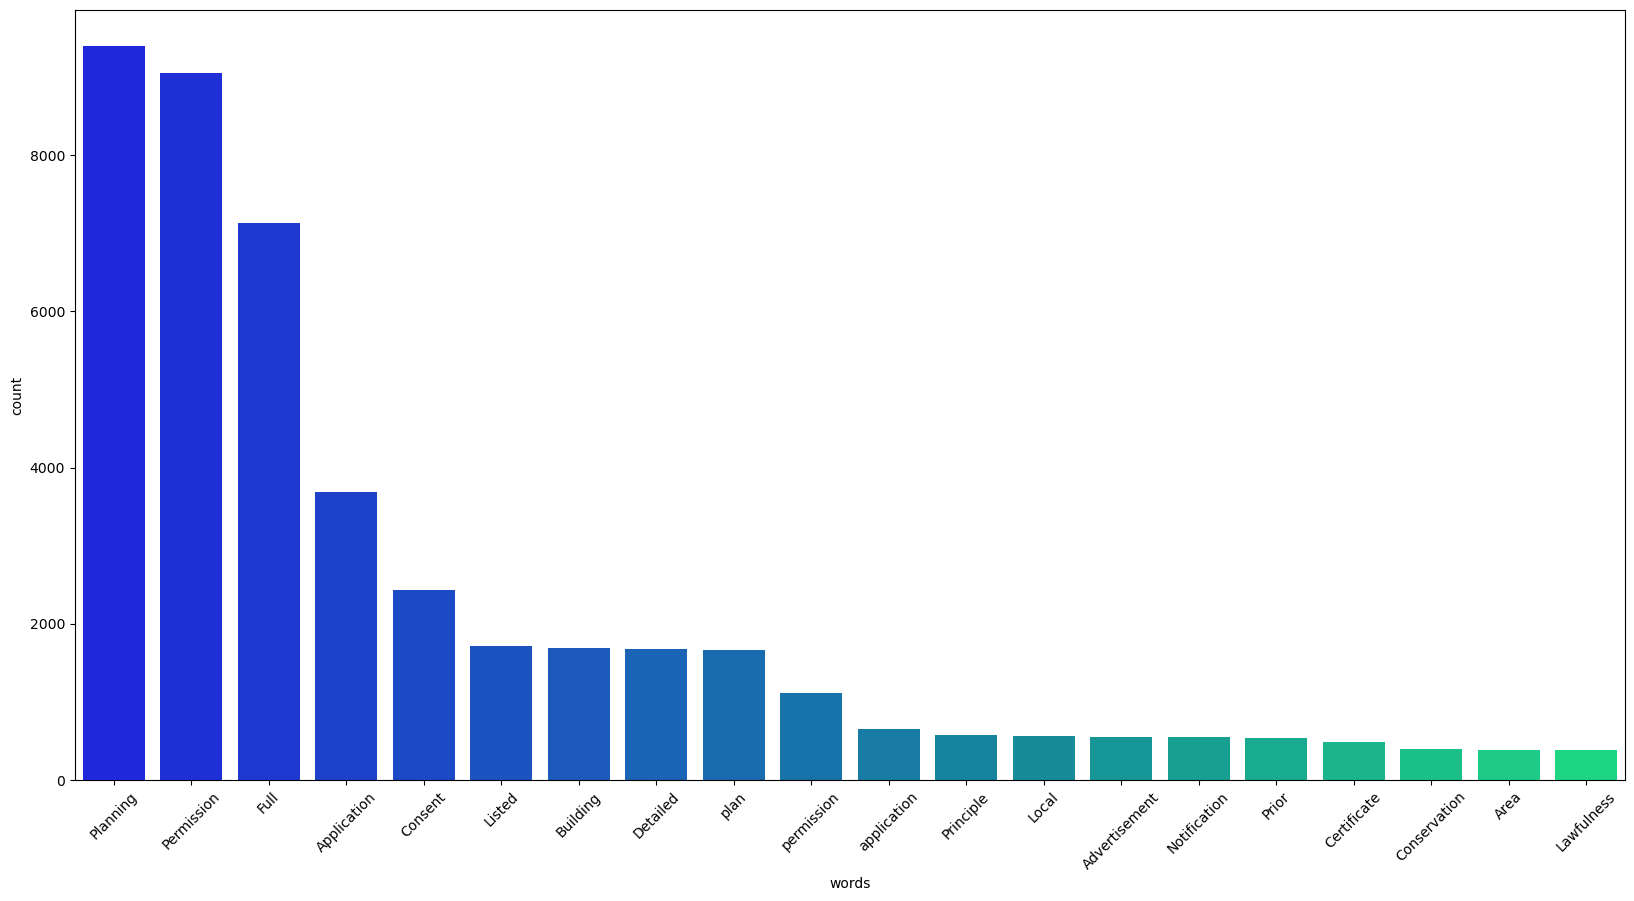

In [42]:
# Flatten the list of lists into a single list of words
desc_words_list = [word for sublist in planapp_gdf['feature_cleaned_3'] for word in sublist]

# Join all word corpus
desc_words = ' '.join(desc_words_list)

# Count and find the 30 most frequent after cleaning
word_counter = Counter(desc_words.split())
most_frequent = word_counter.most_common(20)

# Bar plot of frequent words
fig = plt.figure(1, figsize=(20, 10))
_ = pd.DataFrame(most_frequent, columns=("words", "count"))
sns.barplot(x='words', y='count', data=_, palette='winter')
plt.xticks(rotation=45)
plt.show()


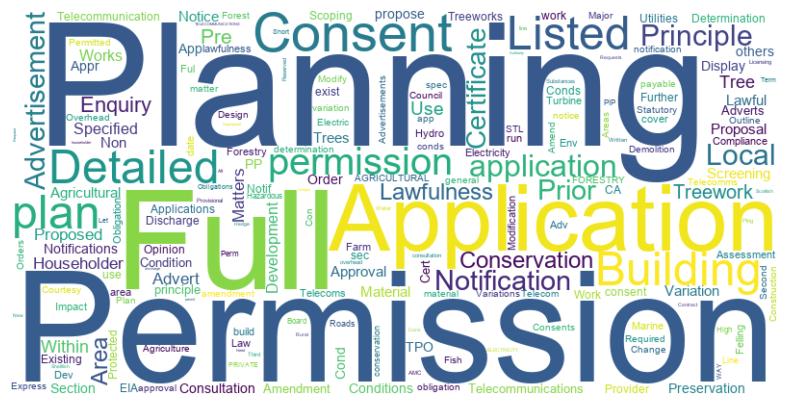

In [43]:
# Combine all words from the 'feature_cleaned_3' column into a single list
desc_words_list = [word for sublist in planapp_gdf['feature_cleaned_3'] for word in sublist]

# Join all words into a single string
data = ' '.join(desc_words_list)

# Specify the TrueType font file
font_path = 'C:\\Windows\\Fonts\\arial.ttf'

# Calculate word frequencies
word_frequencies = {word: desc_words_list.count(word) for word in set(desc_words_list)}

# Generate the word cloud using word frequencies
wordcloud = WordCloud(font_path=font_path, background_color='white', width=800, height=400).generate_from_frequencies(word_frequencies)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


## Tokenisation of phrases to create words 

In [44]:
id2word = gensim.corpora.Dictionary(planapp_gdf["feature_cleaned_3"])

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in planapp_gdf["feature_cleaned_3"]]

2023-07-23 18:46:22,244 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2023-07-23 18:46:22,521 : INFO : adding document #10000 to Dictionary<258 unique tokens: ['Application', 'Full', 'Certificate', 'Lawfulness', 'propose']...>
2023-07-23 18:46:22,789 : INFO : built Dictionary<302 unique tokens: ['Application', 'Full', 'Certificate', 'Lawfulness', 'propose']...> from 20000 documents (total 52859 corpus positions)
2023-07-23 18:46:22,790 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<302 unique tokens: ['Application', 'Full', 'Certificate', 'Lawfulness', 'propose']...> from 20000 documents (total 52859 corpus positions)", 'datetime': '2023-07-23T18:46:22.790545', 'gensim': '4.2.0', 'python': '3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:37:49) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}


In [45]:
from gensim.models import CoherenceModel, LdaMulticore

# Compute coherence score
number_of_topics = []
coherence_score = []
for i in range(1, 10):
    lda_model = LdaMulticore(corpus=corpus,
                             id2word=id2word,
                             iterations=50,
                             num_topics=i,
                             workers=8,
                             passes=2)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=planapp_gdf["feature_cleaned_3"],
                                         dictionary=id2word,
                                         coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    number_of_topics.append(i)
    coherence_score.append(coherence_lda)

    # Print coherence score for each iteration
    print(f"Iteration {i}: Coherence Score = {coherence_lda}")


2023-07-23 18:46:23,756 : INFO : using symmetric alpha at 1.0
2023-07-23 18:46:23,758 : INFO : using symmetric eta at 1.0
2023-07-23 18:46:23,760 : INFO : using serial LDA version on this node
2023-07-23 18:46:23,784 : INFO : running online LDA training, 1 topics, 2 passes over the supplied corpus of 20000 documents, updating every 16000 documents, evaluating every ~20000 documents, iterating 50x with a convergence threshold of 0.001000
2023-07-23 18:46:23,785 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2023-07-23 18:46:23,791 : INFO : training LDA model using 8 processes
2023-07-23 18:46:46,634 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/20000, outstanding queue size 1
2023-07-23 18:46:46,643 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/20000, outstanding queue size 2
2023-07-23 18:46:46,652 : INFO : PROGRESS: pass 0, dispatched chunk #2 = docum

Iteration 1: Coherence Score = -20.660648165853054


2023-07-23 18:47:18,956 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/20000, outstanding queue size 1
2023-07-23 18:47:18,969 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/20000, outstanding queue size 2
2023-07-23 18:47:18,979 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/20000, outstanding queue size 3
2023-07-23 18:47:19,001 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/20000, outstanding queue size 4
2023-07-23 18:47:19,011 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/20000, outstanding queue size 5
2023-07-23 18:47:19,022 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/20000, outstanding queue size 6
2023-07-23 18:47:19,048 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #14000/20000, outstanding queue size 7
2023-07-23 18:47:19,062 : INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #16000/20000, outst

2023-07-23 18:47:41,451 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2023-07-23 18:47:41,455 : INFO : training LDA model using 8 processes


Iteration 2: Coherence Score = -20.28738842488149


2023-07-23 18:48:15,869 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/20000, outstanding queue size 1
2023-07-23 18:48:15,877 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/20000, outstanding queue size 2
2023-07-23 18:48:15,886 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/20000, outstanding queue size 3
2023-07-23 18:48:15,895 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/20000, outstanding queue size 4
2023-07-23 18:48:15,903 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/20000, outstanding queue size 5
2023-07-23 18:48:15,912 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/20000, outstanding queue size 6
2023-07-23 18:48:15,920 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #14000/20000, outstanding queue size 7
2023-07-23 18:48:15,922 : INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #16000/20000, outst

2023-07-23 18:48:33,494 : INFO : CorpusAccumulator accumulated stats from 14000 documents
2023-07-23 18:48:33,511 : INFO : CorpusAccumulator accumulated stats from 15000 documents
2023-07-23 18:48:33,528 : INFO : CorpusAccumulator accumulated stats from 16000 documents
2023-07-23 18:48:33,542 : INFO : CorpusAccumulator accumulated stats from 17000 documents
2023-07-23 18:48:33,556 : INFO : CorpusAccumulator accumulated stats from 18000 documents
2023-07-23 18:48:33,570 : INFO : CorpusAccumulator accumulated stats from 19000 documents
2023-07-23 18:48:33,584 : INFO : CorpusAccumulator accumulated stats from 20000 documents
2023-07-23 18:48:33,624 : INFO : using symmetric alpha at 0.25
2023-07-23 18:48:33,626 : INFO : using symmetric eta at 0.25
2023-07-23 18:48:33,627 : INFO : using serial LDA version on this node
2023-07-23 18:48:33,632 : INFO : running online LDA training, 4 topics, 2 passes over the supplied corpus of 20000 documents, updating every 16000 documents, evaluating every 

Iteration 3: Coherence Score = -19.98745487506892


2023-07-23 18:49:15,484 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/20000, outstanding queue size 1
2023-07-23 18:49:15,491 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/20000, outstanding queue size 2
2023-07-23 18:49:15,498 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/20000, outstanding queue size 3
2023-07-23 18:49:15,506 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/20000, outstanding queue size 4
2023-07-23 18:49:15,514 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/20000, outstanding queue size 5
2023-07-23 18:49:15,524 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/20000, outstanding queue size 6
2023-07-23 18:49:15,533 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #14000/20000, outstanding queue size 7
2023-07-23 18:49:15,541 : INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #16000/20000, outst

2023-07-23 18:49:29,843 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2023-07-23 18:49:29,859 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2023-07-23 18:49:29,875 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2023-07-23 18:49:29,890 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2023-07-23 18:49:29,907 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2023-07-23 18:49:29,923 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2023-07-23 18:49:29,938 : INFO : CorpusAccumulator accumulated stats from 10000 documents
2023-07-23 18:49:29,953 : INFO : CorpusAccumulator accumulated stats from 11000 documents
2023-07-23 18:49:29,966 : INFO : CorpusAccumulator accumulated stats from 12000 documents
2023-07-23 18:49:29,980 : INFO : CorpusAccumulator accumulated stats from 13000 documents
2023-07-23 18:49:29,995 : INFO : CorpusAccumulator accumulated stats from 14000 documents
2023-07-23 18:49

Iteration 4: Coherence Score = -20.615774195515378


2023-07-23 18:50:06,344 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/20000, outstanding queue size 1
2023-07-23 18:50:06,351 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/20000, outstanding queue size 2
2023-07-23 18:50:06,359 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/20000, outstanding queue size 3
2023-07-23 18:50:06,367 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/20000, outstanding queue size 4
2023-07-23 18:50:06,375 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/20000, outstanding queue size 5
2023-07-23 18:50:06,385 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/20000, outstanding queue size 6
2023-07-23 18:50:06,398 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #14000/20000, outstanding queue size 7
2023-07-23 18:50:06,413 : INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #16000/20000, outst

2023-07-23 18:50:17,342 : INFO : topic diff=0.246328, rho=0.288675
2023-07-23 18:50:18,711 : INFO : -3.172 per-word bound, 9.0 perplexity estimate based on a held-out corpus of 2000 documents with 5302 words
2023-07-23 18:50:18,795 : INFO : LdaMulticore lifecycle event {'msg': 'trained LdaMulticore<num_terms=302, num_topics=5, decay=0.5, chunksize=2000> in 48.63s', 'datetime': '2023-07-23T18:50:18.795596', 'gensim': '4.2.0', 'python': '3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:37:49) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
2023-07-23 18:50:19,091 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2023-07-23 18:50:19,106 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2023-07-23 18:50:19,124 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2023-07-23 18:50:19,141 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2023-07-23 18:50:19,159 : INFO : CorpusAccumu

Iteration 5: Coherence Score = -20.568075008239685


2023-07-23 18:50:55,370 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/20000, outstanding queue size 1
2023-07-23 18:50:55,378 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/20000, outstanding queue size 2
2023-07-23 18:50:55,386 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/20000, outstanding queue size 3
2023-07-23 18:50:55,394 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/20000, outstanding queue size 4
2023-07-23 18:50:55,401 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/20000, outstanding queue size 5
2023-07-23 18:50:55,409 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/20000, outstanding queue size 6
2023-07-23 18:50:55,417 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #14000/20000, outstanding queue size 7
2023-07-23 18:50:55,432 : INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #16000/20000, outst

2023-07-23 18:51:05,861 : INFO : topic diff=0.246306, rho=0.288675
2023-07-23 18:51:07,340 : INFO : -3.153 per-word bound, 8.9 perplexity estimate based on a held-out corpus of 2000 documents with 5302 words
2023-07-23 18:51:07,418 : INFO : LdaMulticore lifecycle event {'msg': 'trained LdaMulticore<num_terms=302, num_topics=6, decay=0.5, chunksize=2000> in 47.91s', 'datetime': '2023-07-23T18:51:07.417708', 'gensim': '4.2.0', 'python': '3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:37:49) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
2023-07-23 18:51:07,777 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2023-07-23 18:51:07,792 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2023-07-23 18:51:07,806 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2023-07-23 18:51:07,819 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2023-07-23 18:51:07,833 : INFO : CorpusAccumu

Iteration 6: Coherence Score = -20.24850075386016


2023-07-23 18:51:44,631 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/20000, outstanding queue size 1
2023-07-23 18:51:44,639 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/20000, outstanding queue size 2
2023-07-23 18:51:44,646 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/20000, outstanding queue size 3
2023-07-23 18:51:44,654 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/20000, outstanding queue size 4
2023-07-23 18:51:44,664 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/20000, outstanding queue size 5
2023-07-23 18:51:44,671 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/20000, outstanding queue size 6
2023-07-23 18:51:44,680 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #14000/20000, outstanding queue size 7
2023-07-23 18:51:44,702 : INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #16000/20000, outst

2023-07-23 18:51:56,940 : INFO : topic diff=0.226394, rho=0.288675
2023-07-23 18:51:58,517 : INFO : -3.222 per-word bound, 9.3 perplexity estimate based on a held-out corpus of 2000 documents with 5302 words
2023-07-23 18:51:58,634 : INFO : LdaMulticore lifecycle event {'msg': 'trained LdaMulticore<num_terms=302, num_topics=7, decay=0.5, chunksize=2000> in 50.49s', 'datetime': '2023-07-23T18:51:58.634527', 'gensim': '4.2.0', 'python': '3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:37:49) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
2023-07-23 18:51:58,949 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2023-07-23 18:51:58,964 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2023-07-23 18:51:58,983 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2023-07-23 18:51:59,000 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2023-07-23 18:51:59,015 : INFO : CorpusAccumu

Iteration 7: Coherence Score = -19.97854663831348


2023-07-23 18:52:32,337 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/20000, outstanding queue size 1
2023-07-23 18:52:32,344 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/20000, outstanding queue size 2
2023-07-23 18:52:32,351 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/20000, outstanding queue size 3
2023-07-23 18:52:32,359 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/20000, outstanding queue size 4
2023-07-23 18:52:32,367 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/20000, outstanding queue size 5
2023-07-23 18:52:32,377 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/20000, outstanding queue size 6
2023-07-23 18:52:32,386 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #14000/20000, outstanding queue size 7
2023-07-23 18:52:32,389 : INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #16000/20000, outst

2023-07-23 18:52:43,396 : INFO : topic diff=0.224461, rho=0.288675
2023-07-23 18:52:44,904 : INFO : -3.220 per-word bound, 9.3 perplexity estimate based on a held-out corpus of 2000 documents with 5302 words
2023-07-23 18:52:45,057 : INFO : LdaMulticore lifecycle event {'msg': 'trained LdaMulticore<num_terms=302, num_topics=8, decay=0.5, chunksize=2000> in 45.68s', 'datetime': '2023-07-23T18:52:45.057794', 'gensim': '4.2.0', 'python': '3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:37:49) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
2023-07-23 18:52:45,389 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2023-07-23 18:52:45,405 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2023-07-23 18:52:45,425 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2023-07-23 18:52:45,444 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2023-07-23 18:52:45,462 : INFO : CorpusAccumu

Iteration 8: Coherence Score = -19.888862221197577


2023-07-23 18:53:20,115 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/20000, outstanding queue size 1
2023-07-23 18:53:20,123 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/20000, outstanding queue size 2
2023-07-23 18:53:20,132 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/20000, outstanding queue size 3
2023-07-23 18:53:20,140 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/20000, outstanding queue size 4
2023-07-23 18:53:20,150 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/20000, outstanding queue size 5
2023-07-23 18:53:20,160 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/20000, outstanding queue size 6
2023-07-23 18:53:20,175 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #14000/20000, outstanding queue size 7
2023-07-23 18:53:20,178 : INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #16000/20000, outst

2023-07-23 18:53:32,114 : INFO : topic diff=0.213278, rho=0.288675
2023-07-23 18:53:34,005 : INFO : -3.282 per-word bound, 9.7 perplexity estimate based on a held-out corpus of 2000 documents with 5302 words
2023-07-23 18:53:34,119 : INFO : LdaMulticore lifecycle event {'msg': 'trained LdaMulticore<num_terms=302, num_topics=9, decay=0.5, chunksize=2000> in 48.29s', 'datetime': '2023-07-23T18:53:34.119079', 'gensim': '4.2.0', 'python': '3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:37:49) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
2023-07-23 18:53:34,837 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2023-07-23 18:53:34,851 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2023-07-23 18:53:34,865 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2023-07-23 18:53:34,879 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2023-07-23 18:53:34,900 : INFO : CorpusAccumu

Iteration 9: Coherence Score = -19.969663254221096


## plot using window and smoothing

<AxesSubplot:xlabel='number_of_topics', ylabel='coherence_score_smoothed'>

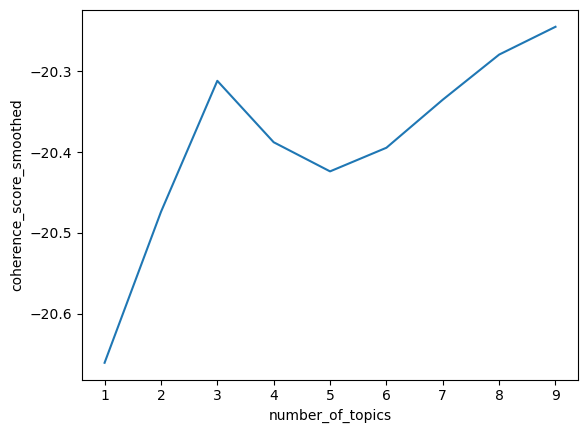

In [46]:
# compute coherence scores
topic_coherence = pd.DataFrame({'number_of_topics': number_of_topics,
                                'coherence_score': coherence_score})

# compute moving average with window size 3 
topic_coherence['coherence_score_smoothed'] = topic_coherence['coherence_score'].rolling(window=50, min_periods=1).mean()

# plot the smoothed coherence scores
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score_smoothed')


## Topic Modelling

In [47]:
import logging

n_topics = 8

# Set logging level to INFO for verbose logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Run the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=0,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

2023-07-23 18:53:35,919 : INFO : using symmetric alpha at 0.125
2023-07-23 18:53:35,921 : INFO : using symmetric eta at 0.125
2023-07-23 18:53:35,927 : INFO : using serial LDA version on this node
2023-07-23 18:53:35,931 : INFO : running batch LDA training, 8 topics, 10 passes over the supplied corpus of 20000 documents, updating model once every 20000 documents, evaluating perplexity every 100 documents, iterating 100x with a convergence threshold of 0.001000
2023-07-23 18:53:35,934 : INFO : PROGRESS: pass 0, at document #10/20000
2023-07-23 18:53:35,949 : INFO : PROGRESS: pass 0, at document #20/20000
2023-07-23 18:53:35,960 : INFO : PROGRESS: pass 0, at document #30/20000
2023-07-23 18:53:35,973 : INFO : PROGRESS: pass 0, at document #40/20000
2023-07-23 18:53:35,985 : INFO : PROGRESS: pass 0, at document #50/20000
2023-07-23 18:53:35,996 : INFO : PROGRESS: pass 0, at document #60/20000
2023-07-23 18:53:36,007 : INFO : PROGRESS: pass 0, at document #70/20000
2023-07-23 18:53:36,018 

2023-07-23 18:53:37,153 : INFO : PROGRESS: pass 0, at document #900/20000
2023-07-23 18:53:37,166 : INFO : PROGRESS: pass 0, at document #910/20000
2023-07-23 18:53:37,178 : INFO : PROGRESS: pass 0, at document #920/20000
2023-07-23 18:53:37,187 : INFO : PROGRESS: pass 0, at document #930/20000
2023-07-23 18:53:37,198 : INFO : PROGRESS: pass 0, at document #940/20000
2023-07-23 18:53:37,209 : INFO : PROGRESS: pass 0, at document #950/20000
2023-07-23 18:53:37,218 : INFO : PROGRESS: pass 0, at document #960/20000
2023-07-23 18:53:37,228 : INFO : PROGRESS: pass 0, at document #970/20000
2023-07-23 18:53:37,239 : INFO : PROGRESS: pass 0, at document #980/20000
2023-07-23 18:53:37,251 : INFO : PROGRESS: pass 0, at document #990/20000
2023-07-23 18:53:37,271 : INFO : -7.127 per-word bound, 139.8 perplexity estimate based on a held-out corpus of 10 documents with 30 words
2023-07-23 18:53:37,273 : INFO : PROGRESS: pass 0, at document #1000/20000
2023-07-23 18:53:37,284 : INFO : PROGRESS: pas

2023-07-23 18:53:39,384 : INFO : PROGRESS: pass 0, at document #1830/20000
2023-07-23 18:53:39,396 : INFO : PROGRESS: pass 0, at document #1840/20000
2023-07-23 18:53:39,443 : INFO : PROGRESS: pass 0, at document #1850/20000
2023-07-23 18:53:39,453 : INFO : PROGRESS: pass 0, at document #1860/20000
2023-07-23 18:53:39,465 : INFO : PROGRESS: pass 0, at document #1870/20000
2023-07-23 18:53:39,503 : INFO : PROGRESS: pass 0, at document #1880/20000
2023-07-23 18:53:39,516 : INFO : PROGRESS: pass 0, at document #1890/20000
2023-07-23 18:53:39,560 : INFO : -7.235 per-word bound, 150.7 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:53:39,562 : INFO : PROGRESS: pass 0, at document #1900/20000
2023-07-23 18:53:39,574 : INFO : PROGRESS: pass 0, at document #1910/20000
2023-07-23 18:53:39,585 : INFO : PROGRESS: pass 0, at document #1920/20000
2023-07-23 18:53:39,598 : INFO : PROGRESS: pass 0, at document #1930/20000
2023-07-23 18:53:39,641 : INFO : PRO

2023-07-23 18:53:41,206 : INFO : PROGRESS: pass 0, at document #2760/20000
2023-07-23 18:53:41,219 : INFO : PROGRESS: pass 0, at document #2770/20000
2023-07-23 18:53:41,232 : INFO : PROGRESS: pass 0, at document #2780/20000
2023-07-23 18:53:41,244 : INFO : PROGRESS: pass 0, at document #2790/20000
2023-07-23 18:53:41,269 : INFO : -7.252 per-word bound, 152.4 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:53:41,271 : INFO : PROGRESS: pass 0, at document #2800/20000
2023-07-23 18:53:41,284 : INFO : PROGRESS: pass 0, at document #2810/20000
2023-07-23 18:53:41,297 : INFO : PROGRESS: pass 0, at document #2820/20000
2023-07-23 18:53:41,307 : INFO : PROGRESS: pass 0, at document #2830/20000
2023-07-23 18:53:41,324 : INFO : PROGRESS: pass 0, at document #2840/20000
2023-07-23 18:53:41,340 : INFO : PROGRESS: pass 0, at document #2850/20000
2023-07-23 18:53:41,353 : INFO : PROGRESS: pass 0, at document #2860/20000
2023-07-23 18:53:41,366 : INFO : PRO

2023-07-23 18:53:42,486 : INFO : PROGRESS: pass 0, at document #3690/20000
2023-07-23 18:53:42,506 : INFO : -7.223 per-word bound, 149.4 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:53:42,507 : INFO : PROGRESS: pass 0, at document #3700/20000
2023-07-23 18:53:42,518 : INFO : PROGRESS: pass 0, at document #3710/20000
2023-07-23 18:53:42,529 : INFO : PROGRESS: pass 0, at document #3720/20000
2023-07-23 18:53:42,542 : INFO : PROGRESS: pass 0, at document #3730/20000
2023-07-23 18:53:42,557 : INFO : PROGRESS: pass 0, at document #3740/20000
2023-07-23 18:53:42,568 : INFO : PROGRESS: pass 0, at document #3750/20000
2023-07-23 18:53:42,579 : INFO : PROGRESS: pass 0, at document #3760/20000
2023-07-23 18:53:42,589 : INFO : PROGRESS: pass 0, at document #3770/20000
2023-07-23 18:53:42,601 : INFO : PROGRESS: pass 0, at document #3780/20000
2023-07-23 18:53:42,609 : INFO : PROGRESS: pass 0, at document #3790/20000
2023-07-23 18:53:42,631 : INFO : -7.

2023-07-23 18:53:43,598 : INFO : PROGRESS: pass 0, at document #4600/20000
2023-07-23 18:53:43,612 : INFO : PROGRESS: pass 0, at document #4610/20000
2023-07-23 18:53:43,622 : INFO : PROGRESS: pass 0, at document #4620/20000
2023-07-23 18:53:43,635 : INFO : PROGRESS: pass 0, at document #4630/20000
2023-07-23 18:53:43,643 : INFO : PROGRESS: pass 0, at document #4640/20000
2023-07-23 18:53:43,653 : INFO : PROGRESS: pass 0, at document #4650/20000
2023-07-23 18:53:43,662 : INFO : PROGRESS: pass 0, at document #4660/20000
2023-07-23 18:53:43,673 : INFO : PROGRESS: pass 0, at document #4670/20000
2023-07-23 18:53:43,688 : INFO : PROGRESS: pass 0, at document #4680/20000
2023-07-23 18:53:43,699 : INFO : PROGRESS: pass 0, at document #4690/20000
2023-07-23 18:53:43,718 : INFO : -7.374 per-word bound, 165.9 perplexity estimate based on a held-out corpus of 10 documents with 22 words
2023-07-23 18:53:43,719 : INFO : PROGRESS: pass 0, at document #4700/20000
2023-07-23 18:53:43,728 : INFO : PRO

2023-07-23 18:53:45,181 : INFO : PROGRESS: pass 0, at document #5530/20000
2023-07-23 18:53:45,231 : INFO : PROGRESS: pass 0, at document #5540/20000
2023-07-23 18:53:45,246 : INFO : PROGRESS: pass 0, at document #5550/20000
2023-07-23 18:53:45,259 : INFO : PROGRESS: pass 0, at document #5560/20000
2023-07-23 18:53:45,306 : INFO : PROGRESS: pass 0, at document #5570/20000
2023-07-23 18:53:45,319 : INFO : PROGRESS: pass 0, at document #5580/20000
2023-07-23 18:53:45,332 : INFO : PROGRESS: pass 0, at document #5590/20000
2023-07-23 18:53:45,383 : INFO : -7.290 per-word bound, 156.5 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:53:45,385 : INFO : PROGRESS: pass 0, at document #5600/20000
2023-07-23 18:53:45,398 : INFO : PROGRESS: pass 0, at document #5610/20000
2023-07-23 18:53:45,469 : INFO : PROGRESS: pass 0, at document #5620/20000
2023-07-23 18:53:45,482 : INFO : PROGRESS: pass 0, at document #5630/20000
2023-07-23 18:53:45,497 : INFO : PRO

2023-07-23 18:53:47,003 : INFO : PROGRESS: pass 0, at document #6460/20000
2023-07-23 18:53:47,018 : INFO : PROGRESS: pass 0, at document #6470/20000
2023-07-23 18:53:47,032 : INFO : PROGRESS: pass 0, at document #6480/20000
2023-07-23 18:53:47,045 : INFO : PROGRESS: pass 0, at document #6490/20000
2023-07-23 18:53:47,071 : INFO : -7.237 per-word bound, 150.8 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:53:47,073 : INFO : PROGRESS: pass 0, at document #6500/20000
2023-07-23 18:53:47,087 : INFO : PROGRESS: pass 0, at document #6510/20000
2023-07-23 18:53:47,102 : INFO : PROGRESS: pass 0, at document #6520/20000
2023-07-23 18:53:47,116 : INFO : PROGRESS: pass 0, at document #6530/20000
2023-07-23 18:53:47,131 : INFO : PROGRESS: pass 0, at document #6540/20000
2023-07-23 18:53:47,145 : INFO : PROGRESS: pass 0, at document #6550/20000
2023-07-23 18:53:47,160 : INFO : PROGRESS: pass 0, at document #6560/20000
2023-07-23 18:53:47,177 : INFO : PRO

2023-07-23 18:53:48,216 : INFO : PROGRESS: pass 0, at document #7390/20000
2023-07-23 18:53:48,238 : INFO : -7.379 per-word bound, 166.4 perplexity estimate based on a held-out corpus of 10 documents with 22 words
2023-07-23 18:53:48,240 : INFO : PROGRESS: pass 0, at document #7400/20000
2023-07-23 18:53:48,254 : INFO : PROGRESS: pass 0, at document #7410/20000
2023-07-23 18:53:48,266 : INFO : PROGRESS: pass 0, at document #7420/20000
2023-07-23 18:53:48,279 : INFO : PROGRESS: pass 0, at document #7430/20000
2023-07-23 18:53:48,291 : INFO : PROGRESS: pass 0, at document #7440/20000
2023-07-23 18:53:48,301 : INFO : PROGRESS: pass 0, at document #7450/20000
2023-07-23 18:53:48,313 : INFO : PROGRESS: pass 0, at document #7460/20000
2023-07-23 18:53:48,322 : INFO : PROGRESS: pass 0, at document #7470/20000
2023-07-23 18:53:48,333 : INFO : PROGRESS: pass 0, at document #7480/20000
2023-07-23 18:53:48,344 : INFO : PROGRESS: pass 0, at document #7490/20000
2023-07-23 18:53:48,365 : INFO : -7.

2023-07-23 18:53:49,327 : INFO : PROGRESS: pass 0, at document #8300/20000
2023-07-23 18:53:49,339 : INFO : PROGRESS: pass 0, at document #8310/20000
2023-07-23 18:53:49,350 : INFO : PROGRESS: pass 0, at document #8320/20000
2023-07-23 18:53:49,360 : INFO : PROGRESS: pass 0, at document #8330/20000
2023-07-23 18:53:49,371 : INFO : PROGRESS: pass 0, at document #8340/20000
2023-07-23 18:53:49,381 : INFO : PROGRESS: pass 0, at document #8350/20000
2023-07-23 18:53:49,391 : INFO : PROGRESS: pass 0, at document #8360/20000
2023-07-23 18:53:49,401 : INFO : PROGRESS: pass 0, at document #8370/20000
2023-07-23 18:53:49,410 : INFO : PROGRESS: pass 0, at document #8380/20000
2023-07-23 18:53:49,420 : INFO : PROGRESS: pass 0, at document #8390/20000
2023-07-23 18:53:49,441 : INFO : -7.204 per-word bound, 147.5 perplexity estimate based on a held-out corpus of 10 documents with 30 words
2023-07-23 18:53:49,445 : INFO : PROGRESS: pass 0, at document #8400/20000
2023-07-23 18:53:49,455 : INFO : PRO

2023-07-23 18:53:50,429 : INFO : PROGRESS: pass 0, at document #9230/20000
2023-07-23 18:53:50,442 : INFO : PROGRESS: pass 0, at document #9240/20000
2023-07-23 18:53:50,455 : INFO : PROGRESS: pass 0, at document #9250/20000
2023-07-23 18:53:50,470 : INFO : PROGRESS: pass 0, at document #9260/20000
2023-07-23 18:53:50,482 : INFO : PROGRESS: pass 0, at document #9270/20000
2023-07-23 18:53:50,498 : INFO : PROGRESS: pass 0, at document #9280/20000
2023-07-23 18:53:50,512 : INFO : PROGRESS: pass 0, at document #9290/20000
2023-07-23 18:53:50,542 : INFO : -7.228 per-word bound, 149.9 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:53:50,545 : INFO : PROGRESS: pass 0, at document #9300/20000
2023-07-23 18:53:50,564 : INFO : PROGRESS: pass 0, at document #9310/20000
2023-07-23 18:53:50,576 : INFO : PROGRESS: pass 0, at document #9320/20000
2023-07-23 18:53:50,588 : INFO : PROGRESS: pass 0, at document #9330/20000
2023-07-23 18:53:50,603 : INFO : PRO

2023-07-23 18:53:51,611 : INFO : PROGRESS: pass 0, at document #10160/20000
2023-07-23 18:53:51,621 : INFO : PROGRESS: pass 0, at document #10170/20000
2023-07-23 18:53:51,630 : INFO : PROGRESS: pass 0, at document #10180/20000
2023-07-23 18:53:51,641 : INFO : PROGRESS: pass 0, at document #10190/20000
2023-07-23 18:53:51,660 : INFO : -7.161 per-word bound, 143.2 perplexity estimate based on a held-out corpus of 10 documents with 29 words
2023-07-23 18:53:51,661 : INFO : PROGRESS: pass 0, at document #10200/20000
2023-07-23 18:53:51,671 : INFO : PROGRESS: pass 0, at document #10210/20000
2023-07-23 18:53:51,680 : INFO : PROGRESS: pass 0, at document #10220/20000
2023-07-23 18:53:51,691 : INFO : PROGRESS: pass 0, at document #10230/20000
2023-07-23 18:53:51,701 : INFO : PROGRESS: pass 0, at document #10240/20000
2023-07-23 18:53:51,712 : INFO : PROGRESS: pass 0, at document #10250/20000
2023-07-23 18:53:51,723 : INFO : PROGRESS: pass 0, at document #10260/20000
2023-07-23 18:53:51,735 :

2023-07-23 18:53:52,693 : INFO : PROGRESS: pass 0, at document #11080/20000
2023-07-23 18:53:52,702 : INFO : PROGRESS: pass 0, at document #11090/20000
2023-07-23 18:53:52,722 : INFO : -7.242 per-word bound, 151.3 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:53:52,723 : INFO : PROGRESS: pass 0, at document #11100/20000
2023-07-23 18:53:52,737 : INFO : PROGRESS: pass 0, at document #11110/20000
2023-07-23 18:53:52,749 : INFO : PROGRESS: pass 0, at document #11120/20000
2023-07-23 18:53:52,761 : INFO : PROGRESS: pass 0, at document #11130/20000
2023-07-23 18:53:52,777 : INFO : PROGRESS: pass 0, at document #11140/20000
2023-07-23 18:53:52,789 : INFO : PROGRESS: pass 0, at document #11150/20000
2023-07-23 18:53:52,800 : INFO : PROGRESS: pass 0, at document #11160/20000
2023-07-23 18:53:52,812 : INFO : PROGRESS: pass 0, at document #11170/20000
2023-07-23 18:53:52,822 : INFO : PROGRESS: pass 0, at document #11180/20000
2023-07-23 18:53:52,832 :

2023-07-23 18:53:53,766 : INFO : -7.269 per-word bound, 154.2 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:53:53,767 : INFO : PROGRESS: pass 0, at document #12000/20000
2023-07-23 18:53:53,778 : INFO : PROGRESS: pass 0, at document #12010/20000
2023-07-23 18:53:53,788 : INFO : PROGRESS: pass 0, at document #12020/20000
2023-07-23 18:53:53,798 : INFO : PROGRESS: pass 0, at document #12030/20000
2023-07-23 18:53:53,807 : INFO : PROGRESS: pass 0, at document #12040/20000
2023-07-23 18:53:53,819 : INFO : PROGRESS: pass 0, at document #12050/20000
2023-07-23 18:53:53,829 : INFO : PROGRESS: pass 0, at document #12060/20000
2023-07-23 18:53:53,837 : INFO : PROGRESS: pass 0, at document #12070/20000
2023-07-23 18:53:53,848 : INFO : PROGRESS: pass 0, at document #12080/20000
2023-07-23 18:53:53,858 : INFO : PROGRESS: pass 0, at document #12090/20000
2023-07-23 18:53:53,876 : INFO : -7.212 per-word bound, 148.2 perplexity estimate based on a held-out

2023-07-23 18:53:54,904 : INFO : PROGRESS: pass 0, at document #12900/20000
2023-07-23 18:53:54,919 : INFO : PROGRESS: pass 0, at document #12910/20000
2023-07-23 18:53:54,932 : INFO : PROGRESS: pass 0, at document #12920/20000
2023-07-23 18:53:54,945 : INFO : PROGRESS: pass 0, at document #12930/20000
2023-07-23 18:53:54,955 : INFO : PROGRESS: pass 0, at document #12940/20000
2023-07-23 18:53:54,967 : INFO : PROGRESS: pass 0, at document #12950/20000
2023-07-23 18:53:54,978 : INFO : PROGRESS: pass 0, at document #12960/20000
2023-07-23 18:53:54,989 : INFO : PROGRESS: pass 0, at document #12970/20000
2023-07-23 18:53:55,002 : INFO : PROGRESS: pass 0, at document #12980/20000
2023-07-23 18:53:55,014 : INFO : PROGRESS: pass 0, at document #12990/20000
2023-07-23 18:53:55,048 : INFO : -7.180 per-word bound, 145.0 perplexity estimate based on a held-out corpus of 10 documents with 29 words
2023-07-23 18:53:55,050 : INFO : PROGRESS: pass 0, at document #13000/20000
2023-07-23 18:53:55,064 :

2023-07-23 18:53:56,104 : INFO : PROGRESS: pass 0, at document #13820/20000
2023-07-23 18:53:56,116 : INFO : PROGRESS: pass 0, at document #13830/20000
2023-07-23 18:53:56,129 : INFO : PROGRESS: pass 0, at document #13840/20000
2023-07-23 18:53:56,140 : INFO : PROGRESS: pass 0, at document #13850/20000
2023-07-23 18:53:56,150 : INFO : PROGRESS: pass 0, at document #13860/20000
2023-07-23 18:53:56,161 : INFO : PROGRESS: pass 0, at document #13870/20000
2023-07-23 18:53:56,171 : INFO : PROGRESS: pass 0, at document #13880/20000
2023-07-23 18:53:56,183 : INFO : PROGRESS: pass 0, at document #13890/20000
2023-07-23 18:53:56,201 : INFO : -7.310 per-word bound, 158.7 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:53:56,202 : INFO : PROGRESS: pass 0, at document #13900/20000
2023-07-23 18:53:56,214 : INFO : PROGRESS: pass 0, at document #13910/20000
2023-07-23 18:53:56,225 : INFO : PROGRESS: pass 0, at document #13920/20000
2023-07-23 18:53:56,236 :

2023-07-23 18:53:57,317 : INFO : PROGRESS: pass 0, at document #14740/20000
2023-07-23 18:53:57,328 : INFO : PROGRESS: pass 0, at document #14750/20000
2023-07-23 18:53:57,342 : INFO : PROGRESS: pass 0, at document #14760/20000
2023-07-23 18:53:57,353 : INFO : PROGRESS: pass 0, at document #14770/20000
2023-07-23 18:53:57,365 : INFO : PROGRESS: pass 0, at document #14780/20000
2023-07-23 18:53:57,381 : INFO : PROGRESS: pass 0, at document #14790/20000
2023-07-23 18:53:57,408 : INFO : -7.246 per-word bound, 151.8 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:53:57,411 : INFO : PROGRESS: pass 0, at document #14800/20000
2023-07-23 18:53:57,428 : INFO : PROGRESS: pass 0, at document #14810/20000
2023-07-23 18:53:57,443 : INFO : PROGRESS: pass 0, at document #14820/20000
2023-07-23 18:53:57,456 : INFO : PROGRESS: pass 0, at document #14830/20000
2023-07-23 18:53:57,472 : INFO : PROGRESS: pass 0, at document #14840/20000
2023-07-23 18:53:57,485 :

2023-07-23 18:53:58,482 : INFO : PROGRESS: pass 0, at document #15660/20000
2023-07-23 18:53:58,492 : INFO : PROGRESS: pass 0, at document #15670/20000
2023-07-23 18:53:58,503 : INFO : PROGRESS: pass 0, at document #15680/20000
2023-07-23 18:53:58,512 : INFO : PROGRESS: pass 0, at document #15690/20000
2023-07-23 18:53:58,532 : INFO : -7.242 per-word bound, 151.4 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:53:58,534 : INFO : PROGRESS: pass 0, at document #15700/20000
2023-07-23 18:53:58,546 : INFO : PROGRESS: pass 0, at document #15710/20000
2023-07-23 18:53:58,555 : INFO : PROGRESS: pass 0, at document #15720/20000
2023-07-23 18:53:58,567 : INFO : PROGRESS: pass 0, at document #15730/20000
2023-07-23 18:53:58,577 : INFO : PROGRESS: pass 0, at document #15740/20000
2023-07-23 18:53:58,588 : INFO : PROGRESS: pass 0, at document #15750/20000
2023-07-23 18:53:58,597 : INFO : PROGRESS: pass 0, at document #15760/20000
2023-07-23 18:53:58,608 :

2023-07-23 18:53:59,649 : INFO : PROGRESS: pass 0, at document #16580/20000
2023-07-23 18:53:59,660 : INFO : PROGRESS: pass 0, at document #16590/20000
2023-07-23 18:53:59,682 : INFO : -7.268 per-word bound, 154.2 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:53:59,684 : INFO : PROGRESS: pass 0, at document #16600/20000
2023-07-23 18:53:59,695 : INFO : PROGRESS: pass 0, at document #16610/20000
2023-07-23 18:53:59,707 : INFO : PROGRESS: pass 0, at document #16620/20000
2023-07-23 18:53:59,722 : INFO : PROGRESS: pass 0, at document #16630/20000
2023-07-23 18:53:59,735 : INFO : PROGRESS: pass 0, at document #16640/20000
2023-07-23 18:53:59,750 : INFO : PROGRESS: pass 0, at document #16650/20000
2023-07-23 18:53:59,853 : INFO : PROGRESS: pass 0, at document #16660/20000
2023-07-23 18:53:59,865 : INFO : PROGRESS: pass 0, at document #16670/20000
2023-07-23 18:53:59,878 : INFO : PROGRESS: pass 0, at document #16680/20000
2023-07-23 18:53:59,918 :

2023-07-23 18:54:01,880 : INFO : -7.281 per-word bound, 155.5 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:54:01,882 : INFO : PROGRESS: pass 0, at document #17500/20000
2023-07-23 18:54:01,897 : INFO : PROGRESS: pass 0, at document #17510/20000
2023-07-23 18:54:01,908 : INFO : PROGRESS: pass 0, at document #17520/20000
2023-07-23 18:54:01,924 : INFO : PROGRESS: pass 0, at document #17530/20000
2023-07-23 18:54:01,936 : INFO : PROGRESS: pass 0, at document #17540/20000
2023-07-23 18:54:01,949 : INFO : PROGRESS: pass 0, at document #17550/20000
2023-07-23 18:54:01,964 : INFO : PROGRESS: pass 0, at document #17560/20000
2023-07-23 18:54:01,976 : INFO : PROGRESS: pass 0, at document #17570/20000
2023-07-23 18:54:01,988 : INFO : PROGRESS: pass 0, at document #17580/20000
2023-07-23 18:54:02,008 : INFO : PROGRESS: pass 0, at document #17590/20000
2023-07-23 18:54:02,031 : INFO : -7.313 per-word bound, 159.0 perplexity estimate based on a held-out

2023-07-23 18:54:03,222 : INFO : PROGRESS: pass 0, at document #18400/20000
2023-07-23 18:54:03,237 : INFO : PROGRESS: pass 0, at document #18410/20000
2023-07-23 18:54:03,253 : INFO : PROGRESS: pass 0, at document #18420/20000
2023-07-23 18:54:03,269 : INFO : PROGRESS: pass 0, at document #18430/20000
2023-07-23 18:54:03,284 : INFO : PROGRESS: pass 0, at document #18440/20000
2023-07-23 18:54:03,299 : INFO : PROGRESS: pass 0, at document #18450/20000
2023-07-23 18:54:03,320 : INFO : PROGRESS: pass 0, at document #18460/20000
2023-07-23 18:54:03,335 : INFO : PROGRESS: pass 0, at document #18470/20000
2023-07-23 18:54:03,351 : INFO : PROGRESS: pass 0, at document #18480/20000
2023-07-23 18:54:03,369 : INFO : PROGRESS: pass 0, at document #18490/20000
2023-07-23 18:54:03,395 : INFO : -7.228 per-word bound, 149.9 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:54:03,396 : INFO : PROGRESS: pass 0, at document #18500/20000
2023-07-23 18:54:03,410 :

2023-07-23 18:54:04,597 : INFO : PROGRESS: pass 0, at document #19320/20000
2023-07-23 18:54:04,608 : INFO : PROGRESS: pass 0, at document #19330/20000
2023-07-23 18:54:04,618 : INFO : PROGRESS: pass 0, at document #19340/20000
2023-07-23 18:54:04,631 : INFO : PROGRESS: pass 0, at document #19350/20000
2023-07-23 18:54:04,643 : INFO : PROGRESS: pass 0, at document #19360/20000
2023-07-23 18:54:04,655 : INFO : PROGRESS: pass 0, at document #19370/20000
2023-07-23 18:54:04,670 : INFO : PROGRESS: pass 0, at document #19380/20000
2023-07-23 18:54:04,681 : INFO : PROGRESS: pass 0, at document #19390/20000
2023-07-23 18:54:04,703 : INFO : -7.237 per-word bound, 150.8 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:54:04,705 : INFO : PROGRESS: pass 0, at document #19400/20000
2023-07-23 18:54:04,716 : INFO : PROGRESS: pass 0, at document #19410/20000
2023-07-23 18:54:04,726 : INFO : PROGRESS: pass 0, at document #19420/20000
2023-07-23 18:54:04,737 :

2023-07-23 18:54:05,625 : INFO : PROGRESS: pass 1, at document #100/20000
2023-07-23 18:54:05,634 : INFO : PROGRESS: pass 1, at document #110/20000
2023-07-23 18:54:05,643 : INFO : PROGRESS: pass 1, at document #120/20000
2023-07-23 18:54:05,650 : INFO : PROGRESS: pass 1, at document #130/20000
2023-07-23 18:54:05,659 : INFO : PROGRESS: pass 1, at document #140/20000
2023-07-23 18:54:05,667 : INFO : PROGRESS: pass 1, at document #150/20000
2023-07-23 18:54:05,678 : INFO : PROGRESS: pass 1, at document #160/20000
2023-07-23 18:54:05,690 : INFO : PROGRESS: pass 1, at document #170/20000
2023-07-23 18:54:05,698 : INFO : PROGRESS: pass 1, at document #180/20000
2023-07-23 18:54:05,708 : INFO : PROGRESS: pass 1, at document #190/20000
2023-07-23 18:54:05,723 : INFO : -3.403 per-word bound, 10.6 perplexity estimate based on a held-out corpus of 10 documents with 22 words
2023-07-23 18:54:05,724 : INFO : PROGRESS: pass 1, at document #200/20000
2023-07-23 18:54:05,735 : INFO : PROGRESS: pass 

2023-07-23 18:54:06,609 : INFO : PROGRESS: pass 1, at document #1040/20000
2023-07-23 18:54:06,618 : INFO : PROGRESS: pass 1, at document #1050/20000
2023-07-23 18:54:06,627 : INFO : PROGRESS: pass 1, at document #1060/20000
2023-07-23 18:54:06,636 : INFO : PROGRESS: pass 1, at document #1070/20000
2023-07-23 18:54:06,646 : INFO : PROGRESS: pass 1, at document #1080/20000
2023-07-23 18:54:06,655 : INFO : PROGRESS: pass 1, at document #1090/20000
2023-07-23 18:54:06,672 : INFO : -3.132 per-word bound, 8.8 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:54:06,674 : INFO : PROGRESS: pass 1, at document #1100/20000
2023-07-23 18:54:06,685 : INFO : PROGRESS: pass 1, at document #1110/20000
2023-07-23 18:54:06,695 : INFO : PROGRESS: pass 1, at document #1120/20000
2023-07-23 18:54:06,704 : INFO : PROGRESS: pass 1, at document #1130/20000
2023-07-23 18:54:06,712 : INFO : PROGRESS: pass 1, at document #1140/20000
2023-07-23 18:54:06,720 : INFO : PROGR

2023-07-23 18:54:07,722 : INFO : PROGRESS: pass 1, at document #1970/20000
2023-07-23 18:54:07,731 : INFO : PROGRESS: pass 1, at document #1980/20000
2023-07-23 18:54:07,759 : INFO : PROGRESS: pass 1, at document #1990/20000
2023-07-23 18:54:07,779 : INFO : -3.581 per-word bound, 12.0 perplexity estimate based on a held-out corpus of 10 documents with 29 words
2023-07-23 18:54:07,781 : INFO : PROGRESS: pass 1, at document #2000/20000
2023-07-23 18:54:07,791 : INFO : PROGRESS: pass 1, at document #2010/20000
2023-07-23 18:54:07,845 : INFO : PROGRESS: pass 1, at document #2020/20000
2023-07-23 18:54:07,854 : INFO : PROGRESS: pass 1, at document #2030/20000
2023-07-23 18:54:07,863 : INFO : PROGRESS: pass 1, at document #2040/20000
2023-07-23 18:54:07,873 : INFO : PROGRESS: pass 1, at document #2050/20000
2023-07-23 18:54:07,932 : INFO : PROGRESS: pass 1, at document #2060/20000
2023-07-23 18:54:07,942 : INFO : PROGRESS: pass 1, at document #2070/20000
2023-07-23 18:54:07,952 : INFO : PROG

2023-07-23 18:54:09,405 : INFO : -3.706 per-word bound, 13.0 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:54:09,407 : INFO : PROGRESS: pass 1, at document #2900/20000
2023-07-23 18:54:09,418 : INFO : PROGRESS: pass 1, at document #2910/20000
2023-07-23 18:54:09,445 : INFO : PROGRESS: pass 1, at document #2920/20000
2023-07-23 18:54:09,457 : INFO : PROGRESS: pass 1, at document #2930/20000
2023-07-23 18:54:09,466 : INFO : PROGRESS: pass 1, at document #2940/20000
2023-07-23 18:54:09,500 : INFO : PROGRESS: pass 1, at document #2950/20000
2023-07-23 18:54:09,513 : INFO : PROGRESS: pass 1, at document #2960/20000
2023-07-23 18:54:09,524 : INFO : PROGRESS: pass 1, at document #2970/20000
2023-07-23 18:54:09,535 : INFO : PROGRESS: pass 1, at document #2980/20000
2023-07-23 18:54:09,568 : INFO : PROGRESS: pass 1, at document #2990/20000
2023-07-23 18:54:09,593 : INFO : -3.106 per-word bound, 8.6 perplexity estimate based on a held-out corpus of 10

2023-07-23 18:54:10,543 : INFO : PROGRESS: pass 1, at document #3810/20000
2023-07-23 18:54:10,551 : INFO : PROGRESS: pass 1, at document #3820/20000
2023-07-23 18:54:10,559 : INFO : PROGRESS: pass 1, at document #3830/20000
2023-07-23 18:54:10,570 : INFO : PROGRESS: pass 1, at document #3840/20000
2023-07-23 18:54:10,578 : INFO : PROGRESS: pass 1, at document #3850/20000
2023-07-23 18:54:10,585 : INFO : PROGRESS: pass 1, at document #3860/20000
2023-07-23 18:54:10,594 : INFO : PROGRESS: pass 1, at document #3870/20000
2023-07-23 18:54:10,602 : INFO : PROGRESS: pass 1, at document #3880/20000
2023-07-23 18:54:10,612 : INFO : PROGRESS: pass 1, at document #3890/20000
2023-07-23 18:54:10,626 : INFO : -3.247 per-word bound, 9.5 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:54:10,627 : INFO : PROGRESS: pass 1, at document #3900/20000
2023-07-23 18:54:10,637 : INFO : PROGRESS: pass 1, at document #3910/20000
2023-07-23 18:54:10,646 : INFO : PROGR

2023-07-23 18:54:11,456 : INFO : PROGRESS: pass 1, at document #4740/20000
2023-07-23 18:54:11,465 : INFO : PROGRESS: pass 1, at document #4750/20000
2023-07-23 18:54:11,474 : INFO : PROGRESS: pass 1, at document #4760/20000
2023-07-23 18:54:11,482 : INFO : PROGRESS: pass 1, at document #4770/20000
2023-07-23 18:54:11,491 : INFO : PROGRESS: pass 1, at document #4780/20000
2023-07-23 18:54:11,500 : INFO : PROGRESS: pass 1, at document #4790/20000
2023-07-23 18:54:11,517 : INFO : -2.874 per-word bound, 7.3 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:54:11,518 : INFO : PROGRESS: pass 1, at document #4800/20000
2023-07-23 18:54:11,529 : INFO : PROGRESS: pass 1, at document #4810/20000
2023-07-23 18:54:11,536 : INFO : PROGRESS: pass 1, at document #4820/20000
2023-07-23 18:54:11,546 : INFO : PROGRESS: pass 1, at document #4830/20000
2023-07-23 18:54:11,555 : INFO : PROGRESS: pass 1, at document #4840/20000
2023-07-23 18:54:11,563 : INFO : PROGR

2023-07-23 18:54:12,430 : INFO : PROGRESS: pass 1, at document #5670/20000
2023-07-23 18:54:12,439 : INFO : PROGRESS: pass 1, at document #5680/20000
2023-07-23 18:54:12,447 : INFO : PROGRESS: pass 1, at document #5690/20000
2023-07-23 18:54:12,463 : INFO : -2.885 per-word bound, 7.4 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:54:12,465 : INFO : PROGRESS: pass 1, at document #5700/20000
2023-07-23 18:54:12,474 : INFO : PROGRESS: pass 1, at document #5710/20000
2023-07-23 18:54:12,482 : INFO : PROGRESS: pass 1, at document #5720/20000
2023-07-23 18:54:12,490 : INFO : PROGRESS: pass 1, at document #5730/20000
2023-07-23 18:54:12,499 : INFO : PROGRESS: pass 1, at document #5740/20000
2023-07-23 18:54:12,507 : INFO : PROGRESS: pass 1, at document #5750/20000
2023-07-23 18:54:12,514 : INFO : PROGRESS: pass 1, at document #5760/20000
2023-07-23 18:54:12,521 : INFO : PROGRESS: pass 1, at document #5770/20000
2023-07-23 18:54:12,528 : INFO : PROGR

2023-07-23 18:54:13,295 : INFO : -3.521 per-word bound, 11.5 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:54:13,296 : INFO : PROGRESS: pass 1, at document #6600/20000
2023-07-23 18:54:13,309 : INFO : PROGRESS: pass 1, at document #6610/20000
2023-07-23 18:54:13,319 : INFO : PROGRESS: pass 1, at document #6620/20000
2023-07-23 18:54:13,329 : INFO : PROGRESS: pass 1, at document #6630/20000
2023-07-23 18:54:13,338 : INFO : PROGRESS: pass 1, at document #6640/20000
2023-07-23 18:54:13,346 : INFO : PROGRESS: pass 1, at document #6650/20000
2023-07-23 18:54:13,354 : INFO : PROGRESS: pass 1, at document #6660/20000
2023-07-23 18:54:13,363 : INFO : PROGRESS: pass 1, at document #6670/20000
2023-07-23 18:54:13,372 : INFO : PROGRESS: pass 1, at document #6680/20000
2023-07-23 18:54:13,379 : INFO : PROGRESS: pass 1, at document #6690/20000
2023-07-23 18:54:13,395 : INFO : -2.892 per-word bound, 7.4 perplexity estimate based on a held-out corpus of 10

2023-07-23 18:54:14,178 : INFO : PROGRESS: pass 1, at document #7510/20000
2023-07-23 18:54:14,189 : INFO : PROGRESS: pass 1, at document #7520/20000
2023-07-23 18:54:14,197 : INFO : PROGRESS: pass 1, at document #7530/20000
2023-07-23 18:54:14,206 : INFO : PROGRESS: pass 1, at document #7540/20000
2023-07-23 18:54:14,213 : INFO : PROGRESS: pass 1, at document #7550/20000
2023-07-23 18:54:14,220 : INFO : PROGRESS: pass 1, at document #7560/20000
2023-07-23 18:54:14,229 : INFO : PROGRESS: pass 1, at document #7570/20000
2023-07-23 18:54:14,240 : INFO : PROGRESS: pass 1, at document #7580/20000
2023-07-23 18:54:14,248 : INFO : PROGRESS: pass 1, at document #7590/20000
2023-07-23 18:54:14,268 : INFO : -3.237 per-word bound, 9.4 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:54:14,269 : INFO : PROGRESS: pass 1, at document #7600/20000
2023-07-23 18:54:14,281 : INFO : PROGRESS: pass 1, at document #7610/20000
2023-07-23 18:54:14,290 : INFO : PROGR

2023-07-23 18:54:15,137 : INFO : PROGRESS: pass 1, at document #8440/20000
2023-07-23 18:54:15,144 : INFO : PROGRESS: pass 1, at document #8450/20000
2023-07-23 18:54:15,153 : INFO : PROGRESS: pass 1, at document #8460/20000
2023-07-23 18:54:15,161 : INFO : PROGRESS: pass 1, at document #8470/20000
2023-07-23 18:54:15,169 : INFO : PROGRESS: pass 1, at document #8480/20000
2023-07-23 18:54:15,177 : INFO : PROGRESS: pass 1, at document #8490/20000
2023-07-23 18:54:15,195 : INFO : -3.051 per-word bound, 8.3 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:54:15,196 : INFO : PROGRESS: pass 1, at document #8500/20000
2023-07-23 18:54:15,208 : INFO : PROGRESS: pass 1, at document #8510/20000
2023-07-23 18:54:15,217 : INFO : PROGRESS: pass 1, at document #8520/20000
2023-07-23 18:54:15,227 : INFO : PROGRESS: pass 1, at document #8530/20000
2023-07-23 18:54:15,235 : INFO : PROGRESS: pass 1, at document #8540/20000
2023-07-23 18:54:15,242 : INFO : PROGR

2023-07-23 18:54:16,098 : INFO : PROGRESS: pass 1, at document #9370/20000
2023-07-23 18:54:16,108 : INFO : PROGRESS: pass 1, at document #9380/20000
2023-07-23 18:54:16,117 : INFO : PROGRESS: pass 1, at document #9390/20000
2023-07-23 18:54:16,133 : INFO : -4.201 per-word bound, 18.4 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:54:16,134 : INFO : PROGRESS: pass 1, at document #9400/20000
2023-07-23 18:54:16,144 : INFO : PROGRESS: pass 1, at document #9410/20000
2023-07-23 18:54:16,156 : INFO : PROGRESS: pass 1, at document #9420/20000
2023-07-23 18:54:16,168 : INFO : PROGRESS: pass 1, at document #9430/20000
2023-07-23 18:54:16,179 : INFO : PROGRESS: pass 1, at document #9440/20000
2023-07-23 18:54:16,189 : INFO : PROGRESS: pass 1, at document #9450/20000
2023-07-23 18:54:16,198 : INFO : PROGRESS: pass 1, at document #9460/20000
2023-07-23 18:54:16,208 : INFO : PROGRESS: pass 1, at document #9470/20000
2023-07-23 18:54:16,216 : INFO : PROG

2023-07-23 18:54:17,149 : INFO : -3.774 per-word bound, 13.7 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:54:17,152 : INFO : PROGRESS: pass 1, at document #10300/20000
2023-07-23 18:54:17,162 : INFO : PROGRESS: pass 1, at document #10310/20000
2023-07-23 18:54:17,172 : INFO : PROGRESS: pass 1, at document #10320/20000
2023-07-23 18:54:17,183 : INFO : PROGRESS: pass 1, at document #10330/20000
2023-07-23 18:54:17,192 : INFO : PROGRESS: pass 1, at document #10340/20000
2023-07-23 18:54:17,202 : INFO : PROGRESS: pass 1, at document #10350/20000
2023-07-23 18:54:17,211 : INFO : PROGRESS: pass 1, at document #10360/20000
2023-07-23 18:54:17,220 : INFO : PROGRESS: pass 1, at document #10370/20000
2023-07-23 18:54:17,229 : INFO : PROGRESS: pass 1, at document #10380/20000
2023-07-23 18:54:17,237 : INFO : PROGRESS: pass 1, at document #10390/20000
2023-07-23 18:54:17,254 : INFO : -3.386 per-word bound, 10.5 perplexity estimate based on a held-out c

2023-07-23 18:54:18,440 : INFO : PROGRESS: pass 1, at document #11200/20000
2023-07-23 18:54:18,454 : INFO : PROGRESS: pass 1, at document #11210/20000
2023-07-23 18:54:18,467 : INFO : PROGRESS: pass 1, at document #11220/20000
2023-07-23 18:54:18,480 : INFO : PROGRESS: pass 1, at document #11230/20000
2023-07-23 18:54:18,494 : INFO : PROGRESS: pass 1, at document #11240/20000
2023-07-23 18:54:18,506 : INFO : PROGRESS: pass 1, at document #11250/20000
2023-07-23 18:54:18,518 : INFO : PROGRESS: pass 1, at document #11260/20000
2023-07-23 18:54:18,530 : INFO : PROGRESS: pass 1, at document #11270/20000
2023-07-23 18:54:18,545 : INFO : PROGRESS: pass 1, at document #11280/20000
2023-07-23 18:54:18,555 : INFO : PROGRESS: pass 1, at document #11290/20000
2023-07-23 18:54:18,578 : INFO : -3.187 per-word bound, 9.1 perplexity estimate based on a held-out corpus of 10 documents with 23 words
2023-07-23 18:54:18,580 : INFO : PROGRESS: pass 1, at document #11300/20000
2023-07-23 18:54:18,592 : I

2023-07-23 18:54:19,720 : INFO : PROGRESS: pass 1, at document #12120/20000
2023-07-23 18:54:19,729 : INFO : PROGRESS: pass 1, at document #12130/20000
2023-07-23 18:54:19,741 : INFO : PROGRESS: pass 1, at document #12140/20000
2023-07-23 18:54:19,753 : INFO : PROGRESS: pass 1, at document #12150/20000
2023-07-23 18:54:19,765 : INFO : PROGRESS: pass 1, at document #12160/20000
2023-07-23 18:54:19,779 : INFO : PROGRESS: pass 1, at document #12170/20000
2023-07-23 18:54:19,796 : INFO : PROGRESS: pass 1, at document #12180/20000
2023-07-23 18:54:19,808 : INFO : PROGRESS: pass 1, at document #12190/20000
2023-07-23 18:54:19,830 : INFO : -3.068 per-word bound, 8.4 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:54:19,832 : INFO : PROGRESS: pass 1, at document #12200/20000
2023-07-23 18:54:19,845 : INFO : PROGRESS: pass 1, at document #12210/20000
2023-07-23 18:54:19,855 : INFO : PROGRESS: pass 1, at document #12220/20000
2023-07-23 18:54:19,867 : I

2023-07-23 18:54:20,776 : INFO : PROGRESS: pass 1, at document #13040/20000
2023-07-23 18:54:20,785 : INFO : PROGRESS: pass 1, at document #13050/20000
2023-07-23 18:54:20,792 : INFO : PROGRESS: pass 1, at document #13060/20000
2023-07-23 18:54:20,801 : INFO : PROGRESS: pass 1, at document #13070/20000
2023-07-23 18:54:20,810 : INFO : PROGRESS: pass 1, at document #13080/20000
2023-07-23 18:54:20,820 : INFO : PROGRESS: pass 1, at document #13090/20000
2023-07-23 18:54:20,838 : INFO : -3.413 per-word bound, 10.7 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:54:20,841 : INFO : PROGRESS: pass 1, at document #13100/20000
2023-07-23 18:54:20,850 : INFO : PROGRESS: pass 1, at document #13110/20000
2023-07-23 18:54:20,860 : INFO : PROGRESS: pass 1, at document #13120/20000
2023-07-23 18:54:20,871 : INFO : PROGRESS: pass 1, at document #13130/20000
2023-07-23 18:54:20,884 : INFO : PROGRESS: pass 1, at document #13140/20000
2023-07-23 18:54:20,897 : 

2023-07-23 18:54:21,800 : INFO : PROGRESS: pass 1, at document #13960/20000
2023-07-23 18:54:21,811 : INFO : PROGRESS: pass 1, at document #13970/20000
2023-07-23 18:54:21,820 : INFO : PROGRESS: pass 1, at document #13980/20000
2023-07-23 18:54:21,830 : INFO : PROGRESS: pass 1, at document #13990/20000
2023-07-23 18:54:21,847 : INFO : -3.677 per-word bound, 12.8 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:54:21,849 : INFO : PROGRESS: pass 1, at document #14000/20000
2023-07-23 18:54:21,859 : INFO : PROGRESS: pass 1, at document #14010/20000
2023-07-23 18:54:21,868 : INFO : PROGRESS: pass 1, at document #14020/20000
2023-07-23 18:54:21,877 : INFO : PROGRESS: pass 1, at document #14030/20000
2023-07-23 18:54:21,889 : INFO : PROGRESS: pass 1, at document #14040/20000
2023-07-23 18:54:21,899 : INFO : PROGRESS: pass 1, at document #14050/20000
2023-07-23 18:54:21,909 : INFO : PROGRESS: pass 1, at document #14060/20000
2023-07-23 18:54:21,920 : 

2023-07-23 18:54:22,825 : INFO : PROGRESS: pass 1, at document #14880/20000
2023-07-23 18:54:22,835 : INFO : PROGRESS: pass 1, at document #14890/20000
2023-07-23 18:54:22,850 : INFO : -3.551 per-word bound, 11.7 perplexity estimate based on a held-out corpus of 10 documents with 22 words
2023-07-23 18:54:22,851 : INFO : PROGRESS: pass 1, at document #14900/20000
2023-07-23 18:54:22,860 : INFO : PROGRESS: pass 1, at document #14910/20000
2023-07-23 18:54:22,868 : INFO : PROGRESS: pass 1, at document #14920/20000
2023-07-23 18:54:22,877 : INFO : PROGRESS: pass 1, at document #14930/20000
2023-07-23 18:54:22,891 : INFO : PROGRESS: pass 1, at document #14940/20000
2023-07-23 18:54:22,917 : INFO : PROGRESS: pass 1, at document #14950/20000
2023-07-23 18:54:23,009 : INFO : PROGRESS: pass 1, at document #14960/20000
2023-07-23 18:54:23,018 : INFO : PROGRESS: pass 1, at document #14970/20000
2023-07-23 18:54:23,027 : INFO : PROGRESS: pass 1, at document #14980/20000
2023-07-23 18:54:23,038 : 

2023-07-23 18:54:24,755 : INFO : -3.557 per-word bound, 11.8 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:54:24,757 : INFO : PROGRESS: pass 1, at document #15800/20000
2023-07-23 18:54:24,775 : INFO : PROGRESS: pass 1, at document #15810/20000
2023-07-23 18:54:24,786 : INFO : PROGRESS: pass 1, at document #15820/20000
2023-07-23 18:54:24,796 : INFO : PROGRESS: pass 1, at document #15830/20000
2023-07-23 18:54:24,807 : INFO : PROGRESS: pass 1, at document #15840/20000
2023-07-23 18:54:24,830 : INFO : PROGRESS: pass 1, at document #15850/20000
2023-07-23 18:54:24,840 : INFO : PROGRESS: pass 1, at document #15860/20000
2023-07-23 18:54:24,849 : INFO : PROGRESS: pass 1, at document #15870/20000
2023-07-23 18:54:24,859 : INFO : PROGRESS: pass 1, at document #15880/20000
2023-07-23 18:54:24,881 : INFO : PROGRESS: pass 1, at document #15890/20000
2023-07-23 18:54:24,901 : INFO : -3.437 per-word bound, 10.8 perplexity estimate based on a held-out c

2023-07-23 18:54:25,969 : INFO : PROGRESS: pass 1, at document #16700/20000
2023-07-23 18:54:25,981 : INFO : PROGRESS: pass 1, at document #16710/20000
2023-07-23 18:54:25,993 : INFO : PROGRESS: pass 1, at document #16720/20000
2023-07-23 18:54:26,002 : INFO : PROGRESS: pass 1, at document #16730/20000
2023-07-23 18:54:26,012 : INFO : PROGRESS: pass 1, at document #16740/20000
2023-07-23 18:54:26,023 : INFO : PROGRESS: pass 1, at document #16750/20000
2023-07-23 18:54:26,031 : INFO : PROGRESS: pass 1, at document #16760/20000
2023-07-23 18:54:26,041 : INFO : PROGRESS: pass 1, at document #16770/20000
2023-07-23 18:54:26,048 : INFO : PROGRESS: pass 1, at document #16780/20000
2023-07-23 18:54:26,057 : INFO : PROGRESS: pass 1, at document #16790/20000
2023-07-23 18:54:26,074 : INFO : -3.110 per-word bound, 8.6 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:54:26,075 : INFO : PROGRESS: pass 1, at document #16800/20000
2023-07-23 18:54:26,087 : I

2023-07-23 18:54:26,973 : INFO : PROGRESS: pass 1, at document #17620/20000
2023-07-23 18:54:26,985 : INFO : PROGRESS: pass 1, at document #17630/20000
2023-07-23 18:54:26,994 : INFO : PROGRESS: pass 1, at document #17640/20000
2023-07-23 18:54:27,007 : INFO : PROGRESS: pass 1, at document #17650/20000
2023-07-23 18:54:27,017 : INFO : PROGRESS: pass 1, at document #17660/20000
2023-07-23 18:54:27,026 : INFO : PROGRESS: pass 1, at document #17670/20000
2023-07-23 18:54:27,033 : INFO : PROGRESS: pass 1, at document #17680/20000
2023-07-23 18:54:27,040 : INFO : PROGRESS: pass 1, at document #17690/20000
2023-07-23 18:54:27,055 : INFO : -3.149 per-word bound, 8.9 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:54:27,056 : INFO : PROGRESS: pass 1, at document #17700/20000
2023-07-23 18:54:27,065 : INFO : PROGRESS: pass 1, at document #17710/20000
2023-07-23 18:54:27,072 : INFO : PROGRESS: pass 1, at document #17720/20000
2023-07-23 18:54:27,079 : I

2023-07-23 18:54:27,870 : INFO : PROGRESS: pass 1, at document #18540/20000
2023-07-23 18:54:27,881 : INFO : PROGRESS: pass 1, at document #18550/20000
2023-07-23 18:54:27,891 : INFO : PROGRESS: pass 1, at document #18560/20000
2023-07-23 18:54:27,899 : INFO : PROGRESS: pass 1, at document #18570/20000
2023-07-23 18:54:27,908 : INFO : PROGRESS: pass 1, at document #18580/20000
2023-07-23 18:54:27,917 : INFO : PROGRESS: pass 1, at document #18590/20000
2023-07-23 18:54:27,936 : INFO : -3.425 per-word bound, 10.7 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:54:27,938 : INFO : PROGRESS: pass 1, at document #18600/20000
2023-07-23 18:54:27,949 : INFO : PROGRESS: pass 1, at document #18610/20000
2023-07-23 18:54:27,958 : INFO : PROGRESS: pass 1, at document #18620/20000
2023-07-23 18:54:27,967 : INFO : PROGRESS: pass 1, at document #18630/20000
2023-07-23 18:54:27,975 : INFO : PROGRESS: pass 1, at document #18640/20000
2023-07-23 18:54:27,982 : 

2023-07-23 18:54:28,720 : INFO : PROGRESS: pass 1, at document #19460/20000
2023-07-23 18:54:28,731 : INFO : PROGRESS: pass 1, at document #19470/20000
2023-07-23 18:54:28,741 : INFO : PROGRESS: pass 1, at document #19480/20000
2023-07-23 18:54:28,751 : INFO : PROGRESS: pass 1, at document #19490/20000
2023-07-23 18:54:28,812 : INFO : -3.276 per-word bound, 9.7 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:54:28,816 : INFO : PROGRESS: pass 1, at document #19500/20000
2023-07-23 18:54:28,826 : INFO : PROGRESS: pass 1, at document #19510/20000
2023-07-23 18:54:28,835 : INFO : PROGRESS: pass 1, at document #19520/20000
2023-07-23 18:54:28,877 : INFO : PROGRESS: pass 1, at document #19530/20000
2023-07-23 18:54:28,888 : INFO : PROGRESS: pass 1, at document #19540/20000
2023-07-23 18:54:28,898 : INFO : PROGRESS: pass 1, at document #19550/20000
2023-07-23 18:54:28,909 : INFO : PROGRESS: pass 1, at document #19560/20000
2023-07-23 18:54:28,938 : I

2023-07-23 18:54:30,263 : INFO : PROGRESS: pass 2, at document #240/20000
2023-07-23 18:54:30,318 : INFO : PROGRESS: pass 2, at document #250/20000
2023-07-23 18:54:30,328 : INFO : PROGRESS: pass 2, at document #260/20000
2023-07-23 18:54:30,338 : INFO : PROGRESS: pass 2, at document #270/20000
2023-07-23 18:54:30,348 : INFO : PROGRESS: pass 2, at document #280/20000
2023-07-23 18:54:30,358 : INFO : PROGRESS: pass 2, at document #290/20000
2023-07-23 18:54:30,409 : INFO : -2.984 per-word bound, 7.9 perplexity estimate based on a held-out corpus of 10 documents with 23 words
2023-07-23 18:54:30,410 : INFO : PROGRESS: pass 2, at document #300/20000
2023-07-23 18:54:30,423 : INFO : PROGRESS: pass 2, at document #310/20000
2023-07-23 18:54:30,466 : INFO : PROGRESS: pass 2, at document #320/20000
2023-07-23 18:54:30,476 : INFO : PROGRESS: pass 2, at document #330/20000
2023-07-23 18:54:30,489 : INFO : PROGRESS: pass 2, at document #340/20000
2023-07-23 18:54:30,499 : INFO : PROGRESS: pass 2

2023-07-23 18:54:31,651 : INFO : PROGRESS: pass 2, at document #1180/20000
2023-07-23 18:54:31,661 : INFO : PROGRESS: pass 2, at document #1190/20000
2023-07-23 18:54:31,681 : INFO : -3.019 per-word bound, 8.1 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:54:31,683 : INFO : PROGRESS: pass 2, at document #1200/20000
2023-07-23 18:54:31,696 : INFO : PROGRESS: pass 2, at document #1210/20000
2023-07-23 18:54:31,707 : INFO : PROGRESS: pass 2, at document #1220/20000
2023-07-23 18:54:31,718 : INFO : PROGRESS: pass 2, at document #1230/20000
2023-07-23 18:54:31,730 : INFO : PROGRESS: pass 2, at document #1240/20000
2023-07-23 18:54:31,742 : INFO : PROGRESS: pass 2, at document #1250/20000
2023-07-23 18:54:31,756 : INFO : PROGRESS: pass 2, at document #1260/20000
2023-07-23 18:54:31,768 : INFO : PROGRESS: pass 2, at document #1270/20000
2023-07-23 18:54:31,778 : INFO : PROGRESS: pass 2, at document #1280/20000
2023-07-23 18:54:31,787 : INFO : PROGR

2023-07-23 18:54:32,926 : INFO : PROGRESS: pass 2, at document #2100/20000
2023-07-23 18:54:32,938 : INFO : PROGRESS: pass 2, at document #2110/20000
2023-07-23 18:54:32,951 : INFO : PROGRESS: pass 2, at document #2120/20000
2023-07-23 18:54:32,961 : INFO : PROGRESS: pass 2, at document #2130/20000
2023-07-23 18:54:32,974 : INFO : PROGRESS: pass 2, at document #2140/20000
2023-07-23 18:54:32,984 : INFO : PROGRESS: pass 2, at document #2150/20000
2023-07-23 18:54:32,994 : INFO : PROGRESS: pass 2, at document #2160/20000
2023-07-23 18:54:33,004 : INFO : PROGRESS: pass 2, at document #2170/20000
2023-07-23 18:54:33,016 : INFO : PROGRESS: pass 2, at document #2180/20000
2023-07-23 18:54:33,025 : INFO : PROGRESS: pass 2, at document #2190/20000
2023-07-23 18:54:33,049 : INFO : -3.143 per-word bound, 8.8 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:54:33,051 : INFO : PROGRESS: pass 2, at document #2200/20000
2023-07-23 18:54:33,068 : INFO : PROGR

2023-07-23 18:54:34,119 : INFO : PROGRESS: pass 2, at document #3030/20000
2023-07-23 18:54:34,128 : INFO : PROGRESS: pass 2, at document #3040/20000
2023-07-23 18:54:34,136 : INFO : PROGRESS: pass 2, at document #3050/20000
2023-07-23 18:54:34,143 : INFO : PROGRESS: pass 2, at document #3060/20000
2023-07-23 18:54:34,151 : INFO : PROGRESS: pass 2, at document #3070/20000
2023-07-23 18:54:34,161 : INFO : PROGRESS: pass 2, at document #3080/20000
2023-07-23 18:54:34,171 : INFO : PROGRESS: pass 2, at document #3090/20000
2023-07-23 18:54:34,189 : INFO : -4.085 per-word bound, 17.0 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:54:34,191 : INFO : PROGRESS: pass 2, at document #3100/20000
2023-07-23 18:54:34,201 : INFO : PROGRESS: pass 2, at document #3110/20000
2023-07-23 18:54:34,210 : INFO : PROGRESS: pass 2, at document #3120/20000
2023-07-23 18:54:34,219 : INFO : PROGRESS: pass 2, at document #3130/20000
2023-07-23 18:54:34,228 : INFO : PROG

2023-07-23 18:54:35,095 : INFO : PROGRESS: pass 2, at document #3960/20000
2023-07-23 18:54:35,104 : INFO : PROGRESS: pass 2, at document #3970/20000
2023-07-23 18:54:35,114 : INFO : PROGRESS: pass 2, at document #3980/20000
2023-07-23 18:54:35,124 : INFO : PROGRESS: pass 2, at document #3990/20000
2023-07-23 18:54:35,141 : INFO : -3.319 per-word bound, 10.0 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:54:35,143 : INFO : PROGRESS: pass 2, at document #4000/20000
2023-07-23 18:54:35,153 : INFO : PROGRESS: pass 2, at document #4010/20000
2023-07-23 18:54:35,161 : INFO : PROGRESS: pass 2, at document #4020/20000
2023-07-23 18:54:35,171 : INFO : PROGRESS: pass 2, at document #4030/20000
2023-07-23 18:54:35,179 : INFO : PROGRESS: pass 2, at document #4040/20000
2023-07-23 18:54:35,191 : INFO : PROGRESS: pass 2, at document #4050/20000
2023-07-23 18:54:35,201 : INFO : PROGRESS: pass 2, at document #4060/20000
2023-07-23 18:54:35,210 : INFO : PROG

2023-07-23 18:54:36,039 : INFO : PROGRESS: pass 2, at document #4890/20000
2023-07-23 18:54:36,057 : INFO : -3.271 per-word bound, 9.7 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:54:36,059 : INFO : PROGRESS: pass 2, at document #4900/20000
2023-07-23 18:54:36,069 : INFO : PROGRESS: pass 2, at document #4910/20000
2023-07-23 18:54:36,080 : INFO : PROGRESS: pass 2, at document #4920/20000
2023-07-23 18:54:36,089 : INFO : PROGRESS: pass 2, at document #4930/20000
2023-07-23 18:54:36,099 : INFO : PROGRESS: pass 2, at document #4940/20000
2023-07-23 18:54:36,110 : INFO : PROGRESS: pass 2, at document #4950/20000
2023-07-23 18:54:36,119 : INFO : PROGRESS: pass 2, at document #4960/20000
2023-07-23 18:54:36,127 : INFO : PROGRESS: pass 2, at document #4970/20000
2023-07-23 18:54:36,135 : INFO : PROGRESS: pass 2, at document #4980/20000
2023-07-23 18:54:36,142 : INFO : PROGRESS: pass 2, at document #4990/20000
2023-07-23 18:54:36,160 : INFO : -3.52

2023-07-23 18:54:36,898 : INFO : PROGRESS: pass 2, at document #5800/20000
2023-07-23 18:54:36,907 : INFO : PROGRESS: pass 2, at document #5810/20000
2023-07-23 18:54:36,915 : INFO : PROGRESS: pass 2, at document #5820/20000
2023-07-23 18:54:36,923 : INFO : PROGRESS: pass 2, at document #5830/20000
2023-07-23 18:54:36,930 : INFO : PROGRESS: pass 2, at document #5840/20000
2023-07-23 18:54:36,937 : INFO : PROGRESS: pass 2, at document #5850/20000
2023-07-23 18:54:36,945 : INFO : PROGRESS: pass 2, at document #5860/20000
2023-07-23 18:54:36,952 : INFO : PROGRESS: pass 2, at document #5870/20000
2023-07-23 18:54:36,961 : INFO : PROGRESS: pass 2, at document #5880/20000
2023-07-23 18:54:36,970 : INFO : PROGRESS: pass 2, at document #5890/20000
2023-07-23 18:54:36,985 : INFO : -4.024 per-word bound, 16.3 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:54:36,986 : INFO : PROGRESS: pass 2, at document #5900/20000
2023-07-23 18:54:36,998 : INFO : PROG

2023-07-23 18:54:37,779 : INFO : PROGRESS: pass 2, at document #6730/20000
2023-07-23 18:54:37,788 : INFO : PROGRESS: pass 2, at document #6740/20000
2023-07-23 18:54:37,794 : INFO : PROGRESS: pass 2, at document #6750/20000
2023-07-23 18:54:37,803 : INFO : PROGRESS: pass 2, at document #6760/20000
2023-07-23 18:54:37,811 : INFO : PROGRESS: pass 2, at document #6770/20000
2023-07-23 18:54:37,821 : INFO : PROGRESS: pass 2, at document #6780/20000
2023-07-23 18:54:37,830 : INFO : PROGRESS: pass 2, at document #6790/20000
2023-07-23 18:54:37,848 : INFO : -3.235 per-word bound, 9.4 perplexity estimate based on a held-out corpus of 10 documents with 21 words
2023-07-23 18:54:37,850 : INFO : PROGRESS: pass 2, at document #6800/20000
2023-07-23 18:54:37,859 : INFO : PROGRESS: pass 2, at document #6810/20000
2023-07-23 18:54:37,869 : INFO : PROGRESS: pass 2, at document #6820/20000
2023-07-23 18:54:37,877 : INFO : PROGRESS: pass 2, at document #6830/20000
2023-07-23 18:54:37,885 : INFO : PROGR

2023-07-23 18:54:38,646 : INFO : PROGRESS: pass 2, at document #7660/20000
2023-07-23 18:54:38,653 : INFO : PROGRESS: pass 2, at document #7670/20000
2023-07-23 18:54:38,662 : INFO : PROGRESS: pass 2, at document #7680/20000
2023-07-23 18:54:38,671 : INFO : PROGRESS: pass 2, at document #7690/20000
2023-07-23 18:54:38,686 : INFO : -3.828 per-word bound, 14.2 perplexity estimate based on a held-out corpus of 10 documents with 23 words
2023-07-23 18:54:38,687 : INFO : PROGRESS: pass 2, at document #7700/20000
2023-07-23 18:54:38,696 : INFO : PROGRESS: pass 2, at document #7710/20000
2023-07-23 18:54:38,705 : INFO : PROGRESS: pass 2, at document #7720/20000
2023-07-23 18:54:38,712 : INFO : PROGRESS: pass 2, at document #7730/20000
2023-07-23 18:54:38,721 : INFO : PROGRESS: pass 2, at document #7740/20000
2023-07-23 18:54:38,729 : INFO : PROGRESS: pass 2, at document #7750/20000
2023-07-23 18:54:38,739 : INFO : PROGRESS: pass 2, at document #7760/20000
2023-07-23 18:54:38,747 : INFO : PROG

2023-07-23 18:54:39,579 : INFO : PROGRESS: pass 2, at document #8590/20000
2023-07-23 18:54:39,595 : INFO : -3.377 per-word bound, 10.4 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:54:39,597 : INFO : PROGRESS: pass 2, at document #8600/20000
2023-07-23 18:54:39,607 : INFO : PROGRESS: pass 2, at document #8610/20000
2023-07-23 18:54:39,615 : INFO : PROGRESS: pass 2, at document #8620/20000
2023-07-23 18:54:39,623 : INFO : PROGRESS: pass 2, at document #8630/20000
2023-07-23 18:54:39,632 : INFO : PROGRESS: pass 2, at document #8640/20000
2023-07-23 18:54:39,639 : INFO : PROGRESS: pass 2, at document #8650/20000
2023-07-23 18:54:39,647 : INFO : PROGRESS: pass 2, at document #8660/20000
2023-07-23 18:54:39,655 : INFO : PROGRESS: pass 2, at document #8670/20000
2023-07-23 18:54:39,663 : INFO : PROGRESS: pass 2, at document #8680/20000
2023-07-23 18:54:39,672 : INFO : PROGRESS: pass 2, at document #8690/20000
2023-07-23 18:54:39,687 : INFO : -3.7

2023-07-23 18:54:40,491 : INFO : PROGRESS: pass 2, at document #9500/20000
2023-07-23 18:54:40,500 : INFO : PROGRESS: pass 2, at document #9510/20000
2023-07-23 18:54:40,508 : INFO : PROGRESS: pass 2, at document #9520/20000
2023-07-23 18:54:40,517 : INFO : PROGRESS: pass 2, at document #9530/20000
2023-07-23 18:54:40,525 : INFO : PROGRESS: pass 2, at document #9540/20000
2023-07-23 18:54:40,533 : INFO : PROGRESS: pass 2, at document #9550/20000
2023-07-23 18:54:40,542 : INFO : PROGRESS: pass 2, at document #9560/20000
2023-07-23 18:54:40,550 : INFO : PROGRESS: pass 2, at document #9570/20000
2023-07-23 18:54:40,559 : INFO : PROGRESS: pass 2, at document #9580/20000
2023-07-23 18:54:40,567 : INFO : PROGRESS: pass 2, at document #9590/20000
2023-07-23 18:54:40,585 : INFO : -3.051 per-word bound, 8.3 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:54:40,586 : INFO : PROGRESS: pass 2, at document #9600/20000
2023-07-23 18:54:40,596 : INFO : PROGR

2023-07-23 18:54:41,447 : INFO : PROGRESS: pass 2, at document #10430/20000
2023-07-23 18:54:41,458 : INFO : PROGRESS: pass 2, at document #10440/20000
2023-07-23 18:54:41,468 : INFO : PROGRESS: pass 2, at document #10450/20000
2023-07-23 18:54:41,478 : INFO : PROGRESS: pass 2, at document #10460/20000
2023-07-23 18:54:41,488 : INFO : PROGRESS: pass 2, at document #10470/20000
2023-07-23 18:54:41,499 : INFO : PROGRESS: pass 2, at document #10480/20000
2023-07-23 18:54:41,507 : INFO : PROGRESS: pass 2, at document #10490/20000
2023-07-23 18:54:41,527 : INFO : -3.217 per-word bound, 9.3 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:54:41,529 : INFO : PROGRESS: pass 2, at document #10500/20000
2023-07-23 18:54:41,541 : INFO : PROGRESS: pass 2, at document #10510/20000
2023-07-23 18:54:41,550 : INFO : PROGRESS: pass 2, at document #10520/20000
2023-07-23 18:54:41,560 : INFO : PROGRESS: pass 2, at document #10530/20000
2023-07-23 18:54:41,570 : I

2023-07-23 18:54:42,473 : INFO : PROGRESS: pass 2, at document #11350/20000
2023-07-23 18:54:42,484 : INFO : PROGRESS: pass 2, at document #11360/20000
2023-07-23 18:54:42,495 : INFO : PROGRESS: pass 2, at document #11370/20000
2023-07-23 18:54:42,503 : INFO : PROGRESS: pass 2, at document #11380/20000
2023-07-23 18:54:42,511 : INFO : PROGRESS: pass 2, at document #11390/20000
2023-07-23 18:54:42,530 : INFO : -3.354 per-word bound, 10.2 perplexity estimate based on a held-out corpus of 10 documents with 29 words
2023-07-23 18:54:42,531 : INFO : PROGRESS: pass 2, at document #11400/20000
2023-07-23 18:54:42,544 : INFO : PROGRESS: pass 2, at document #11410/20000
2023-07-23 18:54:42,554 : INFO : PROGRESS: pass 2, at document #11420/20000
2023-07-23 18:54:42,562 : INFO : PROGRESS: pass 2, at document #11430/20000
2023-07-23 18:54:42,575 : INFO : PROGRESS: pass 2, at document #11440/20000
2023-07-23 18:54:42,586 : INFO : PROGRESS: pass 2, at document #11450/20000
2023-07-23 18:54:42,595 : 

2023-07-23 18:54:43,384 : INFO : PROGRESS: pass 2, at document #12270/20000
2023-07-23 18:54:43,395 : INFO : PROGRESS: pass 2, at document #12280/20000
2023-07-23 18:54:43,405 : INFO : PROGRESS: pass 2, at document #12290/20000
2023-07-23 18:54:43,422 : INFO : -3.086 per-word bound, 8.5 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:54:43,423 : INFO : PROGRESS: pass 2, at document #12300/20000
2023-07-23 18:54:43,433 : INFO : PROGRESS: pass 2, at document #12310/20000
2023-07-23 18:54:43,440 : INFO : PROGRESS: pass 2, at document #12320/20000
2023-07-23 18:54:43,449 : INFO : PROGRESS: pass 2, at document #12330/20000
2023-07-23 18:54:43,458 : INFO : PROGRESS: pass 2, at document #12340/20000
2023-07-23 18:54:43,466 : INFO : PROGRESS: pass 2, at document #12350/20000
2023-07-23 18:54:43,477 : INFO : PROGRESS: pass 2, at document #12360/20000
2023-07-23 18:54:43,486 : INFO : PROGRESS: pass 2, at document #12370/20000
2023-07-23 18:54:43,495 : I

2023-07-23 18:54:44,299 : INFO : PROGRESS: pass 2, at document #13190/20000
2023-07-23 18:54:44,318 : INFO : -3.435 per-word bound, 10.8 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:54:44,321 : INFO : PROGRESS: pass 2, at document #13200/20000
2023-07-23 18:54:44,331 : INFO : PROGRESS: pass 2, at document #13210/20000
2023-07-23 18:54:44,342 : INFO : PROGRESS: pass 2, at document #13220/20000
2023-07-23 18:54:44,354 : INFO : PROGRESS: pass 2, at document #13230/20000
2023-07-23 18:54:44,366 : INFO : PROGRESS: pass 2, at document #13240/20000
2023-07-23 18:54:44,379 : INFO : PROGRESS: pass 2, at document #13250/20000
2023-07-23 18:54:44,389 : INFO : PROGRESS: pass 2, at document #13260/20000
2023-07-23 18:54:44,397 : INFO : PROGRESS: pass 2, at document #13270/20000
2023-07-23 18:54:44,407 : INFO : PROGRESS: pass 2, at document #13280/20000
2023-07-23 18:54:44,416 : INFO : PROGRESS: pass 2, at document #13290/20000
2023-07-23 18:54:44,434 : 

2023-07-23 18:54:45,243 : INFO : PROGRESS: pass 2, at document #14100/20000
2023-07-23 18:54:45,251 : INFO : PROGRESS: pass 2, at document #14110/20000
2023-07-23 18:54:45,259 : INFO : PROGRESS: pass 2, at document #14120/20000
2023-07-23 18:54:45,267 : INFO : PROGRESS: pass 2, at document #14130/20000
2023-07-23 18:54:45,275 : INFO : PROGRESS: pass 2, at document #14140/20000
2023-07-23 18:54:45,283 : INFO : PROGRESS: pass 2, at document #14150/20000
2023-07-23 18:54:45,293 : INFO : PROGRESS: pass 2, at document #14160/20000
2023-07-23 18:54:45,303 : INFO : PROGRESS: pass 2, at document #14170/20000
2023-07-23 18:54:45,311 : INFO : PROGRESS: pass 2, at document #14180/20000
2023-07-23 18:54:45,320 : INFO : PROGRESS: pass 2, at document #14190/20000
2023-07-23 18:54:45,335 : INFO : -4.239 per-word bound, 18.9 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:54:45,336 : INFO : PROGRESS: pass 2, at document #14200/20000
2023-07-23 18:54:45,345 : 

2023-07-23 18:54:46,215 : INFO : PROGRESS: pass 2, at document #15020/20000
2023-07-23 18:54:46,227 : INFO : PROGRESS: pass 2, at document #15030/20000
2023-07-23 18:54:46,238 : INFO : PROGRESS: pass 2, at document #15040/20000
2023-07-23 18:54:46,246 : INFO : PROGRESS: pass 2, at document #15050/20000
2023-07-23 18:54:46,256 : INFO : PROGRESS: pass 2, at document #15060/20000
2023-07-23 18:54:46,266 : INFO : PROGRESS: pass 2, at document #15070/20000
2023-07-23 18:54:46,276 : INFO : PROGRESS: pass 2, at document #15080/20000
2023-07-23 18:54:46,284 : INFO : PROGRESS: pass 2, at document #15090/20000
2023-07-23 18:54:46,302 : INFO : -3.595 per-word bound, 12.1 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:54:46,304 : INFO : PROGRESS: pass 2, at document #15100/20000
2023-07-23 18:54:46,318 : INFO : PROGRESS: pass 2, at document #15110/20000
2023-07-23 18:54:46,326 : INFO : PROGRESS: pass 2, at document #15120/20000
2023-07-23 18:54:46,336 : 

2023-07-23 18:54:47,222 : INFO : PROGRESS: pass 2, at document #15940/20000
2023-07-23 18:54:47,230 : INFO : PROGRESS: pass 2, at document #15950/20000
2023-07-23 18:54:47,240 : INFO : PROGRESS: pass 2, at document #15960/20000
2023-07-23 18:54:47,249 : INFO : PROGRESS: pass 2, at document #15970/20000
2023-07-23 18:54:47,259 : INFO : PROGRESS: pass 2, at document #15980/20000
2023-07-23 18:54:47,268 : INFO : PROGRESS: pass 2, at document #15990/20000
2023-07-23 18:54:47,286 : INFO : -2.959 per-word bound, 7.8 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:54:47,288 : INFO : PROGRESS: pass 2, at document #16000/20000
2023-07-23 18:54:47,299 : INFO : PROGRESS: pass 2, at document #16010/20000
2023-07-23 18:54:47,307 : INFO : PROGRESS: pass 2, at document #16020/20000
2023-07-23 18:54:47,318 : INFO : PROGRESS: pass 2, at document #16030/20000
2023-07-23 18:54:47,327 : INFO : PROGRESS: pass 2, at document #16040/20000
2023-07-23 18:54:47,336 : I

2023-07-23 18:54:48,246 : INFO : PROGRESS: pass 2, at document #16860/20000
2023-07-23 18:54:48,257 : INFO : PROGRESS: pass 2, at document #16870/20000
2023-07-23 18:54:48,267 : INFO : PROGRESS: pass 2, at document #16880/20000
2023-07-23 18:54:48,276 : INFO : PROGRESS: pass 2, at document #16890/20000
2023-07-23 18:54:48,299 : INFO : -3.782 per-word bound, 13.8 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:54:48,302 : INFO : PROGRESS: pass 2, at document #16900/20000
2023-07-23 18:54:48,313 : INFO : PROGRESS: pass 2, at document #16910/20000
2023-07-23 18:54:48,323 : INFO : PROGRESS: pass 2, at document #16920/20000
2023-07-23 18:54:48,333 : INFO : PROGRESS: pass 2, at document #16930/20000
2023-07-23 18:54:48,344 : INFO : PROGRESS: pass 2, at document #16940/20000
2023-07-23 18:54:48,354 : INFO : PROGRESS: pass 2, at document #16950/20000
2023-07-23 18:54:48,364 : INFO : PROGRESS: pass 2, at document #16960/20000
2023-07-23 18:54:48,378 : 

2023-07-23 18:54:50,136 : INFO : PROGRESS: pass 2, at document #17780/20000
2023-07-23 18:54:50,146 : INFO : PROGRESS: pass 2, at document #17790/20000
2023-07-23 18:54:50,202 : INFO : -2.749 per-word bound, 6.7 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:54:50,204 : INFO : PROGRESS: pass 2, at document #17800/20000
2023-07-23 18:54:50,215 : INFO : PROGRESS: pass 2, at document #17810/20000
2023-07-23 18:54:50,243 : INFO : PROGRESS: pass 2, at document #17820/20000
2023-07-23 18:54:50,253 : INFO : PROGRESS: pass 2, at document #17830/20000
2023-07-23 18:54:50,263 : INFO : PROGRESS: pass 2, at document #17840/20000
2023-07-23 18:54:50,273 : INFO : PROGRESS: pass 2, at document #17850/20000
2023-07-23 18:54:50,309 : INFO : PROGRESS: pass 2, at document #17860/20000
2023-07-23 18:54:50,321 : INFO : PROGRESS: pass 2, at document #17870/20000
2023-07-23 18:54:50,330 : INFO : PROGRESS: pass 2, at document #17880/20000
2023-07-23 18:54:50,341 : I

2023-07-23 18:54:51,543 : INFO : -3.444 per-word bound, 10.9 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:54:51,547 : INFO : PROGRESS: pass 2, at document #18700/20000
2023-07-23 18:54:51,564 : INFO : PROGRESS: pass 2, at document #18710/20000
2023-07-23 18:54:51,577 : INFO : PROGRESS: pass 2, at document #18720/20000
2023-07-23 18:54:51,592 : INFO : PROGRESS: pass 2, at document #18730/20000
2023-07-23 18:54:51,606 : INFO : PROGRESS: pass 2, at document #18740/20000
2023-07-23 18:54:51,618 : INFO : PROGRESS: pass 2, at document #18750/20000
2023-07-23 18:54:51,631 : INFO : PROGRESS: pass 2, at document #18760/20000
2023-07-23 18:54:51,649 : INFO : PROGRESS: pass 2, at document #18770/20000
2023-07-23 18:54:51,661 : INFO : PROGRESS: pass 2, at document #18780/20000
2023-07-23 18:54:51,675 : INFO : PROGRESS: pass 2, at document #18790/20000
2023-07-23 18:54:51,712 : INFO : -3.337 per-word bound, 10.1 perplexity estimate based on a held-out c

2023-07-23 18:54:52,800 : INFO : PROGRESS: pass 2, at document #19600/20000
2023-07-23 18:54:52,812 : INFO : PROGRESS: pass 2, at document #19610/20000
2023-07-23 18:54:52,823 : INFO : PROGRESS: pass 2, at document #19620/20000
2023-07-23 18:54:52,832 : INFO : PROGRESS: pass 2, at document #19630/20000
2023-07-23 18:54:52,842 : INFO : PROGRESS: pass 2, at document #19640/20000
2023-07-23 18:54:52,855 : INFO : PROGRESS: pass 2, at document #19650/20000
2023-07-23 18:54:52,866 : INFO : PROGRESS: pass 2, at document #19660/20000
2023-07-23 18:54:52,877 : INFO : PROGRESS: pass 2, at document #19670/20000
2023-07-23 18:54:52,889 : INFO : PROGRESS: pass 2, at document #19680/20000
2023-07-23 18:54:52,900 : INFO : PROGRESS: pass 2, at document #19690/20000
2023-07-23 18:54:52,922 : INFO : -3.811 per-word bound, 14.0 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:54:52,925 : INFO : PROGRESS: pass 2, at document #19700/20000
2023-07-23 18:54:52,935 : 

2023-07-23 18:54:53,737 : INFO : -3.294 per-word bound, 9.8 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:54:53,738 : INFO : PROGRESS: pass 3, at document #400/20000
2023-07-23 18:54:53,747 : INFO : PROGRESS: pass 3, at document #410/20000
2023-07-23 18:54:53,755 : INFO : PROGRESS: pass 3, at document #420/20000
2023-07-23 18:54:53,763 : INFO : PROGRESS: pass 3, at document #430/20000
2023-07-23 18:54:53,772 : INFO : PROGRESS: pass 3, at document #440/20000
2023-07-23 18:54:53,781 : INFO : PROGRESS: pass 3, at document #450/20000
2023-07-23 18:54:53,788 : INFO : PROGRESS: pass 3, at document #460/20000
2023-07-23 18:54:53,796 : INFO : PROGRESS: pass 3, at document #470/20000
2023-07-23 18:54:53,805 : INFO : PROGRESS: pass 3, at document #480/20000
2023-07-23 18:54:53,814 : INFO : PROGRESS: pass 3, at document #490/20000
2023-07-23 18:54:53,833 : INFO : -3.066 per-word bound, 8.4 perplexity estimate based on a held-out corpus of 10 documents 

2023-07-23 18:54:54,714 : INFO : PROGRESS: pass 3, at document #1320/20000
2023-07-23 18:54:54,725 : INFO : PROGRESS: pass 3, at document #1330/20000
2023-07-23 18:54:54,738 : INFO : PROGRESS: pass 3, at document #1340/20000
2023-07-23 18:54:54,751 : INFO : PROGRESS: pass 3, at document #1350/20000
2023-07-23 18:54:54,764 : INFO : PROGRESS: pass 3, at document #1360/20000
2023-07-23 18:54:54,775 : INFO : PROGRESS: pass 3, at document #1370/20000
2023-07-23 18:54:54,791 : INFO : PROGRESS: pass 3, at document #1380/20000
2023-07-23 18:54:54,802 : INFO : PROGRESS: pass 3, at document #1390/20000
2023-07-23 18:54:54,821 : INFO : -3.796 per-word bound, 13.9 perplexity estimate based on a held-out corpus of 10 documents with 31 words
2023-07-23 18:54:54,823 : INFO : PROGRESS: pass 3, at document #1400/20000
2023-07-23 18:54:54,834 : INFO : PROGRESS: pass 3, at document #1410/20000
2023-07-23 18:54:54,847 : INFO : PROGRESS: pass 3, at document #1420/20000
2023-07-23 18:54:54,857 : INFO : PROG

2023-07-23 18:54:55,809 : INFO : PROGRESS: pass 3, at document #2250/20000
2023-07-23 18:54:55,819 : INFO : PROGRESS: pass 3, at document #2260/20000
2023-07-23 18:54:55,827 : INFO : PROGRESS: pass 3, at document #2270/20000
2023-07-23 18:54:55,835 : INFO : PROGRESS: pass 3, at document #2280/20000
2023-07-23 18:54:55,841 : INFO : PROGRESS: pass 3, at document #2290/20000
2023-07-23 18:54:55,860 : INFO : -3.928 per-word bound, 15.2 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:54:55,861 : INFO : PROGRESS: pass 3, at document #2300/20000
2023-07-23 18:54:55,872 : INFO : PROGRESS: pass 3, at document #2310/20000
2023-07-23 18:54:55,880 : INFO : PROGRESS: pass 3, at document #2320/20000
2023-07-23 18:54:55,890 : INFO : PROGRESS: pass 3, at document #2330/20000
2023-07-23 18:54:55,897 : INFO : PROGRESS: pass 3, at document #2340/20000
2023-07-23 18:54:55,906 : INFO : PROGRESS: pass 3, at document #2350/20000
2023-07-23 18:54:55,914 : INFO : PROG

2023-07-23 18:54:57,091 : INFO : PROGRESS: pass 3, at document #3180/20000
2023-07-23 18:54:57,101 : INFO : PROGRESS: pass 3, at document #3190/20000
2023-07-23 18:54:57,142 : INFO : -3.994 per-word bound, 15.9 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:54:57,144 : INFO : PROGRESS: pass 3, at document #3200/20000
2023-07-23 18:54:57,152 : INFO : PROGRESS: pass 3, at document #3210/20000
2023-07-23 18:54:57,162 : INFO : PROGRESS: pass 3, at document #3220/20000
2023-07-23 18:54:57,172 : INFO : PROGRESS: pass 3, at document #3230/20000
2023-07-23 18:54:57,182 : INFO : PROGRESS: pass 3, at document #3240/20000
2023-07-23 18:54:57,225 : INFO : PROGRESS: pass 3, at document #3250/20000
2023-07-23 18:54:57,234 : INFO : PROGRESS: pass 3, at document #3260/20000
2023-07-23 18:54:57,243 : INFO : PROGRESS: pass 3, at document #3270/20000
2023-07-23 18:54:57,253 : INFO : PROGRESS: pass 3, at document #3280/20000
2023-07-23 18:54:57,281 : INFO : PROG

2023-07-23 18:54:58,954 : INFO : PROGRESS: pass 3, at document #4100/20000
2023-07-23 18:54:58,964 : INFO : PROGRESS: pass 3, at document #4110/20000
2023-07-23 18:54:58,974 : INFO : PROGRESS: pass 3, at document #4120/20000
2023-07-23 18:54:58,995 : INFO : PROGRESS: pass 3, at document #4130/20000
2023-07-23 18:54:59,005 : INFO : PROGRESS: pass 3, at document #4140/20000
2023-07-23 18:54:59,013 : INFO : PROGRESS: pass 3, at document #4150/20000
2023-07-23 18:54:59,025 : INFO : PROGRESS: pass 3, at document #4160/20000
2023-07-23 18:54:59,049 : INFO : PROGRESS: pass 3, at document #4170/20000
2023-07-23 18:54:59,059 : INFO : PROGRESS: pass 3, at document #4180/20000
2023-07-23 18:54:59,069 : INFO : PROGRESS: pass 3, at document #4190/20000
2023-07-23 18:54:59,092 : INFO : -3.472 per-word bound, 11.1 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:54:59,094 : INFO : PROGRESS: pass 3, at document #4200/20000
2023-07-23 18:54:59,105 : INFO : PROG

2023-07-23 18:55:00,309 : INFO : PROGRESS: pass 3, at document #5030/20000
2023-07-23 18:55:00,320 : INFO : PROGRESS: pass 3, at document #5040/20000
2023-07-23 18:55:00,336 : INFO : PROGRESS: pass 3, at document #5050/20000
2023-07-23 18:55:00,352 : INFO : PROGRESS: pass 3, at document #5060/20000
2023-07-23 18:55:00,361 : INFO : PROGRESS: pass 3, at document #5070/20000
2023-07-23 18:55:00,372 : INFO : PROGRESS: pass 3, at document #5080/20000
2023-07-23 18:55:00,384 : INFO : PROGRESS: pass 3, at document #5090/20000
2023-07-23 18:55:00,403 : INFO : -3.292 per-word bound, 9.8 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:55:00,404 : INFO : PROGRESS: pass 3, at document #5100/20000
2023-07-23 18:55:00,418 : INFO : PROGRESS: pass 3, at document #5110/20000
2023-07-23 18:55:00,430 : INFO : PROGRESS: pass 3, at document #5120/20000
2023-07-23 18:55:00,440 : INFO : PROGRESS: pass 3, at document #5130/20000
2023-07-23 18:55:00,452 : INFO : PROGR

2023-07-23 18:55:01,277 : INFO : PROGRESS: pass 3, at document #5960/20000
2023-07-23 18:55:01,288 : INFO : PROGRESS: pass 3, at document #5970/20000
2023-07-23 18:55:01,297 : INFO : PROGRESS: pass 3, at document #5980/20000
2023-07-23 18:55:01,306 : INFO : PROGRESS: pass 3, at document #5990/20000
2023-07-23 18:55:01,320 : INFO : -3.127 per-word bound, 8.7 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:55:01,322 : INFO : PROGRESS: pass 3, at document #6000/20000
2023-07-23 18:55:01,331 : INFO : PROGRESS: pass 3, at document #6010/20000
2023-07-23 18:55:01,340 : INFO : PROGRESS: pass 3, at document #6020/20000
2023-07-23 18:55:01,347 : INFO : PROGRESS: pass 3, at document #6030/20000
2023-07-23 18:55:01,353 : INFO : PROGRESS: pass 3, at document #6040/20000
2023-07-23 18:55:01,361 : INFO : PROGRESS: pass 3, at document #6050/20000
2023-07-23 18:55:01,370 : INFO : PROGRESS: pass 3, at document #6060/20000
2023-07-23 18:55:01,379 : INFO : PROGR

2023-07-23 18:55:02,131 : INFO : PROGRESS: pass 3, at document #6890/20000
2023-07-23 18:55:02,147 : INFO : -4.089 per-word bound, 17.0 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:55:02,148 : INFO : PROGRESS: pass 3, at document #6900/20000
2023-07-23 18:55:02,159 : INFO : PROGRESS: pass 3, at document #6910/20000
2023-07-23 18:55:02,168 : INFO : PROGRESS: pass 3, at document #6920/20000
2023-07-23 18:55:02,177 : INFO : PROGRESS: pass 3, at document #6930/20000
2023-07-23 18:55:02,184 : INFO : PROGRESS: pass 3, at document #6940/20000
2023-07-23 18:55:02,193 : INFO : PROGRESS: pass 3, at document #6950/20000
2023-07-23 18:55:02,202 : INFO : PROGRESS: pass 3, at document #6960/20000
2023-07-23 18:55:02,210 : INFO : PROGRESS: pass 3, at document #6970/20000
2023-07-23 18:55:02,218 : INFO : PROGRESS: pass 3, at document #6980/20000
2023-07-23 18:55:02,226 : INFO : PROGRESS: pass 3, at document #6990/20000
2023-07-23 18:55:02,243 : INFO : -3.3

2023-07-23 18:55:03,066 : INFO : PROGRESS: pass 3, at document #7800/20000
2023-07-23 18:55:03,076 : INFO : PROGRESS: pass 3, at document #7810/20000
2023-07-23 18:55:03,085 : INFO : PROGRESS: pass 3, at document #7820/20000
2023-07-23 18:55:03,092 : INFO : PROGRESS: pass 3, at document #7830/20000
2023-07-23 18:55:03,100 : INFO : PROGRESS: pass 3, at document #7840/20000
2023-07-23 18:55:03,109 : INFO : PROGRESS: pass 3, at document #7850/20000
2023-07-23 18:55:03,119 : INFO : PROGRESS: pass 3, at document #7860/20000
2023-07-23 18:55:03,127 : INFO : PROGRESS: pass 3, at document #7870/20000
2023-07-23 18:55:03,135 : INFO : PROGRESS: pass 3, at document #7880/20000
2023-07-23 18:55:03,143 : INFO : PROGRESS: pass 3, at document #7890/20000
2023-07-23 18:55:03,158 : INFO : -3.322 per-word bound, 10.0 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:55:03,159 : INFO : PROGRESS: pass 3, at document #7900/20000
2023-07-23 18:55:03,169 : INFO : PROG

2023-07-23 18:55:04,022 : INFO : PROGRESS: pass 3, at document #8730/20000
2023-07-23 18:55:04,030 : INFO : PROGRESS: pass 3, at document #8740/20000
2023-07-23 18:55:04,039 : INFO : PROGRESS: pass 3, at document #8750/20000
2023-07-23 18:55:04,047 : INFO : PROGRESS: pass 3, at document #8760/20000
2023-07-23 18:55:04,056 : INFO : PROGRESS: pass 3, at document #8770/20000
2023-07-23 18:55:04,065 : INFO : PROGRESS: pass 3, at document #8780/20000
2023-07-23 18:55:04,073 : INFO : PROGRESS: pass 3, at document #8790/20000
2023-07-23 18:55:04,090 : INFO : -3.333 per-word bound, 10.1 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:55:04,091 : INFO : PROGRESS: pass 3, at document #8800/20000
2023-07-23 18:55:04,101 : INFO : PROGRESS: pass 3, at document #8810/20000
2023-07-23 18:55:04,109 : INFO : PROGRESS: pass 3, at document #8820/20000
2023-07-23 18:55:04,118 : INFO : PROGRESS: pass 3, at document #8830/20000
2023-07-23 18:55:04,126 : INFO : PROG

2023-07-23 18:55:05,064 : INFO : PROGRESS: pass 3, at document #9660/20000
2023-07-23 18:55:05,075 : INFO : PROGRESS: pass 3, at document #9670/20000
2023-07-23 18:55:05,084 : INFO : PROGRESS: pass 3, at document #9680/20000
2023-07-23 18:55:05,093 : INFO : PROGRESS: pass 3, at document #9690/20000
2023-07-23 18:55:05,111 : INFO : -3.134 per-word bound, 8.8 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:55:05,112 : INFO : PROGRESS: pass 3, at document #9700/20000
2023-07-23 18:55:05,122 : INFO : PROGRESS: pass 3, at document #9710/20000
2023-07-23 18:55:05,134 : INFO : PROGRESS: pass 3, at document #9720/20000
2023-07-23 18:55:05,143 : INFO : PROGRESS: pass 3, at document #9730/20000
2023-07-23 18:55:05,153 : INFO : PROGRESS: pass 3, at document #9740/20000
2023-07-23 18:55:05,162 : INFO : PROGRESS: pass 3, at document #9750/20000
2023-07-23 18:55:05,171 : INFO : PROGRESS: pass 3, at document #9760/20000
2023-07-23 18:55:05,179 : INFO : PROGR

2023-07-23 18:55:06,083 : INFO : PROGRESS: pass 3, at document #10580/20000
2023-07-23 18:55:06,094 : INFO : PROGRESS: pass 3, at document #10590/20000
2023-07-23 18:55:06,117 : INFO : -3.227 per-word bound, 9.4 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:55:06,118 : INFO : PROGRESS: pass 3, at document #10600/20000
2023-07-23 18:55:06,128 : INFO : PROGRESS: pass 3, at document #10610/20000
2023-07-23 18:55:06,140 : INFO : PROGRESS: pass 3, at document #10620/20000
2023-07-23 18:55:06,151 : INFO : PROGRESS: pass 3, at document #10630/20000
2023-07-23 18:55:06,162 : INFO : PROGRESS: pass 3, at document #10640/20000
2023-07-23 18:55:06,171 : INFO : PROGRESS: pass 3, at document #10650/20000
2023-07-23 18:55:06,183 : INFO : PROGRESS: pass 3, at document #10660/20000
2023-07-23 18:55:06,194 : INFO : PROGRESS: pass 3, at document #10670/20000
2023-07-23 18:55:06,206 : INFO : PROGRESS: pass 3, at document #10680/20000
2023-07-23 18:55:06,222 : I

2023-07-23 18:55:07,138 : INFO : -3.120 per-word bound, 8.7 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:55:07,140 : INFO : PROGRESS: pass 3, at document #11500/20000
2023-07-23 18:55:07,148 : INFO : PROGRESS: pass 3, at document #11510/20000
2023-07-23 18:55:07,157 : INFO : PROGRESS: pass 3, at document #11520/20000
2023-07-23 18:55:07,165 : INFO : PROGRESS: pass 3, at document #11530/20000
2023-07-23 18:55:07,174 : INFO : PROGRESS: pass 3, at document #11540/20000
2023-07-23 18:55:07,182 : INFO : PROGRESS: pass 3, at document #11550/20000
2023-07-23 18:55:07,190 : INFO : PROGRESS: pass 3, at document #11560/20000
2023-07-23 18:55:07,197 : INFO : PROGRESS: pass 3, at document #11570/20000
2023-07-23 18:55:07,205 : INFO : PROGRESS: pass 3, at document #11580/20000
2023-07-23 18:55:07,215 : INFO : PROGRESS: pass 3, at document #11590/20000
2023-07-23 18:55:07,231 : INFO : -3.284 per-word bound, 9.7 perplexity estimate based on a held-out cor

2023-07-23 18:55:07,967 : INFO : PROGRESS: pass 3, at document #12400/20000
2023-07-23 18:55:07,978 : INFO : PROGRESS: pass 3, at document #12410/20000
2023-07-23 18:55:07,989 : INFO : PROGRESS: pass 3, at document #12420/20000
2023-07-23 18:55:07,998 : INFO : PROGRESS: pass 3, at document #12430/20000
2023-07-23 18:55:08,007 : INFO : PROGRESS: pass 3, at document #12440/20000
2023-07-23 18:55:08,016 : INFO : PROGRESS: pass 3, at document #12450/20000
2023-07-23 18:55:08,027 : INFO : PROGRESS: pass 3, at document #12460/20000
2023-07-23 18:55:08,036 : INFO : PROGRESS: pass 3, at document #12470/20000
2023-07-23 18:55:08,045 : INFO : PROGRESS: pass 3, at document #12480/20000
2023-07-23 18:55:08,054 : INFO : PROGRESS: pass 3, at document #12490/20000
2023-07-23 18:55:08,074 : INFO : -3.416 per-word bound, 10.7 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:55:08,076 : INFO : PROGRESS: pass 3, at document #12500/20000
2023-07-23 18:55:08,086 : 

2023-07-23 18:55:08,957 : INFO : PROGRESS: pass 3, at document #13320/20000
2023-07-23 18:55:08,965 : INFO : PROGRESS: pass 3, at document #13330/20000
2023-07-23 18:55:08,975 : INFO : PROGRESS: pass 3, at document #13340/20000
2023-07-23 18:55:08,984 : INFO : PROGRESS: pass 3, at document #13350/20000
2023-07-23 18:55:08,995 : INFO : PROGRESS: pass 3, at document #13360/20000
2023-07-23 18:55:09,004 : INFO : PROGRESS: pass 3, at document #13370/20000
2023-07-23 18:55:09,013 : INFO : PROGRESS: pass 3, at document #13380/20000
2023-07-23 18:55:09,021 : INFO : PROGRESS: pass 3, at document #13390/20000
2023-07-23 18:55:09,038 : INFO : -3.447 per-word bound, 10.9 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:55:09,039 : INFO : PROGRESS: pass 3, at document #13400/20000
2023-07-23 18:55:09,048 : INFO : PROGRESS: pass 3, at document #13410/20000
2023-07-23 18:55:09,058 : INFO : PROGRESS: pass 3, at document #13420/20000
2023-07-23 18:55:09,068 : 

2023-07-23 18:55:10,565 : INFO : PROGRESS: pass 3, at document #14240/20000
2023-07-23 18:55:10,575 : INFO : PROGRESS: pass 3, at document #14250/20000
2023-07-23 18:55:10,584 : INFO : PROGRESS: pass 3, at document #14260/20000
2023-07-23 18:55:10,593 : INFO : PROGRESS: pass 3, at document #14270/20000
2023-07-23 18:55:10,622 : INFO : PROGRESS: pass 3, at document #14280/20000
2023-07-23 18:55:10,633 : INFO : PROGRESS: pass 3, at document #14290/20000
2023-07-23 18:55:10,651 : INFO : -3.415 per-word bound, 10.7 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:55:10,653 : INFO : PROGRESS: pass 3, at document #14300/20000
2023-07-23 18:55:10,689 : INFO : PROGRESS: pass 3, at document #14310/20000
2023-07-23 18:55:10,701 : INFO : PROGRESS: pass 3, at document #14320/20000
2023-07-23 18:55:10,710 : INFO : PROGRESS: pass 3, at document #14330/20000
2023-07-23 18:55:10,720 : INFO : PROGRESS: pass 3, at document #14340/20000
2023-07-23 18:55:10,763 : 

2023-07-23 18:55:12,034 : INFO : PROGRESS: pass 3, at document #15160/20000
2023-07-23 18:55:12,044 : INFO : PROGRESS: pass 3, at document #15170/20000
2023-07-23 18:55:12,056 : INFO : PROGRESS: pass 3, at document #15180/20000
2023-07-23 18:55:12,068 : INFO : PROGRESS: pass 3, at document #15190/20000
2023-07-23 18:55:12,089 : INFO : -3.687 per-word bound, 12.9 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:55:12,091 : INFO : PROGRESS: pass 3, at document #15200/20000
2023-07-23 18:55:12,103 : INFO : PROGRESS: pass 3, at document #15210/20000
2023-07-23 18:55:12,111 : INFO : PROGRESS: pass 3, at document #15220/20000
2023-07-23 18:55:12,126 : INFO : PROGRESS: pass 3, at document #15230/20000
2023-07-23 18:55:12,137 : INFO : PROGRESS: pass 3, at document #15240/20000
2023-07-23 18:55:12,149 : INFO : PROGRESS: pass 3, at document #15250/20000
2023-07-23 18:55:12,161 : INFO : PROGRESS: pass 3, at document #15260/20000
2023-07-23 18:55:12,172 : 

2023-07-23 18:55:12,962 : INFO : PROGRESS: pass 3, at document #16080/20000
2023-07-23 18:55:12,970 : INFO : PROGRESS: pass 3, at document #16090/20000
2023-07-23 18:55:12,983 : INFO : -3.204 per-word bound, 9.2 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:55:12,985 : INFO : PROGRESS: pass 3, at document #16100/20000
2023-07-23 18:55:12,992 : INFO : PROGRESS: pass 3, at document #16110/20000
2023-07-23 18:55:13,000 : INFO : PROGRESS: pass 3, at document #16120/20000
2023-07-23 18:55:13,009 : INFO : PROGRESS: pass 3, at document #16130/20000
2023-07-23 18:55:13,018 : INFO : PROGRESS: pass 3, at document #16140/20000
2023-07-23 18:55:13,027 : INFO : PROGRESS: pass 3, at document #16150/20000
2023-07-23 18:55:13,034 : INFO : PROGRESS: pass 3, at document #16160/20000
2023-07-23 18:55:13,040 : INFO : PROGRESS: pass 3, at document #16170/20000
2023-07-23 18:55:13,049 : INFO : PROGRESS: pass 3, at document #16180/20000
2023-07-23 18:55:13,058 : I

2023-07-23 18:55:13,915 : INFO : -3.076 per-word bound, 8.4 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:55:13,916 : INFO : PROGRESS: pass 3, at document #17000/20000
2023-07-23 18:55:13,925 : INFO : PROGRESS: pass 3, at document #17010/20000
2023-07-23 18:55:13,934 : INFO : PROGRESS: pass 3, at document #17020/20000
2023-07-23 18:55:13,943 : INFO : PROGRESS: pass 3, at document #17030/20000
2023-07-23 18:55:13,953 : INFO : PROGRESS: pass 3, at document #17040/20000
2023-07-23 18:55:13,960 : INFO : PROGRESS: pass 3, at document #17050/20000
2023-07-23 18:55:13,967 : INFO : PROGRESS: pass 3, at document #17060/20000
2023-07-23 18:55:13,975 : INFO : PROGRESS: pass 3, at document #17070/20000
2023-07-23 18:55:13,982 : INFO : PROGRESS: pass 3, at document #17080/20000
2023-07-23 18:55:13,990 : INFO : PROGRESS: pass 3, at document #17090/20000
2023-07-23 18:55:14,004 : INFO : -3.182 per-word bound, 9.1 perplexity estimate based on a held-out cor

2023-07-23 18:55:14,809 : INFO : PROGRESS: pass 3, at document #17900/20000
2023-07-23 18:55:14,818 : INFO : PROGRESS: pass 3, at document #17910/20000
2023-07-23 18:55:14,827 : INFO : PROGRESS: pass 3, at document #17920/20000
2023-07-23 18:55:14,836 : INFO : PROGRESS: pass 3, at document #17930/20000
2023-07-23 18:55:14,843 : INFO : PROGRESS: pass 3, at document #17940/20000
2023-07-23 18:55:14,851 : INFO : PROGRESS: pass 3, at document #17950/20000
2023-07-23 18:55:14,858 : INFO : PROGRESS: pass 3, at document #17960/20000
2023-07-23 18:55:14,867 : INFO : PROGRESS: pass 3, at document #17970/20000
2023-07-23 18:55:14,875 : INFO : PROGRESS: pass 3, at document #17980/20000
2023-07-23 18:55:14,882 : INFO : PROGRESS: pass 3, at document #17990/20000
2023-07-23 18:55:14,899 : INFO : -3.520 per-word bound, 11.5 perplexity estimate based on a held-out corpus of 10 documents with 30 words
2023-07-23 18:55:14,901 : INFO : PROGRESS: pass 3, at document #18000/20000
2023-07-23 18:55:14,910 : 

2023-07-23 18:55:16,068 : INFO : PROGRESS: pass 3, at document #18820/20000
2023-07-23 18:55:16,077 : INFO : PROGRESS: pass 3, at document #18830/20000
2023-07-23 18:55:16,087 : INFO : PROGRESS: pass 3, at document #18840/20000
2023-07-23 18:55:16,120 : INFO : PROGRESS: pass 3, at document #18850/20000
2023-07-23 18:55:16,130 : INFO : PROGRESS: pass 3, at document #18860/20000
2023-07-23 18:55:16,139 : INFO : PROGRESS: pass 3, at document #18870/20000
2023-07-23 18:55:16,147 : INFO : PROGRESS: pass 3, at document #18880/20000
2023-07-23 18:55:16,179 : INFO : PROGRESS: pass 3, at document #18890/20000
2023-07-23 18:55:16,199 : INFO : -4.068 per-word bound, 16.8 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:55:16,201 : INFO : PROGRESS: pass 3, at document #18900/20000
2023-07-23 18:55:16,211 : INFO : PROGRESS: pass 3, at document #18910/20000
2023-07-23 18:55:16,249 : INFO : PROGRESS: pass 3, at document #18920/20000
2023-07-23 18:55:16,258 : 

2023-07-23 18:55:17,542 : INFO : PROGRESS: pass 3, at document #19740/20000
2023-07-23 18:55:17,552 : INFO : PROGRESS: pass 3, at document #19750/20000
2023-07-23 18:55:17,562 : INFO : PROGRESS: pass 3, at document #19760/20000
2023-07-23 18:55:17,579 : INFO : PROGRESS: pass 3, at document #19770/20000
2023-07-23 18:55:17,590 : INFO : PROGRESS: pass 3, at document #19780/20000
2023-07-23 18:55:17,600 : INFO : PROGRESS: pass 3, at document #19790/20000
2023-07-23 18:55:17,625 : INFO : -3.056 per-word bound, 8.3 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:55:17,628 : INFO : PROGRESS: pass 3, at document #19800/20000
2023-07-23 18:55:17,641 : INFO : PROGRESS: pass 3, at document #19810/20000
2023-07-23 18:55:17,655 : INFO : PROGRESS: pass 3, at document #19820/20000
2023-07-23 18:55:17,670 : INFO : PROGRESS: pass 3, at document #19830/20000
2023-07-23 18:55:17,681 : INFO : PROGRESS: pass 3, at document #19840/20000
2023-07-23 18:55:17,693 : I

2023-07-23 18:55:18,405 : INFO : PROGRESS: pass 4, at document #530/20000
2023-07-23 18:55:18,413 : INFO : PROGRESS: pass 4, at document #540/20000
2023-07-23 18:55:18,422 : INFO : PROGRESS: pass 4, at document #550/20000
2023-07-23 18:55:18,430 : INFO : PROGRESS: pass 4, at document #560/20000
2023-07-23 18:55:18,438 : INFO : PROGRESS: pass 4, at document #570/20000
2023-07-23 18:55:18,446 : INFO : PROGRESS: pass 4, at document #580/20000
2023-07-23 18:55:18,454 : INFO : PROGRESS: pass 4, at document #590/20000
2023-07-23 18:55:18,468 : INFO : -3.007 per-word bound, 8.0 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:55:18,470 : INFO : PROGRESS: pass 4, at document #600/20000
2023-07-23 18:55:18,479 : INFO : PROGRESS: pass 4, at document #610/20000
2023-07-23 18:55:18,490 : INFO : PROGRESS: pass 4, at document #620/20000
2023-07-23 18:55:18,498 : INFO : PROGRESS: pass 4, at document #630/20000
2023-07-23 18:55:18,506 : INFO : PROGRESS: pass 4

2023-07-23 18:55:19,321 : INFO : PROGRESS: pass 4, at document #1470/20000
2023-07-23 18:55:19,330 : INFO : PROGRESS: pass 4, at document #1480/20000
2023-07-23 18:55:19,340 : INFO : PROGRESS: pass 4, at document #1490/20000
2023-07-23 18:55:19,359 : INFO : -3.302 per-word bound, 9.9 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:55:19,361 : INFO : PROGRESS: pass 4, at document #1500/20000
2023-07-23 18:55:19,371 : INFO : PROGRESS: pass 4, at document #1510/20000
2023-07-23 18:55:19,379 : INFO : PROGRESS: pass 4, at document #1520/20000
2023-07-23 18:55:19,388 : INFO : PROGRESS: pass 4, at document #1530/20000
2023-07-23 18:55:19,394 : INFO : PROGRESS: pass 4, at document #1540/20000
2023-07-23 18:55:19,402 : INFO : PROGRESS: pass 4, at document #1550/20000
2023-07-23 18:55:19,410 : INFO : PROGRESS: pass 4, at document #1560/20000
2023-07-23 18:55:19,418 : INFO : PROGRESS: pass 4, at document #1570/20000
2023-07-23 18:55:19,425 : INFO : PROGR

2023-07-23 18:55:20,240 : INFO : -3.783 per-word bound, 13.8 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:55:20,242 : INFO : PROGRESS: pass 4, at document #2400/20000
2023-07-23 18:55:20,251 : INFO : PROGRESS: pass 4, at document #2410/20000
2023-07-23 18:55:20,260 : INFO : PROGRESS: pass 4, at document #2420/20000
2023-07-23 18:55:20,270 : INFO : PROGRESS: pass 4, at document #2430/20000
2023-07-23 18:55:20,280 : INFO : PROGRESS: pass 4, at document #2440/20000
2023-07-23 18:55:20,291 : INFO : PROGRESS: pass 4, at document #2450/20000
2023-07-23 18:55:20,300 : INFO : PROGRESS: pass 4, at document #2460/20000
2023-07-23 18:55:20,310 : INFO : PROGRESS: pass 4, at document #2470/20000
2023-07-23 18:55:20,320 : INFO : PROGRESS: pass 4, at document #2480/20000
2023-07-23 18:55:20,328 : INFO : PROGRESS: pass 4, at document #2490/20000
2023-07-23 18:55:20,345 : INFO : -3.089 per-word bound, 8.5 perplexity estimate based on a held-out corpus of 10

2023-07-23 18:55:21,195 : INFO : PROGRESS: pass 4, at document #3310/20000
2023-07-23 18:55:21,205 : INFO : PROGRESS: pass 4, at document #3320/20000
2023-07-23 18:55:21,214 : INFO : PROGRESS: pass 4, at document #3330/20000
2023-07-23 18:55:21,222 : INFO : PROGRESS: pass 4, at document #3340/20000
2023-07-23 18:55:21,231 : INFO : PROGRESS: pass 4, at document #3350/20000
2023-07-23 18:55:21,241 : INFO : PROGRESS: pass 4, at document #3360/20000
2023-07-23 18:55:21,251 : INFO : PROGRESS: pass 4, at document #3370/20000
2023-07-23 18:55:21,262 : INFO : PROGRESS: pass 4, at document #3380/20000
2023-07-23 18:55:21,271 : INFO : PROGRESS: pass 4, at document #3390/20000
2023-07-23 18:55:21,289 : INFO : -3.245 per-word bound, 9.5 perplexity estimate based on a held-out corpus of 10 documents with 31 words
2023-07-23 18:55:21,291 : INFO : PROGRESS: pass 4, at document #3400/20000
2023-07-23 18:55:21,303 : INFO : PROGRESS: pass 4, at document #3410/20000
2023-07-23 18:55:21,312 : INFO : PROGR

2023-07-23 18:55:22,271 : INFO : PROGRESS: pass 4, at document #4240/20000
2023-07-23 18:55:22,281 : INFO : PROGRESS: pass 4, at document #4250/20000
2023-07-23 18:55:22,292 : INFO : PROGRESS: pass 4, at document #4260/20000
2023-07-23 18:55:22,301 : INFO : PROGRESS: pass 4, at document #4270/20000
2023-07-23 18:55:22,311 : INFO : PROGRESS: pass 4, at document #4280/20000
2023-07-23 18:55:22,321 : INFO : PROGRESS: pass 4, at document #4290/20000
2023-07-23 18:55:22,340 : INFO : -3.005 per-word bound, 8.0 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:55:22,342 : INFO : PROGRESS: pass 4, at document #4300/20000
2023-07-23 18:55:22,352 : INFO : PROGRESS: pass 4, at document #4310/20000
2023-07-23 18:55:22,364 : INFO : PROGRESS: pass 4, at document #4320/20000
2023-07-23 18:55:22,374 : INFO : PROGRESS: pass 4, at document #4330/20000
2023-07-23 18:55:22,384 : INFO : PROGRESS: pass 4, at document #4340/20000
2023-07-23 18:55:22,394 : INFO : PROGR

2023-07-23 18:55:23,247 : INFO : PROGRESS: pass 4, at document #5170/20000
2023-07-23 18:55:23,256 : INFO : PROGRESS: pass 4, at document #5180/20000
2023-07-23 18:55:23,265 : INFO : PROGRESS: pass 4, at document #5190/20000
2023-07-23 18:55:23,282 : INFO : -2.901 per-word bound, 7.5 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:55:23,284 : INFO : PROGRESS: pass 4, at document #5200/20000
2023-07-23 18:55:23,294 : INFO : PROGRESS: pass 4, at document #5210/20000
2023-07-23 18:55:23,303 : INFO : PROGRESS: pass 4, at document #5220/20000
2023-07-23 18:55:23,311 : INFO : PROGRESS: pass 4, at document #5230/20000
2023-07-23 18:55:23,321 : INFO : PROGRESS: pass 4, at document #5240/20000
2023-07-23 18:55:23,330 : INFO : PROGRESS: pass 4, at document #5250/20000
2023-07-23 18:55:23,341 : INFO : PROGRESS: pass 4, at document #5260/20000
2023-07-23 18:55:23,350 : INFO : PROGRESS: pass 4, at document #5270/20000
2023-07-23 18:55:23,358 : INFO : PROGR

2023-07-23 18:55:24,216 : INFO : -2.759 per-word bound, 6.8 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:55:24,217 : INFO : PROGRESS: pass 4, at document #6100/20000
2023-07-23 18:55:24,229 : INFO : PROGRESS: pass 4, at document #6110/20000
2023-07-23 18:55:24,239 : INFO : PROGRESS: pass 4, at document #6120/20000
2023-07-23 18:55:24,250 : INFO : PROGRESS: pass 4, at document #6130/20000
2023-07-23 18:55:24,259 : INFO : PROGRESS: pass 4, at document #6140/20000
2023-07-23 18:55:24,268 : INFO : PROGRESS: pass 4, at document #6150/20000
2023-07-23 18:55:24,279 : INFO : PROGRESS: pass 4, at document #6160/20000
2023-07-23 18:55:24,288 : INFO : PROGRESS: pass 4, at document #6170/20000
2023-07-23 18:55:24,297 : INFO : PROGRESS: pass 4, at document #6180/20000
2023-07-23 18:55:24,307 : INFO : PROGRESS: pass 4, at document #6190/20000
2023-07-23 18:55:24,324 : INFO : -3.198 per-word bound, 9.2 perplexity estimate based on a held-out corpus of 10 

2023-07-23 18:55:25,105 : INFO : PROGRESS: pass 4, at document #7010/20000
2023-07-23 18:55:25,114 : INFO : PROGRESS: pass 4, at document #7020/20000
2023-07-23 18:55:25,122 : INFO : PROGRESS: pass 4, at document #7030/20000
2023-07-23 18:55:25,131 : INFO : PROGRESS: pass 4, at document #7040/20000
2023-07-23 18:55:25,141 : INFO : PROGRESS: pass 4, at document #7050/20000
2023-07-23 18:55:25,147 : INFO : PROGRESS: pass 4, at document #7060/20000
2023-07-23 18:55:25,156 : INFO : PROGRESS: pass 4, at document #7070/20000
2023-07-23 18:55:25,164 : INFO : PROGRESS: pass 4, at document #7080/20000
2023-07-23 18:55:25,171 : INFO : PROGRESS: pass 4, at document #7090/20000
2023-07-23 18:55:25,188 : INFO : -3.010 per-word bound, 8.1 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:55:25,190 : INFO : PROGRESS: pass 4, at document #7100/20000
2023-07-23 18:55:25,199 : INFO : PROGRESS: pass 4, at document #7110/20000
2023-07-23 18:55:25,209 : INFO : PROGR

2023-07-23 18:55:26,027 : INFO : PROGRESS: pass 4, at document #7940/20000
2023-07-23 18:55:26,035 : INFO : PROGRESS: pass 4, at document #7950/20000
2023-07-23 18:55:26,042 : INFO : PROGRESS: pass 4, at document #7960/20000
2023-07-23 18:55:26,051 : INFO : PROGRESS: pass 4, at document #7970/20000
2023-07-23 18:55:26,059 : INFO : PROGRESS: pass 4, at document #7980/20000
2023-07-23 18:55:26,069 : INFO : PROGRESS: pass 4, at document #7990/20000
2023-07-23 18:55:26,082 : INFO : -3.778 per-word bound, 13.7 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:55:26,084 : INFO : PROGRESS: pass 4, at document #8000/20000
2023-07-23 18:55:26,092 : INFO : PROGRESS: pass 4, at document #8010/20000
2023-07-23 18:55:26,100 : INFO : PROGRESS: pass 4, at document #8020/20000
2023-07-23 18:55:26,108 : INFO : PROGRESS: pass 4, at document #8030/20000
2023-07-23 18:55:26,116 : INFO : PROGRESS: pass 4, at document #8040/20000
2023-07-23 18:55:26,124 : INFO : PROG

2023-07-23 18:55:26,921 : INFO : PROGRESS: pass 4, at document #8870/20000
2023-07-23 18:55:26,929 : INFO : PROGRESS: pass 4, at document #8880/20000
2023-07-23 18:55:26,938 : INFO : PROGRESS: pass 4, at document #8890/20000
2023-07-23 18:55:26,953 : INFO : -2.853 per-word bound, 7.2 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:55:26,955 : INFO : PROGRESS: pass 4, at document #8900/20000
2023-07-23 18:55:26,964 : INFO : PROGRESS: pass 4, at document #8910/20000
2023-07-23 18:55:26,972 : INFO : PROGRESS: pass 4, at document #8920/20000
2023-07-23 18:55:26,981 : INFO : PROGRESS: pass 4, at document #8930/20000
2023-07-23 18:55:26,993 : INFO : PROGRESS: pass 4, at document #8940/20000
2023-07-23 18:55:27,002 : INFO : PROGRESS: pass 4, at document #8950/20000
2023-07-23 18:55:27,014 : INFO : PROGRESS: pass 4, at document #8960/20000
2023-07-23 18:55:27,025 : INFO : PROGRESS: pass 4, at document #8970/20000
2023-07-23 18:55:27,035 : INFO : PROGR

2023-07-23 18:55:27,943 : INFO : -3.552 per-word bound, 11.7 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:55:27,944 : INFO : PROGRESS: pass 4, at document #9800/20000
2023-07-23 18:55:27,956 : INFO : PROGRESS: pass 4, at document #9810/20000
2023-07-23 18:55:27,966 : INFO : PROGRESS: pass 4, at document #9820/20000
2023-07-23 18:55:27,976 : INFO : PROGRESS: pass 4, at document #9830/20000
2023-07-23 18:55:27,988 : INFO : PROGRESS: pass 4, at document #9840/20000
2023-07-23 18:55:27,995 : INFO : PROGRESS: pass 4, at document #9850/20000
2023-07-23 18:55:28,005 : INFO : PROGRESS: pass 4, at document #9860/20000
2023-07-23 18:55:28,013 : INFO : PROGRESS: pass 4, at document #9870/20000
2023-07-23 18:55:28,024 : INFO : PROGRESS: pass 4, at document #9880/20000
2023-07-23 18:55:28,032 : INFO : PROGRESS: pass 4, at document #9890/20000
2023-07-23 18:55:28,055 : INFO : -4.030 per-word bound, 16.3 perplexity estimate based on a held-out corpus of 1

2023-07-23 18:55:28,923 : INFO : PROGRESS: pass 4, at document #10700/20000
2023-07-23 18:55:28,931 : INFO : PROGRESS: pass 4, at document #10710/20000
2023-07-23 18:55:28,940 : INFO : PROGRESS: pass 4, at document #10720/20000
2023-07-23 18:55:28,948 : INFO : PROGRESS: pass 4, at document #10730/20000
2023-07-23 18:55:28,958 : INFO : PROGRESS: pass 4, at document #10740/20000
2023-07-23 18:55:28,965 : INFO : PROGRESS: pass 4, at document #10750/20000
2023-07-23 18:55:28,972 : INFO : PROGRESS: pass 4, at document #10760/20000
2023-07-23 18:55:28,980 : INFO : PROGRESS: pass 4, at document #10770/20000
2023-07-23 18:55:28,989 : INFO : PROGRESS: pass 4, at document #10780/20000
2023-07-23 18:55:28,998 : INFO : PROGRESS: pass 4, at document #10790/20000
2023-07-23 18:55:29,013 : INFO : -3.533 per-word bound, 11.6 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:55:29,015 : INFO : PROGRESS: pass 4, at document #10800/20000
2023-07-23 18:55:29,024 : 

2023-07-23 18:55:29,793 : INFO : PROGRESS: pass 4, at document #11620/20000
2023-07-23 18:55:29,802 : INFO : PROGRESS: pass 4, at document #11630/20000
2023-07-23 18:55:29,810 : INFO : PROGRESS: pass 4, at document #11640/20000
2023-07-23 18:55:29,820 : INFO : PROGRESS: pass 4, at document #11650/20000
2023-07-23 18:55:29,828 : INFO : PROGRESS: pass 4, at document #11660/20000
2023-07-23 18:55:29,837 : INFO : PROGRESS: pass 4, at document #11670/20000
2023-07-23 18:55:29,844 : INFO : PROGRESS: pass 4, at document #11680/20000
2023-07-23 18:55:29,851 : INFO : PROGRESS: pass 4, at document #11690/20000
2023-07-23 18:55:29,865 : INFO : -3.534 per-word bound, 11.6 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:55:29,866 : INFO : PROGRESS: pass 4, at document #11700/20000
2023-07-23 18:55:29,876 : INFO : PROGRESS: pass 4, at document #11710/20000
2023-07-23 18:55:29,885 : INFO : PROGRESS: pass 4, at document #11720/20000
2023-07-23 18:55:29,893 : 

2023-07-23 18:55:30,678 : INFO : PROGRESS: pass 4, at document #12540/20000
2023-07-23 18:55:30,690 : INFO : PROGRESS: pass 4, at document #12550/20000
2023-07-23 18:55:30,702 : INFO : PROGRESS: pass 4, at document #12560/20000
2023-07-23 18:55:30,713 : INFO : PROGRESS: pass 4, at document #12570/20000
2023-07-23 18:55:30,722 : INFO : PROGRESS: pass 4, at document #12580/20000
2023-07-23 18:55:30,729 : INFO : PROGRESS: pass 4, at document #12590/20000
2023-07-23 18:55:30,750 : INFO : -2.807 per-word bound, 7.0 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:55:30,751 : INFO : PROGRESS: pass 4, at document #12600/20000
2023-07-23 18:55:30,762 : INFO : PROGRESS: pass 4, at document #12610/20000
2023-07-23 18:55:30,772 : INFO : PROGRESS: pass 4, at document #12620/20000
2023-07-23 18:55:30,786 : INFO : PROGRESS: pass 4, at document #12630/20000
2023-07-23 18:55:30,799 : INFO : PROGRESS: pass 4, at document #12640/20000
2023-07-23 18:55:30,812 : I

2023-07-23 18:55:31,688 : INFO : PROGRESS: pass 4, at document #13460/20000
2023-07-23 18:55:31,697 : INFO : PROGRESS: pass 4, at document #13470/20000
2023-07-23 18:55:31,705 : INFO : PROGRESS: pass 4, at document #13480/20000
2023-07-23 18:55:31,713 : INFO : PROGRESS: pass 4, at document #13490/20000
2023-07-23 18:55:31,731 : INFO : -3.387 per-word bound, 10.5 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:55:31,732 : INFO : PROGRESS: pass 4, at document #13500/20000
2023-07-23 18:55:31,743 : INFO : PROGRESS: pass 4, at document #13510/20000
2023-07-23 18:55:31,751 : INFO : PROGRESS: pass 4, at document #13520/20000
2023-07-23 18:55:31,760 : INFO : PROGRESS: pass 4, at document #13530/20000
2023-07-23 18:55:31,770 : INFO : PROGRESS: pass 4, at document #13540/20000
2023-07-23 18:55:31,778 : INFO : PROGRESS: pass 4, at document #13550/20000
2023-07-23 18:55:31,786 : INFO : PROGRESS: pass 4, at document #13560/20000
2023-07-23 18:55:31,796 : 

2023-07-23 18:55:32,829 : INFO : PROGRESS: pass 4, at document #14380/20000
2023-07-23 18:55:32,836 : INFO : PROGRESS: pass 4, at document #14390/20000
2023-07-23 18:55:32,852 : INFO : -3.784 per-word bound, 13.8 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:55:32,854 : INFO : PROGRESS: pass 4, at document #14400/20000
2023-07-23 18:55:32,865 : INFO : PROGRESS: pass 4, at document #14410/20000
2023-07-23 18:55:32,873 : INFO : PROGRESS: pass 4, at document #14420/20000
2023-07-23 18:55:32,881 : INFO : PROGRESS: pass 4, at document #14430/20000
2023-07-23 18:55:32,892 : INFO : PROGRESS: pass 4, at document #14440/20000
2023-07-23 18:55:32,900 : INFO : PROGRESS: pass 4, at document #14450/20000
2023-07-23 18:55:32,910 : INFO : PROGRESS: pass 4, at document #14460/20000
2023-07-23 18:55:32,921 : INFO : PROGRESS: pass 4, at document #14470/20000
2023-07-23 18:55:32,930 : INFO : PROGRESS: pass 4, at document #14480/20000
2023-07-23 18:55:32,940 : 

2023-07-23 18:55:33,725 : INFO : -3.245 per-word bound, 9.5 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:55:33,726 : INFO : PROGRESS: pass 4, at document #15300/20000
2023-07-23 18:55:33,736 : INFO : PROGRESS: pass 4, at document #15310/20000
2023-07-23 18:55:33,746 : INFO : PROGRESS: pass 4, at document #15320/20000
2023-07-23 18:55:33,753 : INFO : PROGRESS: pass 4, at document #15330/20000
2023-07-23 18:55:33,764 : INFO : PROGRESS: pass 4, at document #15340/20000
2023-07-23 18:55:33,776 : INFO : PROGRESS: pass 4, at document #15350/20000
2023-07-23 18:55:33,785 : INFO : PROGRESS: pass 4, at document #15360/20000
2023-07-23 18:55:33,795 : INFO : PROGRESS: pass 4, at document #15370/20000
2023-07-23 18:55:33,807 : INFO : PROGRESS: pass 4, at document #15380/20000
2023-07-23 18:55:33,815 : INFO : PROGRESS: pass 4, at document #15390/20000
2023-07-23 18:55:33,834 : INFO : -2.942 per-word bound, 7.7 perplexity estimate based on a held-out cor

2023-07-23 18:55:34,785 : INFO : PROGRESS: pass 4, at document #16200/20000
2023-07-23 18:55:34,797 : INFO : PROGRESS: pass 4, at document #16210/20000
2023-07-23 18:55:34,806 : INFO : PROGRESS: pass 4, at document #16220/20000
2023-07-23 18:55:34,815 : INFO : PROGRESS: pass 4, at document #16230/20000
2023-07-23 18:55:34,826 : INFO : PROGRESS: pass 4, at document #16240/20000
2023-07-23 18:55:34,836 : INFO : PROGRESS: pass 4, at document #16250/20000
2023-07-23 18:55:34,844 : INFO : PROGRESS: pass 4, at document #16260/20000
2023-07-23 18:55:34,853 : INFO : PROGRESS: pass 4, at document #16270/20000
2023-07-23 18:55:34,862 : INFO : PROGRESS: pass 4, at document #16280/20000
2023-07-23 18:55:34,870 : INFO : PROGRESS: pass 4, at document #16290/20000
2023-07-23 18:55:34,885 : INFO : -3.553 per-word bound, 11.7 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:55:34,886 : INFO : PROGRESS: pass 4, at document #16300/20000
2023-07-23 18:55:34,896 : 

2023-07-23 18:55:35,796 : INFO : PROGRESS: pass 4, at document #17120/20000
2023-07-23 18:55:35,804 : INFO : PROGRESS: pass 4, at document #17130/20000
2023-07-23 18:55:35,813 : INFO : PROGRESS: pass 4, at document #17140/20000
2023-07-23 18:55:35,821 : INFO : PROGRESS: pass 4, at document #17150/20000
2023-07-23 18:55:35,831 : INFO : PROGRESS: pass 4, at document #17160/20000
2023-07-23 18:55:35,838 : INFO : PROGRESS: pass 4, at document #17170/20000
2023-07-23 18:55:35,846 : INFO : PROGRESS: pass 4, at document #17180/20000
2023-07-23 18:55:35,853 : INFO : PROGRESS: pass 4, at document #17190/20000
2023-07-23 18:55:35,871 : INFO : -3.225 per-word bound, 9.4 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:55:35,872 : INFO : PROGRESS: pass 4, at document #17200/20000
2023-07-23 18:55:35,882 : INFO : PROGRESS: pass 4, at document #17210/20000
2023-07-23 18:55:35,892 : INFO : PROGRESS: pass 4, at document #17220/20000
2023-07-23 18:55:35,902 : I

2023-07-23 18:55:36,813 : INFO : PROGRESS: pass 4, at document #18040/20000
2023-07-23 18:55:36,826 : INFO : PROGRESS: pass 4, at document #18050/20000
2023-07-23 18:55:36,836 : INFO : PROGRESS: pass 4, at document #18060/20000
2023-07-23 18:55:36,846 : INFO : PROGRESS: pass 4, at document #18070/20000
2023-07-23 18:55:36,856 : INFO : PROGRESS: pass 4, at document #18080/20000
2023-07-23 18:55:36,867 : INFO : PROGRESS: pass 4, at document #18090/20000
2023-07-23 18:55:36,885 : INFO : -3.237 per-word bound, 9.4 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:55:36,887 : INFO : PROGRESS: pass 4, at document #18100/20000
2023-07-23 18:55:36,899 : INFO : PROGRESS: pass 4, at document #18110/20000
2023-07-23 18:55:36,912 : INFO : PROGRESS: pass 4, at document #18120/20000
2023-07-23 18:55:36,921 : INFO : PROGRESS: pass 4, at document #18130/20000
2023-07-23 18:55:36,932 : INFO : PROGRESS: pass 4, at document #18140/20000
2023-07-23 18:55:36,944 : I

2023-07-23 18:55:38,375 : INFO : PROGRESS: pass 4, at document #18960/20000
2023-07-23 18:55:38,386 : INFO : PROGRESS: pass 4, at document #18970/20000
2023-07-23 18:55:38,397 : INFO : PROGRESS: pass 4, at document #18980/20000
2023-07-23 18:55:38,408 : INFO : PROGRESS: pass 4, at document #18990/20000
2023-07-23 18:55:38,476 : INFO : -3.657 per-word bound, 12.6 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:55:38,478 : INFO : PROGRESS: pass 4, at document #19000/20000
2023-07-23 18:55:38,490 : INFO : PROGRESS: pass 4, at document #19010/20000
2023-07-23 18:55:38,501 : INFO : PROGRESS: pass 4, at document #19020/20000
2023-07-23 18:55:38,542 : INFO : PROGRESS: pass 4, at document #19030/20000
2023-07-23 18:55:38,553 : INFO : PROGRESS: pass 4, at document #19040/20000
2023-07-23 18:55:38,563 : INFO : PROGRESS: pass 4, at document #19050/20000
2023-07-23 18:55:38,572 : INFO : PROGRESS: pass 4, at document #19060/20000
2023-07-23 18:55:38,598 : 

2023-07-23 18:55:39,900 : INFO : PROGRESS: pass 4, at document #19880/20000
2023-07-23 18:55:39,917 : INFO : PROGRESS: pass 4, at document #19890/20000
2023-07-23 18:55:39,939 : INFO : -3.421 per-word bound, 10.7 perplexity estimate based on a held-out corpus of 10 documents with 29 words
2023-07-23 18:55:39,941 : INFO : PROGRESS: pass 4, at document #19900/20000
2023-07-23 18:55:39,976 : INFO : PROGRESS: pass 4, at document #19910/20000
2023-07-23 18:55:39,988 : INFO : PROGRESS: pass 4, at document #19920/20000
2023-07-23 18:55:40,000 : INFO : PROGRESS: pass 4, at document #19930/20000
2023-07-23 18:55:40,012 : INFO : PROGRESS: pass 4, at document #19940/20000
2023-07-23 18:55:40,022 : INFO : PROGRESS: pass 4, at document #19950/20000
2023-07-23 18:55:40,032 : INFO : PROGRESS: pass 4, at document #19960/20000
2023-07-23 18:55:40,043 : INFO : PROGRESS: pass 4, at document #19970/20000
2023-07-23 18:55:40,056 : INFO : PROGRESS: pass 4, at document #19980/20000
2023-07-23 18:55:40,067 : 

2023-07-23 18:55:40,929 : INFO : PROGRESS: pass 5, at document #670/20000
2023-07-23 18:55:40,940 : INFO : PROGRESS: pass 5, at document #680/20000
2023-07-23 18:55:40,951 : INFO : PROGRESS: pass 5, at document #690/20000
2023-07-23 18:55:40,971 : INFO : -3.331 per-word bound, 10.1 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:55:40,973 : INFO : PROGRESS: pass 5, at document #700/20000
2023-07-23 18:55:40,983 : INFO : PROGRESS: pass 5, at document #710/20000
2023-07-23 18:55:40,993 : INFO : PROGRESS: pass 5, at document #720/20000
2023-07-23 18:55:41,004 : INFO : PROGRESS: pass 5, at document #730/20000
2023-07-23 18:55:41,013 : INFO : PROGRESS: pass 5, at document #740/20000
2023-07-23 18:55:41,023 : INFO : PROGRESS: pass 5, at document #750/20000
2023-07-23 18:55:41,032 : INFO : PROGRESS: pass 5, at document #760/20000
2023-07-23 18:55:41,041 : INFO : PROGRESS: pass 5, at document #770/20000
2023-07-23 18:55:41,049 : INFO : PROGRESS: pass 

2023-07-23 18:55:42,010 : INFO : PROGRESS: pass 5, at document #1600/20000
2023-07-23 18:55:42,019 : INFO : PROGRESS: pass 5, at document #1610/20000
2023-07-23 18:55:42,027 : INFO : PROGRESS: pass 5, at document #1620/20000
2023-07-23 18:55:42,035 : INFO : PROGRESS: pass 5, at document #1630/20000
2023-07-23 18:55:42,042 : INFO : PROGRESS: pass 5, at document #1640/20000
2023-07-23 18:55:42,052 : INFO : PROGRESS: pass 5, at document #1650/20000
2023-07-23 18:55:42,059 : INFO : PROGRESS: pass 5, at document #1660/20000
2023-07-23 18:55:42,067 : INFO : PROGRESS: pass 5, at document #1670/20000
2023-07-23 18:55:42,074 : INFO : PROGRESS: pass 5, at document #1680/20000
2023-07-23 18:55:42,082 : INFO : PROGRESS: pass 5, at document #1690/20000
2023-07-23 18:55:42,095 : INFO : -4.124 per-word bound, 17.4 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:55:42,097 : INFO : PROGRESS: pass 5, at document #1700/20000
2023-07-23 18:55:42,105 : INFO : PROG

2023-07-23 18:55:42,983 : INFO : PROGRESS: pass 5, at document #2530/20000
2023-07-23 18:55:42,992 : INFO : PROGRESS: pass 5, at document #2540/20000
2023-07-23 18:55:43,002 : INFO : PROGRESS: pass 5, at document #2550/20000
2023-07-23 18:55:43,010 : INFO : PROGRESS: pass 5, at document #2560/20000
2023-07-23 18:55:43,019 : INFO : PROGRESS: pass 5, at document #2570/20000
2023-07-23 18:55:43,028 : INFO : PROGRESS: pass 5, at document #2580/20000
2023-07-23 18:55:43,039 : INFO : PROGRESS: pass 5, at document #2590/20000
2023-07-23 18:55:43,060 : INFO : -3.030 per-word bound, 8.2 perplexity estimate based on a held-out corpus of 10 documents with 22 words
2023-07-23 18:55:43,061 : INFO : PROGRESS: pass 5, at document #2600/20000
2023-07-23 18:55:43,072 : INFO : PROGRESS: pass 5, at document #2610/20000
2023-07-23 18:55:43,081 : INFO : PROGRESS: pass 5, at document #2620/20000
2023-07-23 18:55:43,091 : INFO : PROGRESS: pass 5, at document #2630/20000
2023-07-23 18:55:43,098 : INFO : PROGR

2023-07-23 18:55:43,960 : INFO : PROGRESS: pass 5, at document #3460/20000
2023-07-23 18:55:43,968 : INFO : PROGRESS: pass 5, at document #3470/20000
2023-07-23 18:55:43,975 : INFO : PROGRESS: pass 5, at document #3480/20000
2023-07-23 18:55:43,983 : INFO : PROGRESS: pass 5, at document #3490/20000
2023-07-23 18:55:44,002 : INFO : -3.669 per-word bound, 12.7 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:55:44,004 : INFO : PROGRESS: pass 5, at document #3500/20000
2023-07-23 18:55:44,016 : INFO : PROGRESS: pass 5, at document #3510/20000
2023-07-23 18:55:44,024 : INFO : PROGRESS: pass 5, at document #3520/20000
2023-07-23 18:55:44,034 : INFO : PROGRESS: pass 5, at document #3530/20000
2023-07-23 18:55:44,043 : INFO : PROGRESS: pass 5, at document #3540/20000
2023-07-23 18:55:44,053 : INFO : PROGRESS: pass 5, at document #3550/20000
2023-07-23 18:55:44,062 : INFO : PROGRESS: pass 5, at document #3560/20000
2023-07-23 18:55:44,072 : INFO : PROG

2023-07-23 18:55:44,955 : INFO : PROGRESS: pass 5, at document #4390/20000
2023-07-23 18:55:44,977 : INFO : -4.511 per-word bound, 22.8 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:55:44,981 : INFO : PROGRESS: pass 5, at document #4400/20000
2023-07-23 18:55:44,994 : INFO : PROGRESS: pass 5, at document #4410/20000
2023-07-23 18:55:45,016 : INFO : PROGRESS: pass 5, at document #4420/20000
2023-07-23 18:55:45,027 : INFO : PROGRESS: pass 5, at document #4430/20000
2023-07-23 18:55:45,042 : INFO : PROGRESS: pass 5, at document #4440/20000
2023-07-23 18:55:45,052 : INFO : PROGRESS: pass 5, at document #4450/20000
2023-07-23 18:55:45,078 : INFO : PROGRESS: pass 5, at document #4460/20000
2023-07-23 18:55:45,094 : INFO : PROGRESS: pass 5, at document #4470/20000
2023-07-23 18:55:45,110 : INFO : PROGRESS: pass 5, at document #4480/20000
2023-07-23 18:55:45,121 : INFO : PROGRESS: pass 5, at document #4490/20000
2023-07-23 18:55:45,176 : INFO : -3.1

2023-07-23 18:55:46,966 : INFO : PROGRESS: pass 5, at document #5300/20000
2023-07-23 18:55:47,006 : INFO : PROGRESS: pass 5, at document #5310/20000
2023-07-23 18:55:47,016 : INFO : PROGRESS: pass 5, at document #5320/20000
2023-07-23 18:55:47,026 : INFO : PROGRESS: pass 5, at document #5330/20000
2023-07-23 18:55:47,036 : INFO : PROGRESS: pass 5, at document #5340/20000
2023-07-23 18:55:47,046 : INFO : PROGRESS: pass 5, at document #5350/20000
2023-07-23 18:55:47,080 : INFO : PROGRESS: pass 5, at document #5360/20000
2023-07-23 18:55:47,092 : INFO : PROGRESS: pass 5, at document #5370/20000
2023-07-23 18:55:47,103 : INFO : PROGRESS: pass 5, at document #5380/20000
2023-07-23 18:55:47,147 : INFO : PROGRESS: pass 5, at document #5390/20000
2023-07-23 18:55:47,167 : INFO : -3.404 per-word bound, 10.6 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:55:47,168 : INFO : PROGRESS: pass 5, at document #5400/20000
2023-07-23 18:55:47,179 : INFO : PROG

2023-07-23 18:55:48,543 : INFO : PROGRESS: pass 5, at document #6230/20000
2023-07-23 18:55:48,552 : INFO : PROGRESS: pass 5, at document #6240/20000
2023-07-23 18:55:48,593 : INFO : PROGRESS: pass 5, at document #6250/20000
2023-07-23 18:55:48,603 : INFO : PROGRESS: pass 5, at document #6260/20000
2023-07-23 18:55:48,613 : INFO : PROGRESS: pass 5, at document #6270/20000
2023-07-23 18:55:48,629 : INFO : PROGRESS: pass 5, at document #6280/20000
2023-07-23 18:55:48,644 : INFO : PROGRESS: pass 5, at document #6290/20000
2023-07-23 18:55:48,670 : INFO : -3.468 per-word bound, 11.1 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:55:48,671 : INFO : PROGRESS: pass 5, at document #6300/20000
2023-07-23 18:55:48,686 : INFO : PROGRESS: pass 5, at document #6310/20000
2023-07-23 18:55:48,695 : INFO : PROGRESS: pass 5, at document #6320/20000
2023-07-23 18:55:48,705 : INFO : PROGRESS: pass 5, at document #6330/20000
2023-07-23 18:55:48,720 : INFO : PROG

2023-07-23 18:55:49,880 : INFO : PROGRESS: pass 5, at document #7160/20000
2023-07-23 18:55:49,894 : INFO : PROGRESS: pass 5, at document #7170/20000
2023-07-23 18:55:49,912 : INFO : PROGRESS: pass 5, at document #7180/20000
2023-07-23 18:55:49,923 : INFO : PROGRESS: pass 5, at document #7190/20000
2023-07-23 18:55:49,950 : INFO : -3.200 per-word bound, 9.2 perplexity estimate based on a held-out corpus of 10 documents with 29 words
2023-07-23 18:55:49,952 : INFO : PROGRESS: pass 5, at document #7200/20000
2023-07-23 18:55:49,965 : INFO : PROGRESS: pass 5, at document #7210/20000
2023-07-23 18:55:49,978 : INFO : PROGRESS: pass 5, at document #7220/20000
2023-07-23 18:55:49,992 : INFO : PROGRESS: pass 5, at document #7230/20000
2023-07-23 18:55:50,005 : INFO : PROGRESS: pass 5, at document #7240/20000
2023-07-23 18:55:50,017 : INFO : PROGRESS: pass 5, at document #7250/20000
2023-07-23 18:55:50,030 : INFO : PROGRESS: pass 5, at document #7260/20000
2023-07-23 18:55:50,052 : INFO : PROGR

2023-07-23 18:55:51,075 : INFO : PROGRESS: pass 5, at document #8090/20000
2023-07-23 18:55:51,100 : INFO : -2.985 per-word bound, 7.9 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:55:51,102 : INFO : PROGRESS: pass 5, at document #8100/20000
2023-07-23 18:55:51,113 : INFO : PROGRESS: pass 5, at document #8110/20000
2023-07-23 18:55:51,123 : INFO : PROGRESS: pass 5, at document #8120/20000
2023-07-23 18:55:51,133 : INFO : PROGRESS: pass 5, at document #8130/20000
2023-07-23 18:55:51,148 : INFO : PROGRESS: pass 5, at document #8140/20000
2023-07-23 18:55:51,159 : INFO : PROGRESS: pass 5, at document #8150/20000
2023-07-23 18:55:51,173 : INFO : PROGRESS: pass 5, at document #8160/20000
2023-07-23 18:55:51,181 : INFO : PROGRESS: pass 5, at document #8170/20000
2023-07-23 18:55:51,190 : INFO : PROGRESS: pass 5, at document #8180/20000
2023-07-23 18:55:51,199 : INFO : PROGRESS: pass 5, at document #8190/20000
2023-07-23 18:55:51,231 : INFO : -3.26

2023-07-23 18:55:52,253 : INFO : PROGRESS: pass 5, at document #9000/20000
2023-07-23 18:55:52,267 : INFO : PROGRESS: pass 5, at document #9010/20000
2023-07-23 18:55:52,284 : INFO : PROGRESS: pass 5, at document #9020/20000
2023-07-23 18:55:52,300 : INFO : PROGRESS: pass 5, at document #9030/20000
2023-07-23 18:55:52,315 : INFO : PROGRESS: pass 5, at document #9040/20000
2023-07-23 18:55:52,333 : INFO : PROGRESS: pass 5, at document #9050/20000
2023-07-23 18:55:52,344 : INFO : PROGRESS: pass 5, at document #9060/20000
2023-07-23 18:55:52,356 : INFO : PROGRESS: pass 5, at document #9070/20000
2023-07-23 18:55:52,368 : INFO : PROGRESS: pass 5, at document #9080/20000
2023-07-23 18:55:52,379 : INFO : PROGRESS: pass 5, at document #9090/20000
2023-07-23 18:55:52,400 : INFO : -2.742 per-word bound, 6.7 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:55:52,402 : INFO : PROGRESS: pass 5, at document #9100/20000
2023-07-23 18:55:52,423 : INFO : PROGR

2023-07-23 18:55:53,473 : INFO : PROGRESS: pass 5, at document #9930/20000
2023-07-23 18:55:53,484 : INFO : PROGRESS: pass 5, at document #9940/20000
2023-07-23 18:55:53,495 : INFO : PROGRESS: pass 5, at document #9950/20000
2023-07-23 18:55:53,507 : INFO : PROGRESS: pass 5, at document #9960/20000
2023-07-23 18:55:53,519 : INFO : PROGRESS: pass 5, at document #9970/20000
2023-07-23 18:55:53,531 : INFO : PROGRESS: pass 5, at document #9980/20000
2023-07-23 18:55:53,542 : INFO : PROGRESS: pass 5, at document #9990/20000
2023-07-23 18:55:53,560 : INFO : -3.483 per-word bound, 11.2 perplexity estimate based on a held-out corpus of 10 documents with 23 words
2023-07-23 18:55:53,562 : INFO : PROGRESS: pass 5, at document #10000/20000
2023-07-23 18:55:53,574 : INFO : PROGRESS: pass 5, at document #10010/20000
2023-07-23 18:55:53,583 : INFO : PROGRESS: pass 5, at document #10020/20000
2023-07-23 18:55:53,594 : INFO : PROGRESS: pass 5, at document #10030/20000
2023-07-23 18:55:53,605 : INFO : 

2023-07-23 18:55:54,679 : INFO : PROGRESS: pass 5, at document #10850/20000
2023-07-23 18:55:54,695 : INFO : PROGRESS: pass 5, at document #10860/20000
2023-07-23 18:55:54,713 : INFO : PROGRESS: pass 5, at document #10870/20000
2023-07-23 18:55:54,723 : INFO : PROGRESS: pass 5, at document #10880/20000
2023-07-23 18:55:54,734 : INFO : PROGRESS: pass 5, at document #10890/20000
2023-07-23 18:55:54,754 : INFO : -3.526 per-word bound, 11.5 perplexity estimate based on a held-out corpus of 10 documents with 29 words
2023-07-23 18:55:54,756 : INFO : PROGRESS: pass 5, at document #10900/20000
2023-07-23 18:55:54,770 : INFO : PROGRESS: pass 5, at document #10910/20000
2023-07-23 18:55:54,782 : INFO : PROGRESS: pass 5, at document #10920/20000
2023-07-23 18:55:54,792 : INFO : PROGRESS: pass 5, at document #10930/20000
2023-07-23 18:55:54,805 : INFO : PROGRESS: pass 5, at document #10940/20000
2023-07-23 18:55:54,816 : INFO : PROGRESS: pass 5, at document #10950/20000
2023-07-23 18:55:54,828 : 

2023-07-23 18:55:56,046 : INFO : PROGRESS: pass 5, at document #11770/20000
2023-07-23 18:55:56,055 : INFO : PROGRESS: pass 5, at document #11780/20000
2023-07-23 18:55:56,063 : INFO : PROGRESS: pass 5, at document #11790/20000
2023-07-23 18:55:56,081 : INFO : -3.820 per-word bound, 14.1 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:55:56,083 : INFO : PROGRESS: pass 5, at document #11800/20000
2023-07-23 18:55:56,093 : INFO : PROGRESS: pass 5, at document #11810/20000
2023-07-23 18:55:56,101 : INFO : PROGRESS: pass 5, at document #11820/20000
2023-07-23 18:55:56,110 : INFO : PROGRESS: pass 5, at document #11830/20000
2023-07-23 18:55:56,119 : INFO : PROGRESS: pass 5, at document #11840/20000
2023-07-23 18:55:56,127 : INFO : PROGRESS: pass 5, at document #11850/20000
2023-07-23 18:55:56,137 : INFO : PROGRESS: pass 5, at document #11860/20000
2023-07-23 18:55:56,145 : INFO : PROGRESS: pass 5, at document #11870/20000
2023-07-23 18:55:56,154 : 

2023-07-23 18:55:57,211 : INFO : PROGRESS: pass 5, at document #12690/20000
2023-07-23 18:55:57,229 : INFO : -3.057 per-word bound, 8.3 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:55:57,231 : INFO : PROGRESS: pass 5, at document #12700/20000
2023-07-23 18:55:57,244 : INFO : PROGRESS: pass 5, at document #12710/20000
2023-07-23 18:55:57,253 : INFO : PROGRESS: pass 5, at document #12720/20000
2023-07-23 18:55:57,262 : INFO : PROGRESS: pass 5, at document #12730/20000
2023-07-23 18:55:57,271 : INFO : PROGRESS: pass 5, at document #12740/20000
2023-07-23 18:55:57,279 : INFO : PROGRESS: pass 5, at document #12750/20000
2023-07-23 18:55:57,289 : INFO : PROGRESS: pass 5, at document #12760/20000
2023-07-23 18:55:57,297 : INFO : PROGRESS: pass 5, at document #12770/20000
2023-07-23 18:55:57,306 : INFO : PROGRESS: pass 5, at document #12780/20000
2023-07-23 18:55:57,317 : INFO : PROGRESS: pass 5, at document #12790/20000
2023-07-23 18:55:57,339 : I

2023-07-23 18:55:58,516 : INFO : PROGRESS: pass 5, at document #13600/20000
2023-07-23 18:55:58,526 : INFO : PROGRESS: pass 5, at document #13610/20000
2023-07-23 18:55:58,571 : INFO : PROGRESS: pass 5, at document #13620/20000
2023-07-23 18:55:58,580 : INFO : PROGRESS: pass 5, at document #13630/20000
2023-07-23 18:55:58,589 : INFO : PROGRESS: pass 5, at document #13640/20000
2023-07-23 18:55:58,599 : INFO : PROGRESS: pass 5, at document #13650/20000
2023-07-23 18:55:58,609 : INFO : PROGRESS: pass 5, at document #13660/20000
2023-07-23 18:55:58,632 : INFO : PROGRESS: pass 5, at document #13670/20000
2023-07-23 18:55:58,644 : INFO : PROGRESS: pass 5, at document #13680/20000
2023-07-23 18:55:58,653 : INFO : PROGRESS: pass 5, at document #13690/20000
2023-07-23 18:55:58,687 : INFO : -2.982 per-word bound, 7.9 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:55:58,689 : INFO : PROGRESS: pass 5, at document #13700/20000
2023-07-23 18:55:58,702 : I

2023-07-23 18:56:00,381 : INFO : PROGRESS: pass 5, at document #14520/20000
2023-07-23 18:56:00,395 : INFO : PROGRESS: pass 5, at document #14530/20000
2023-07-23 18:56:00,403 : INFO : PROGRESS: pass 5, at document #14540/20000
2023-07-23 18:56:00,415 : INFO : PROGRESS: pass 5, at document #14550/20000
2023-07-23 18:56:00,453 : INFO : PROGRESS: pass 5, at document #14560/20000
2023-07-23 18:56:00,468 : INFO : PROGRESS: pass 5, at document #14570/20000
2023-07-23 18:56:00,478 : INFO : PROGRESS: pass 5, at document #14580/20000
2023-07-23 18:56:00,488 : INFO : PROGRESS: pass 5, at document #14590/20000
2023-07-23 18:56:00,536 : INFO : -3.255 per-word bound, 9.5 perplexity estimate based on a held-out corpus of 10 documents with 23 words
2023-07-23 18:56:00,538 : INFO : PROGRESS: pass 5, at document #14600/20000
2023-07-23 18:56:00,550 : INFO : PROGRESS: pass 5, at document #14610/20000
2023-07-23 18:56:00,559 : INFO : PROGRESS: pass 5, at document #14620/20000
2023-07-23 18:56:00,588 : I

2023-07-23 18:56:01,791 : INFO : PROGRESS: pass 5, at document #15440/20000
2023-07-23 18:56:01,801 : INFO : PROGRESS: pass 5, at document #15450/20000
2023-07-23 18:56:01,812 : INFO : PROGRESS: pass 5, at document #15460/20000
2023-07-23 18:56:01,823 : INFO : PROGRESS: pass 5, at document #15470/20000
2023-07-23 18:56:01,834 : INFO : PROGRESS: pass 5, at document #15480/20000
2023-07-23 18:56:01,846 : INFO : PROGRESS: pass 5, at document #15490/20000
2023-07-23 18:56:01,871 : INFO : -3.716 per-word bound, 13.1 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:56:01,873 : INFO : PROGRESS: pass 5, at document #15500/20000
2023-07-23 18:56:01,888 : INFO : PROGRESS: pass 5, at document #15510/20000
2023-07-23 18:56:01,908 : INFO : PROGRESS: pass 5, at document #15520/20000
2023-07-23 18:56:01,918 : INFO : PROGRESS: pass 5, at document #15530/20000
2023-07-23 18:56:01,933 : INFO : PROGRESS: pass 5, at document #15540/20000
2023-07-23 18:56:01,945 : 

2023-07-23 18:56:03,151 : INFO : PROGRESS: pass 5, at document #16360/20000
2023-07-23 18:56:03,160 : INFO : PROGRESS: pass 5, at document #16370/20000
2023-07-23 18:56:03,172 : INFO : PROGRESS: pass 5, at document #16380/20000
2023-07-23 18:56:03,184 : INFO : PROGRESS: pass 5, at document #16390/20000
2023-07-23 18:56:03,205 : INFO : -3.253 per-word bound, 9.5 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:56:03,206 : INFO : PROGRESS: pass 5, at document #16400/20000
2023-07-23 18:56:03,217 : INFO : PROGRESS: pass 5, at document #16410/20000
2023-07-23 18:56:03,226 : INFO : PROGRESS: pass 5, at document #16420/20000
2023-07-23 18:56:03,238 : INFO : PROGRESS: pass 5, at document #16430/20000
2023-07-23 18:56:03,249 : INFO : PROGRESS: pass 5, at document #16440/20000
2023-07-23 18:56:03,260 : INFO : PROGRESS: pass 5, at document #16450/20000
2023-07-23 18:56:03,270 : INFO : PROGRESS: pass 5, at document #16460/20000
2023-07-23 18:56:03,282 : I

2023-07-23 18:56:04,250 : INFO : PROGRESS: pass 5, at document #17280/20000
2023-07-23 18:56:04,261 : INFO : PROGRESS: pass 5, at document #17290/20000
2023-07-23 18:56:04,282 : INFO : -3.347 per-word bound, 10.2 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:56:04,284 : INFO : PROGRESS: pass 5, at document #17300/20000
2023-07-23 18:56:04,297 : INFO : PROGRESS: pass 5, at document #17310/20000
2023-07-23 18:56:04,309 : INFO : PROGRESS: pass 5, at document #17320/20000
2023-07-23 18:56:04,320 : INFO : PROGRESS: pass 5, at document #17330/20000
2023-07-23 18:56:04,329 : INFO : PROGRESS: pass 5, at document #17340/20000
2023-07-23 18:56:04,340 : INFO : PROGRESS: pass 5, at document #17350/20000
2023-07-23 18:56:04,351 : INFO : PROGRESS: pass 5, at document #17360/20000
2023-07-23 18:56:04,363 : INFO : PROGRESS: pass 5, at document #17370/20000
2023-07-23 18:56:04,373 : INFO : PROGRESS: pass 5, at document #17380/20000
2023-07-23 18:56:04,383 : 

2023-07-23 18:56:05,559 : INFO : -3.668 per-word bound, 12.7 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:56:05,561 : INFO : PROGRESS: pass 5, at document #18200/20000
2023-07-23 18:56:05,573 : INFO : PROGRESS: pass 5, at document #18210/20000
2023-07-23 18:56:05,585 : INFO : PROGRESS: pass 5, at document #18220/20000
2023-07-23 18:56:05,597 : INFO : PROGRESS: pass 5, at document #18230/20000
2023-07-23 18:56:05,607 : INFO : PROGRESS: pass 5, at document #18240/20000
2023-07-23 18:56:05,618 : INFO : PROGRESS: pass 5, at document #18250/20000
2023-07-23 18:56:05,631 : INFO : PROGRESS: pass 5, at document #18260/20000
2023-07-23 18:56:05,641 : INFO : PROGRESS: pass 5, at document #18270/20000
2023-07-23 18:56:05,649 : INFO : PROGRESS: pass 5, at document #18280/20000
2023-07-23 18:56:05,657 : INFO : PROGRESS: pass 5, at document #18290/20000
2023-07-23 18:56:05,674 : INFO : -3.244 per-word bound, 9.5 perplexity estimate based on a held-out co

2023-07-23 18:56:07,172 : INFO : PROGRESS: pass 5, at document #19100/20000
2023-07-23 18:56:07,184 : INFO : PROGRESS: pass 5, at document #19110/20000
2023-07-23 18:56:07,193 : INFO : PROGRESS: pass 5, at document #19120/20000
2023-07-23 18:56:07,233 : INFO : PROGRESS: pass 5, at document #19130/20000
2023-07-23 18:56:07,243 : INFO : PROGRESS: pass 5, at document #19140/20000
2023-07-23 18:56:07,253 : INFO : PROGRESS: pass 5, at document #19150/20000
2023-07-23 18:56:07,262 : INFO : PROGRESS: pass 5, at document #19160/20000
2023-07-23 18:56:07,271 : INFO : PROGRESS: pass 5, at document #19170/20000
2023-07-23 18:56:07,292 : INFO : PROGRESS: pass 5, at document #19180/20000
2023-07-23 18:56:07,300 : INFO : PROGRESS: pass 5, at document #19190/20000
2023-07-23 18:56:07,317 : INFO : -4.392 per-word bound, 21.0 perplexity estimate based on a held-out corpus of 10 documents with 29 words
2023-07-23 18:56:07,319 : INFO : PROGRESS: pass 5, at document #19200/20000
2023-07-23 18:56:07,352 : 

2023-07-23 18:56:08,452 : INFO : topic #0 (0.125): 0.196*"plan" + 0.192*"permission" + 0.084*"Full" + 0.072*"Permission" + 0.071*"Planning" + 0.063*"Consent" + 0.035*"Advertisement" + 0.032*"Listed" + 0.031*"Building" + 0.028*"Certificate"
2023-07-23 18:56:08,454 : INFO : topic #4 (0.125): 0.222*"Full" + 0.217*"Planning" + 0.209*"Permission" + 0.067*"Application" + 0.063*"Consent" + 0.051*"Listed" + 0.050*"Building" + 0.022*"Detailed" + 0.013*"Local" + 0.008*"Area"
2023-07-23 18:56:08,457 : INFO : topic #3 (0.125): 0.133*"Consent" + 0.121*"Listed" + 0.121*"Building" + 0.095*"application" + 0.086*"plan" + 0.082*"Detailed" + 0.030*"Treework" + 0.028*"Conservation" + 0.028*"Advertisement" + 0.027*"Area"
2023-07-23 18:56:08,459 : INFO : topic #5 (0.125): 0.100*"Consent" + 0.070*"Advertisement" + 0.066*"application" + 0.059*"plan" + 0.047*"Advert" + 0.043*"Planning" + 0.041*"Detailed" + 0.034*"Permission" + 0.030*"Certificate" + 0.030*"Lawfulness"
2023-07-23 18:56:08,461 : INFO : topic diff

2023-07-23 18:56:09,293 : INFO : PROGRESS: pass 6, at document #840/20000
2023-07-23 18:56:09,302 : INFO : PROGRESS: pass 6, at document #850/20000
2023-07-23 18:56:09,309 : INFO : PROGRESS: pass 6, at document #860/20000
2023-07-23 18:56:09,317 : INFO : PROGRESS: pass 6, at document #870/20000
2023-07-23 18:56:09,325 : INFO : PROGRESS: pass 6, at document #880/20000
2023-07-23 18:56:09,332 : INFO : PROGRESS: pass 6, at document #890/20000
2023-07-23 18:56:09,348 : INFO : -3.512 per-word bound, 11.4 perplexity estimate based on a held-out corpus of 10 documents with 30 words
2023-07-23 18:56:09,349 : INFO : PROGRESS: pass 6, at document #900/20000
2023-07-23 18:56:09,362 : INFO : PROGRESS: pass 6, at document #910/20000
2023-07-23 18:56:09,375 : INFO : PROGRESS: pass 6, at document #920/20000
2023-07-23 18:56:09,386 : INFO : PROGRESS: pass 6, at document #930/20000
2023-07-23 18:56:09,394 : INFO : PROGRESS: pass 6, at document #940/20000
2023-07-23 18:56:09,403 : INFO : PROGRESS: pass 

2023-07-23 18:56:10,230 : INFO : PROGRESS: pass 6, at document #1770/20000
2023-07-23 18:56:10,239 : INFO : PROGRESS: pass 6, at document #1780/20000
2023-07-23 18:56:10,247 : INFO : PROGRESS: pass 6, at document #1790/20000
2023-07-23 18:56:10,263 : INFO : -4.245 per-word bound, 19.0 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:56:10,265 : INFO : PROGRESS: pass 6, at document #1800/20000
2023-07-23 18:56:10,275 : INFO : PROGRESS: pass 6, at document #1810/20000
2023-07-23 18:56:10,284 : INFO : PROGRESS: pass 6, at document #1820/20000
2023-07-23 18:56:10,292 : INFO : PROGRESS: pass 6, at document #1830/20000
2023-07-23 18:56:10,300 : INFO : PROGRESS: pass 6, at document #1840/20000
2023-07-23 18:56:10,309 : INFO : PROGRESS: pass 6, at document #1850/20000
2023-07-23 18:56:10,317 : INFO : PROGRESS: pass 6, at document #1860/20000
2023-07-23 18:56:10,326 : INFO : PROGRESS: pass 6, at document #1870/20000
2023-07-23 18:56:10,336 : INFO : PROG

2023-07-23 18:56:11,110 : INFO : -3.052 per-word bound, 8.3 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:56:11,112 : INFO : PROGRESS: pass 6, at document #2700/20000
2023-07-23 18:56:11,121 : INFO : PROGRESS: pass 6, at document #2710/20000
2023-07-23 18:56:11,129 : INFO : PROGRESS: pass 6, at document #2720/20000
2023-07-23 18:56:11,135 : INFO : PROGRESS: pass 6, at document #2730/20000
2023-07-23 18:56:11,142 : INFO : PROGRESS: pass 6, at document #2740/20000
2023-07-23 18:56:11,150 : INFO : PROGRESS: pass 6, at document #2750/20000
2023-07-23 18:56:11,157 : INFO : PROGRESS: pass 6, at document #2760/20000
2023-07-23 18:56:11,167 : INFO : PROGRESS: pass 6, at document #2770/20000
2023-07-23 18:56:11,179 : INFO : PROGRESS: pass 6, at document #2780/20000
2023-07-23 18:56:11,196 : INFO : PROGRESS: pass 6, at document #2790/20000
2023-07-23 18:56:11,212 : INFO : -3.147 per-word bound, 8.9 perplexity estimate based on a held-out corpus of 10 

2023-07-23 18:56:11,931 : INFO : PROGRESS: pass 6, at document #3610/20000
2023-07-23 18:56:11,938 : INFO : PROGRESS: pass 6, at document #3620/20000
2023-07-23 18:56:11,945 : INFO : PROGRESS: pass 6, at document #3630/20000
2023-07-23 18:56:11,952 : INFO : PROGRESS: pass 6, at document #3640/20000
2023-07-23 18:56:11,960 : INFO : PROGRESS: pass 6, at document #3650/20000
2023-07-23 18:56:11,967 : INFO : PROGRESS: pass 6, at document #3660/20000
2023-07-23 18:56:11,975 : INFO : PROGRESS: pass 6, at document #3670/20000
2023-07-23 18:56:11,983 : INFO : PROGRESS: pass 6, at document #3680/20000
2023-07-23 18:56:11,992 : INFO : PROGRESS: pass 6, at document #3690/20000
2023-07-23 18:56:12,006 : INFO : -4.101 per-word bound, 17.2 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:56:12,007 : INFO : PROGRESS: pass 6, at document #3700/20000
2023-07-23 18:56:12,015 : INFO : PROGRESS: pass 6, at document #3710/20000
2023-07-23 18:56:12,025 : INFO : PROG

2023-07-23 18:56:12,811 : INFO : PROGRESS: pass 6, at document #4540/20000
2023-07-23 18:56:12,821 : INFO : PROGRESS: pass 6, at document #4550/20000
2023-07-23 18:56:12,829 : INFO : PROGRESS: pass 6, at document #4560/20000
2023-07-23 18:56:12,837 : INFO : PROGRESS: pass 6, at document #4570/20000
2023-07-23 18:56:12,845 : INFO : PROGRESS: pass 6, at document #4580/20000
2023-07-23 18:56:12,852 : INFO : PROGRESS: pass 6, at document #4590/20000
2023-07-23 18:56:12,868 : INFO : -3.833 per-word bound, 14.3 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:56:12,869 : INFO : PROGRESS: pass 6, at document #4600/20000
2023-07-23 18:56:12,878 : INFO : PROGRESS: pass 6, at document #4610/20000
2023-07-23 18:56:12,886 : INFO : PROGRESS: pass 6, at document #4620/20000
2023-07-23 18:56:12,894 : INFO : PROGRESS: pass 6, at document #4630/20000
2023-07-23 18:56:12,902 : INFO : PROGRESS: pass 6, at document #4640/20000
2023-07-23 18:56:12,910 : INFO : PROG

2023-07-23 18:56:13,627 : INFO : PROGRESS: pass 6, at document #5470/20000
2023-07-23 18:56:13,635 : INFO : PROGRESS: pass 6, at document #5480/20000
2023-07-23 18:56:13,643 : INFO : PROGRESS: pass 6, at document #5490/20000
2023-07-23 18:56:13,660 : INFO : -3.308 per-word bound, 9.9 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:56:13,661 : INFO : PROGRESS: pass 6, at document #5500/20000
2023-07-23 18:56:13,671 : INFO : PROGRESS: pass 6, at document #5510/20000
2023-07-23 18:56:13,679 : INFO : PROGRESS: pass 6, at document #5520/20000
2023-07-23 18:56:13,687 : INFO : PROGRESS: pass 6, at document #5530/20000
2023-07-23 18:56:13,696 : INFO : PROGRESS: pass 6, at document #5540/20000
2023-07-23 18:56:13,705 : INFO : PROGRESS: pass 6, at document #5550/20000
2023-07-23 18:56:13,713 : INFO : PROGRESS: pass 6, at document #5560/20000
2023-07-23 18:56:13,721 : INFO : PROGRESS: pass 6, at document #5570/20000
2023-07-23 18:56:13,728 : INFO : PROGR

2023-07-23 18:56:14,498 : INFO : -3.517 per-word bound, 11.4 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:56:14,499 : INFO : PROGRESS: pass 6, at document #6400/20000
2023-07-23 18:56:14,507 : INFO : PROGRESS: pass 6, at document #6410/20000
2023-07-23 18:56:14,516 : INFO : PROGRESS: pass 6, at document #6420/20000
2023-07-23 18:56:14,524 : INFO : PROGRESS: pass 6, at document #6430/20000
2023-07-23 18:56:14,534 : INFO : PROGRESS: pass 6, at document #6440/20000
2023-07-23 18:56:14,543 : INFO : PROGRESS: pass 6, at document #6450/20000
2023-07-23 18:56:14,551 : INFO : PROGRESS: pass 6, at document #6460/20000
2023-07-23 18:56:14,560 : INFO : PROGRESS: pass 6, at document #6470/20000
2023-07-23 18:56:14,569 : INFO : PROGRESS: pass 6, at document #6480/20000
2023-07-23 18:56:14,579 : INFO : PROGRESS: pass 6, at document #6490/20000
2023-07-23 18:56:14,602 : INFO : -3.775 per-word bound, 13.7 perplexity estimate based on a held-out corpus of 1

2023-07-23 18:56:15,345 : INFO : PROGRESS: pass 6, at document #7310/20000
2023-07-23 18:56:15,353 : INFO : PROGRESS: pass 6, at document #7320/20000
2023-07-23 18:56:15,361 : INFO : PROGRESS: pass 6, at document #7330/20000
2023-07-23 18:56:15,370 : INFO : PROGRESS: pass 6, at document #7340/20000
2023-07-23 18:56:15,378 : INFO : PROGRESS: pass 6, at document #7350/20000
2023-07-23 18:56:15,386 : INFO : PROGRESS: pass 6, at document #7360/20000
2023-07-23 18:56:15,392 : INFO : PROGRESS: pass 6, at document #7370/20000
2023-07-23 18:56:15,400 : INFO : PROGRESS: pass 6, at document #7380/20000
2023-07-23 18:56:15,409 : INFO : PROGRESS: pass 6, at document #7390/20000
2023-07-23 18:56:15,422 : INFO : -3.010 per-word bound, 8.1 perplexity estimate based on a held-out corpus of 10 documents with 22 words
2023-07-23 18:56:15,424 : INFO : PROGRESS: pass 6, at document #7400/20000
2023-07-23 18:56:15,433 : INFO : PROGRESS: pass 6, at document #7410/20000
2023-07-23 18:56:15,442 : INFO : PROGR

2023-07-23 18:56:16,204 : INFO : PROGRESS: pass 6, at document #8240/20000
2023-07-23 18:56:16,212 : INFO : PROGRESS: pass 6, at document #8250/20000
2023-07-23 18:56:16,219 : INFO : PROGRESS: pass 6, at document #8260/20000
2023-07-23 18:56:16,227 : INFO : PROGRESS: pass 6, at document #8270/20000
2023-07-23 18:56:16,234 : INFO : PROGRESS: pass 6, at document #8280/20000
2023-07-23 18:56:16,242 : INFO : PROGRESS: pass 6, at document #8290/20000
2023-07-23 18:56:16,256 : INFO : -3.456 per-word bound, 11.0 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:56:16,258 : INFO : PROGRESS: pass 6, at document #8300/20000
2023-07-23 18:56:16,267 : INFO : PROGRESS: pass 6, at document #8310/20000
2023-07-23 18:56:16,276 : INFO : PROGRESS: pass 6, at document #8320/20000
2023-07-23 18:56:16,285 : INFO : PROGRESS: pass 6, at document #8330/20000
2023-07-23 18:56:16,293 : INFO : PROGRESS: pass 6, at document #8340/20000
2023-07-23 18:56:16,303 : INFO : PROG

2023-07-23 18:56:17,053 : INFO : PROGRESS: pass 6, at document #9170/20000
2023-07-23 18:56:17,063 : INFO : PROGRESS: pass 6, at document #9180/20000
2023-07-23 18:56:17,071 : INFO : PROGRESS: pass 6, at document #9190/20000
2023-07-23 18:56:17,086 : INFO : -3.200 per-word bound, 9.2 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:56:17,088 : INFO : PROGRESS: pass 6, at document #9200/20000
2023-07-23 18:56:17,097 : INFO : PROGRESS: pass 6, at document #9210/20000
2023-07-23 18:56:17,105 : INFO : PROGRESS: pass 6, at document #9220/20000
2023-07-23 18:56:17,112 : INFO : PROGRESS: pass 6, at document #9230/20000
2023-07-23 18:56:17,122 : INFO : PROGRESS: pass 6, at document #9240/20000
2023-07-23 18:56:17,131 : INFO : PROGRESS: pass 6, at document #9250/20000
2023-07-23 18:56:17,138 : INFO : PROGRESS: pass 6, at document #9260/20000
2023-07-23 18:56:17,145 : INFO : PROGRESS: pass 6, at document #9270/20000
2023-07-23 18:56:17,152 : INFO : PROGR

2023-07-23 18:56:17,977 : INFO : -3.408 per-word bound, 10.6 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:56:17,979 : INFO : PROGRESS: pass 6, at document #10100/20000
2023-07-23 18:56:17,988 : INFO : PROGRESS: pass 6, at document #10110/20000
2023-07-23 18:56:17,996 : INFO : PROGRESS: pass 6, at document #10120/20000
2023-07-23 18:56:18,004 : INFO : PROGRESS: pass 6, at document #10130/20000
2023-07-23 18:56:18,012 : INFO : PROGRESS: pass 6, at document #10140/20000
2023-07-23 18:56:18,020 : INFO : PROGRESS: pass 6, at document #10150/20000
2023-07-23 18:56:18,027 : INFO : PROGRESS: pass 6, at document #10160/20000
2023-07-23 18:56:18,034 : INFO : PROGRESS: pass 6, at document #10170/20000
2023-07-23 18:56:18,041 : INFO : PROGRESS: pass 6, at document #10180/20000
2023-07-23 18:56:18,047 : INFO : PROGRESS: pass 6, at document #10190/20000
2023-07-23 18:56:18,065 : INFO : -3.949 per-word bound, 15.4 perplexity estimate based on a held-out c

2023-07-23 18:56:19,016 : INFO : PROGRESS: pass 6, at document #11000/20000
2023-07-23 18:56:19,025 : INFO : PROGRESS: pass 6, at document #11010/20000
2023-07-23 18:56:19,034 : INFO : PROGRESS: pass 6, at document #11020/20000
2023-07-23 18:56:19,046 : INFO : PROGRESS: pass 6, at document #11030/20000
2023-07-23 18:56:19,055 : INFO : PROGRESS: pass 6, at document #11040/20000
2023-07-23 18:56:19,065 : INFO : PROGRESS: pass 6, at document #11050/20000
2023-07-23 18:56:19,079 : INFO : PROGRESS: pass 6, at document #11060/20000
2023-07-23 18:56:19,093 : INFO : PROGRESS: pass 6, at document #11070/20000
2023-07-23 18:56:19,101 : INFO : PROGRESS: pass 6, at document #11080/20000
2023-07-23 18:56:19,109 : INFO : PROGRESS: pass 6, at document #11090/20000
2023-07-23 18:56:19,125 : INFO : -3.235 per-word bound, 9.4 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:56:19,127 : INFO : PROGRESS: pass 6, at document #11100/20000
2023-07-23 18:56:19,136 : I

2023-07-23 18:56:19,951 : INFO : PROGRESS: pass 6, at document #11920/20000
2023-07-23 18:56:19,962 : INFO : PROGRESS: pass 6, at document #11930/20000
2023-07-23 18:56:19,969 : INFO : PROGRESS: pass 6, at document #11940/20000
2023-07-23 18:56:19,979 : INFO : PROGRESS: pass 6, at document #11950/20000
2023-07-23 18:56:19,987 : INFO : PROGRESS: pass 6, at document #11960/20000
2023-07-23 18:56:19,997 : INFO : PROGRESS: pass 6, at document #11970/20000
2023-07-23 18:56:20,004 : INFO : PROGRESS: pass 6, at document #11980/20000
2023-07-23 18:56:20,011 : INFO : PROGRESS: pass 6, at document #11990/20000
2023-07-23 18:56:20,030 : INFO : -2.974 per-word bound, 7.9 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:56:20,032 : INFO : PROGRESS: pass 6, at document #12000/20000
2023-07-23 18:56:20,043 : INFO : PROGRESS: pass 6, at document #12010/20000
2023-07-23 18:56:20,051 : INFO : PROGRESS: pass 6, at document #12020/20000
2023-07-23 18:56:20,059 : I

2023-07-23 18:56:20,892 : INFO : PROGRESS: pass 6, at document #12840/20000
2023-07-23 18:56:20,901 : INFO : PROGRESS: pass 6, at document #12850/20000
2023-07-23 18:56:20,909 : INFO : PROGRESS: pass 6, at document #12860/20000
2023-07-23 18:56:20,917 : INFO : PROGRESS: pass 6, at document #12870/20000
2023-07-23 18:56:20,926 : INFO : PROGRESS: pass 6, at document #12880/20000
2023-07-23 18:56:20,934 : INFO : PROGRESS: pass 6, at document #12890/20000
2023-07-23 18:56:20,949 : INFO : -3.084 per-word bound, 8.5 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:56:20,950 : INFO : PROGRESS: pass 6, at document #12900/20000
2023-07-23 18:56:20,960 : INFO : PROGRESS: pass 6, at document #12910/20000
2023-07-23 18:56:20,968 : INFO : PROGRESS: pass 6, at document #12920/20000
2023-07-23 18:56:20,978 : INFO : PROGRESS: pass 6, at document #12930/20000
2023-07-23 18:56:20,986 : INFO : PROGRESS: pass 6, at document #12940/20000
2023-07-23 18:56:20,994 : I

2023-07-23 18:56:21,822 : INFO : PROGRESS: pass 6, at document #13760/20000
2023-07-23 18:56:21,831 : INFO : PROGRESS: pass 6, at document #13770/20000
2023-07-23 18:56:21,840 : INFO : PROGRESS: pass 6, at document #13780/20000
2023-07-23 18:56:21,849 : INFO : PROGRESS: pass 6, at document #13790/20000
2023-07-23 18:56:21,864 : INFO : -3.125 per-word bound, 8.7 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:56:21,866 : INFO : PROGRESS: pass 6, at document #13800/20000
2023-07-23 18:56:21,875 : INFO : PROGRESS: pass 6, at document #13810/20000
2023-07-23 18:56:21,883 : INFO : PROGRESS: pass 6, at document #13820/20000
2023-07-23 18:56:21,890 : INFO : PROGRESS: pass 6, at document #13830/20000
2023-07-23 18:56:21,899 : INFO : PROGRESS: pass 6, at document #13840/20000
2023-07-23 18:56:21,907 : INFO : PROGRESS: pass 6, at document #13850/20000
2023-07-23 18:56:21,914 : INFO : PROGRESS: pass 6, at document #13860/20000
2023-07-23 18:56:21,922 : I

2023-07-23 18:56:22,736 : INFO : PROGRESS: pass 6, at document #14680/20000
2023-07-23 18:56:22,744 : INFO : PROGRESS: pass 6, at document #14690/20000
2023-07-23 18:56:22,756 : INFO : -3.101 per-word bound, 8.6 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:56:22,758 : INFO : PROGRESS: pass 6, at document #14700/20000
2023-07-23 18:56:22,766 : INFO : PROGRESS: pass 6, at document #14710/20000
2023-07-23 18:56:22,774 : INFO : PROGRESS: pass 6, at document #14720/20000
2023-07-23 18:56:22,782 : INFO : PROGRESS: pass 6, at document #14730/20000
2023-07-23 18:56:22,789 : INFO : PROGRESS: pass 6, at document #14740/20000
2023-07-23 18:56:22,797 : INFO : PROGRESS: pass 6, at document #14750/20000
2023-07-23 18:56:22,806 : INFO : PROGRESS: pass 6, at document #14760/20000
2023-07-23 18:56:22,814 : INFO : PROGRESS: pass 6, at document #14770/20000
2023-07-23 18:56:22,821 : INFO : PROGRESS: pass 6, at document #14780/20000
2023-07-23 18:56:22,829 : I

2023-07-23 18:56:23,618 : INFO : -3.194 per-word bound, 9.2 perplexity estimate based on a held-out corpus of 10 documents with 29 words
2023-07-23 18:56:23,620 : INFO : PROGRESS: pass 6, at document #15600/20000
2023-07-23 18:56:23,628 : INFO : PROGRESS: pass 6, at document #15610/20000
2023-07-23 18:56:23,637 : INFO : PROGRESS: pass 6, at document #15620/20000
2023-07-23 18:56:23,647 : INFO : PROGRESS: pass 6, at document #15630/20000
2023-07-23 18:56:23,655 : INFO : PROGRESS: pass 6, at document #15640/20000
2023-07-23 18:56:23,663 : INFO : PROGRESS: pass 6, at document #15650/20000
2023-07-23 18:56:23,672 : INFO : PROGRESS: pass 6, at document #15660/20000
2023-07-23 18:56:23,681 : INFO : PROGRESS: pass 6, at document #15670/20000
2023-07-23 18:56:23,689 : INFO : PROGRESS: pass 6, at document #15680/20000
2023-07-23 18:56:23,697 : INFO : PROGRESS: pass 6, at document #15690/20000
2023-07-23 18:56:23,713 : INFO : -2.787 per-word bound, 6.9 perplexity estimate based on a held-out cor

2023-07-23 18:56:24,469 : INFO : PROGRESS: pass 6, at document #16500/20000
2023-07-23 18:56:24,480 : INFO : PROGRESS: pass 6, at document #16510/20000
2023-07-23 18:56:24,490 : INFO : PROGRESS: pass 6, at document #16520/20000
2023-07-23 18:56:24,499 : INFO : PROGRESS: pass 6, at document #16530/20000
2023-07-23 18:56:24,508 : INFO : PROGRESS: pass 6, at document #16540/20000
2023-07-23 18:56:24,518 : INFO : PROGRESS: pass 6, at document #16550/20000
2023-07-23 18:56:24,527 : INFO : PROGRESS: pass 6, at document #16560/20000
2023-07-23 18:56:24,534 : INFO : PROGRESS: pass 6, at document #16570/20000
2023-07-23 18:56:24,543 : INFO : PROGRESS: pass 6, at document #16580/20000
2023-07-23 18:56:24,552 : INFO : PROGRESS: pass 6, at document #16590/20000
2023-07-23 18:56:24,569 : INFO : -3.568 per-word bound, 11.9 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:56:24,571 : INFO : PROGRESS: pass 6, at document #16600/20000
2023-07-23 18:56:24,583 : 

2023-07-23 18:56:25,402 : INFO : PROGRESS: pass 6, at document #17420/20000
2023-07-23 18:56:25,413 : INFO : PROGRESS: pass 6, at document #17430/20000
2023-07-23 18:56:25,423 : INFO : PROGRESS: pass 6, at document #17440/20000
2023-07-23 18:56:25,434 : INFO : PROGRESS: pass 6, at document #17450/20000
2023-07-23 18:56:25,445 : INFO : PROGRESS: pass 6, at document #17460/20000
2023-07-23 18:56:25,455 : INFO : PROGRESS: pass 6, at document #17470/20000
2023-07-23 18:56:25,466 : INFO : PROGRESS: pass 6, at document #17480/20000
2023-07-23 18:56:25,478 : INFO : PROGRESS: pass 6, at document #17490/20000
2023-07-23 18:56:25,499 : INFO : -3.174 per-word bound, 9.0 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:56:25,501 : INFO : PROGRESS: pass 6, at document #17500/20000
2023-07-23 18:56:25,512 : INFO : PROGRESS: pass 6, at document #17510/20000
2023-07-23 18:56:25,525 : INFO : PROGRESS: pass 6, at document #17520/20000
2023-07-23 18:56:25,535 : I

2023-07-23 18:56:26,444 : INFO : PROGRESS: pass 6, at document #18340/20000
2023-07-23 18:56:26,455 : INFO : PROGRESS: pass 6, at document #18350/20000
2023-07-23 18:56:26,465 : INFO : PROGRESS: pass 6, at document #18360/20000
2023-07-23 18:56:26,475 : INFO : PROGRESS: pass 6, at document #18370/20000
2023-07-23 18:56:26,490 : INFO : PROGRESS: pass 6, at document #18380/20000
2023-07-23 18:56:26,508 : INFO : PROGRESS: pass 6, at document #18390/20000
2023-07-23 18:56:26,536 : INFO : -3.621 per-word bound, 12.3 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:56:26,538 : INFO : PROGRESS: pass 6, at document #18400/20000
2023-07-23 18:56:26,552 : INFO : PROGRESS: pass 6, at document #18410/20000
2023-07-23 18:56:26,564 : INFO : PROGRESS: pass 6, at document #18420/20000
2023-07-23 18:56:26,576 : INFO : PROGRESS: pass 6, at document #18430/20000
2023-07-23 18:56:26,588 : INFO : PROGRESS: pass 6, at document #18440/20000
2023-07-23 18:56:26,597 : 

2023-07-23 18:56:27,452 : INFO : PROGRESS: pass 6, at document #19260/20000
2023-07-23 18:56:27,462 : INFO : PROGRESS: pass 6, at document #19270/20000
2023-07-23 18:56:27,470 : INFO : PROGRESS: pass 6, at document #19280/20000
2023-07-23 18:56:27,478 : INFO : PROGRESS: pass 6, at document #19290/20000
2023-07-23 18:56:27,498 : INFO : -2.883 per-word bound, 7.4 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:56:27,500 : INFO : PROGRESS: pass 6, at document #19300/20000
2023-07-23 18:56:27,509 : INFO : PROGRESS: pass 6, at document #19310/20000
2023-07-23 18:56:27,519 : INFO : PROGRESS: pass 6, at document #19320/20000
2023-07-23 18:56:27,533 : INFO : PROGRESS: pass 6, at document #19330/20000
2023-07-23 18:56:27,540 : INFO : PROGRESS: pass 6, at document #19340/20000
2023-07-23 18:56:27,550 : INFO : PROGRESS: pass 6, at document #19350/20000
2023-07-23 18:56:27,558 : INFO : PROGRESS: pass 6, at document #19360/20000
2023-07-23 18:56:27,565 : I

2023-07-23 18:56:28,287 : INFO : PROGRESS: pass 7, at document #30/20000
2023-07-23 18:56:28,296 : INFO : PROGRESS: pass 7, at document #40/20000
2023-07-23 18:56:28,303 : INFO : PROGRESS: pass 7, at document #50/20000
2023-07-23 18:56:28,314 : INFO : PROGRESS: pass 7, at document #60/20000
2023-07-23 18:56:28,322 : INFO : PROGRESS: pass 7, at document #70/20000
2023-07-23 18:56:28,331 : INFO : PROGRESS: pass 7, at document #80/20000
2023-07-23 18:56:28,341 : INFO : PROGRESS: pass 7, at document #90/20000
2023-07-23 18:56:28,358 : INFO : -3.904 per-word bound, 15.0 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:56:28,361 : INFO : PROGRESS: pass 7, at document #100/20000
2023-07-23 18:56:28,370 : INFO : PROGRESS: pass 7, at document #110/20000
2023-07-23 18:56:28,377 : INFO : PROGRESS: pass 7, at document #120/20000
2023-07-23 18:56:28,384 : INFO : PROGRESS: pass 7, at document #130/20000
2023-07-23 18:56:28,395 : INFO : PROGRESS: pass 7, at d

2023-07-23 18:56:29,212 : INFO : PROGRESS: pass 7, at document #980/20000
2023-07-23 18:56:29,221 : INFO : PROGRESS: pass 7, at document #990/20000
2023-07-23 18:56:29,239 : INFO : -3.310 per-word bound, 9.9 perplexity estimate based on a held-out corpus of 10 documents with 30 words
2023-07-23 18:56:29,240 : INFO : PROGRESS: pass 7, at document #1000/20000
2023-07-23 18:56:29,250 : INFO : PROGRESS: pass 7, at document #1010/20000
2023-07-23 18:56:29,258 : INFO : PROGRESS: pass 7, at document #1020/20000
2023-07-23 18:56:29,266 : INFO : PROGRESS: pass 7, at document #1030/20000
2023-07-23 18:56:29,275 : INFO : PROGRESS: pass 7, at document #1040/20000
2023-07-23 18:56:29,283 : INFO : PROGRESS: pass 7, at document #1050/20000
2023-07-23 18:56:29,292 : INFO : PROGRESS: pass 7, at document #1060/20000
2023-07-23 18:56:29,301 : INFO : PROGRESS: pass 7, at document #1070/20000
2023-07-23 18:56:29,311 : INFO : PROGRESS: pass 7, at document #1080/20000
2023-07-23 18:56:29,319 : INFO : PROGRES

2023-07-23 18:56:30,129 : INFO : PROGRESS: pass 7, at document #1900/20000
2023-07-23 18:56:30,194 : INFO : PROGRESS: pass 7, at document #1910/20000
2023-07-23 18:56:30,206 : INFO : PROGRESS: pass 7, at document #1920/20000
2023-07-23 18:56:30,218 : INFO : PROGRESS: pass 7, at document #1930/20000
2023-07-23 18:56:30,227 : INFO : PROGRESS: pass 7, at document #1940/20000
2023-07-23 18:56:30,275 : INFO : PROGRESS: pass 7, at document #1950/20000
2023-07-23 18:56:30,285 : INFO : PROGRESS: pass 7, at document #1960/20000
2023-07-23 18:56:30,296 : INFO : PROGRESS: pass 7, at document #1970/20000
2023-07-23 18:56:30,307 : INFO : PROGRESS: pass 7, at document #1980/20000
2023-07-23 18:56:30,342 : INFO : PROGRESS: pass 7, at document #1990/20000
2023-07-23 18:56:30,362 : INFO : -3.509 per-word bound, 11.4 perplexity estimate based on a held-out corpus of 10 documents with 29 words
2023-07-23 18:56:30,363 : INFO : PROGRESS: pass 7, at document #2000/20000
2023-07-23 18:56:30,374 : INFO : PROG

2023-07-23 18:56:31,918 : INFO : PROGRESS: pass 7, at document #2830/20000
2023-07-23 18:56:31,929 : INFO : PROGRESS: pass 7, at document #2840/20000
2023-07-23 18:56:31,965 : INFO : PROGRESS: pass 7, at document #2850/20000
2023-07-23 18:56:31,976 : INFO : PROGRESS: pass 7, at document #2860/20000
2023-07-23 18:56:31,986 : INFO : PROGRESS: pass 7, at document #2870/20000
2023-07-23 18:56:31,996 : INFO : PROGRESS: pass 7, at document #2880/20000
2023-07-23 18:56:32,070 : INFO : PROGRESS: pass 7, at document #2890/20000
2023-07-23 18:56:32,094 : INFO : -3.559 per-word bound, 11.8 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:56:32,096 : INFO : PROGRESS: pass 7, at document #2900/20000
2023-07-23 18:56:32,110 : INFO : PROGRESS: pass 7, at document #2910/20000
2023-07-23 18:56:32,167 : INFO : PROGRESS: pass 7, at document #2920/20000
2023-07-23 18:56:32,181 : INFO : PROGRESS: pass 7, at document #2930/20000
2023-07-23 18:56:32,192 : INFO : PROG

2023-07-23 18:56:33,663 : INFO : PROGRESS: pass 7, at document #3760/20000
2023-07-23 18:56:33,673 : INFO : PROGRESS: pass 7, at document #3770/20000
2023-07-23 18:56:33,683 : INFO : PROGRESS: pass 7, at document #3780/20000
2023-07-23 18:56:33,694 : INFO : PROGRESS: pass 7, at document #3790/20000
2023-07-23 18:56:33,716 : INFO : -3.773 per-word bound, 13.7 perplexity estimate based on a held-out corpus of 10 documents with 31 words
2023-07-23 18:56:33,718 : INFO : PROGRESS: pass 7, at document #3800/20000
2023-07-23 18:56:33,731 : INFO : PROGRESS: pass 7, at document #3810/20000
2023-07-23 18:56:33,744 : INFO : PROGRESS: pass 7, at document #3820/20000
2023-07-23 18:56:33,756 : INFO : PROGRESS: pass 7, at document #3830/20000
2023-07-23 18:56:33,769 : INFO : PROGRESS: pass 7, at document #3840/20000
2023-07-23 18:56:33,779 : INFO : PROGRESS: pass 7, at document #3850/20000
2023-07-23 18:56:33,790 : INFO : PROGRESS: pass 7, at document #3860/20000
2023-07-23 18:56:33,800 : INFO : PROG

2023-07-23 18:56:34,941 : INFO : PROGRESS: pass 7, at document #4690/20000
2023-07-23 18:56:34,963 : INFO : -2.819 per-word bound, 7.1 perplexity estimate based on a held-out corpus of 10 documents with 22 words
2023-07-23 18:56:34,966 : INFO : PROGRESS: pass 7, at document #4700/20000
2023-07-23 18:56:34,979 : INFO : PROGRESS: pass 7, at document #4710/20000
2023-07-23 18:56:34,990 : INFO : PROGRESS: pass 7, at document #4720/20000
2023-07-23 18:56:35,003 : INFO : PROGRESS: pass 7, at document #4730/20000
2023-07-23 18:56:35,011 : INFO : PROGRESS: pass 7, at document #4740/20000
2023-07-23 18:56:35,020 : INFO : PROGRESS: pass 7, at document #4750/20000
2023-07-23 18:56:35,027 : INFO : PROGRESS: pass 7, at document #4760/20000
2023-07-23 18:56:35,034 : INFO : PROGRESS: pass 7, at document #4770/20000
2023-07-23 18:56:35,042 : INFO : PROGRESS: pass 7, at document #4780/20000
2023-07-23 18:56:35,048 : INFO : PROGRESS: pass 7, at document #4790/20000
2023-07-23 18:56:35,065 : INFO : -2.83

2023-07-23 18:56:35,902 : INFO : PROGRESS: pass 7, at document #5600/20000
2023-07-23 18:56:35,912 : INFO : PROGRESS: pass 7, at document #5610/20000
2023-07-23 18:56:35,919 : INFO : PROGRESS: pass 7, at document #5620/20000
2023-07-23 18:56:35,928 : INFO : PROGRESS: pass 7, at document #5630/20000
2023-07-23 18:56:35,935 : INFO : PROGRESS: pass 7, at document #5640/20000
2023-07-23 18:56:35,943 : INFO : PROGRESS: pass 7, at document #5650/20000
2023-07-23 18:56:35,952 : INFO : PROGRESS: pass 7, at document #5660/20000
2023-07-23 18:56:35,959 : INFO : PROGRESS: pass 7, at document #5670/20000
2023-07-23 18:56:35,968 : INFO : PROGRESS: pass 7, at document #5680/20000
2023-07-23 18:56:35,975 : INFO : PROGRESS: pass 7, at document #5690/20000
2023-07-23 18:56:35,990 : INFO : -2.814 per-word bound, 7.0 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:56:35,991 : INFO : PROGRESS: pass 7, at document #5700/20000
2023-07-23 18:56:36,001 : INFO : PROGR

2023-07-23 18:56:36,749 : INFO : PROGRESS: pass 7, at document #6530/20000
2023-07-23 18:56:36,758 : INFO : PROGRESS: pass 7, at document #6540/20000
2023-07-23 18:56:36,767 : INFO : PROGRESS: pass 7, at document #6550/20000
2023-07-23 18:56:36,777 : INFO : PROGRESS: pass 7, at document #6560/20000
2023-07-23 18:56:36,786 : INFO : PROGRESS: pass 7, at document #6570/20000
2023-07-23 18:56:36,795 : INFO : PROGRESS: pass 7, at document #6580/20000
2023-07-23 18:56:36,802 : INFO : PROGRESS: pass 7, at document #6590/20000
2023-07-23 18:56:36,817 : INFO : -3.470 per-word bound, 11.1 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:56:36,818 : INFO : PROGRESS: pass 7, at document #6600/20000
2023-07-23 18:56:36,828 : INFO : PROGRESS: pass 7, at document #6610/20000
2023-07-23 18:56:36,835 : INFO : PROGRESS: pass 7, at document #6620/20000
2023-07-23 18:56:36,844 : INFO : PROGRESS: pass 7, at document #6630/20000
2023-07-23 18:56:36,852 : INFO : PROG

2023-07-23 18:56:37,659 : INFO : PROGRESS: pass 7, at document #7460/20000
2023-07-23 18:56:37,667 : INFO : PROGRESS: pass 7, at document #7470/20000
2023-07-23 18:56:37,676 : INFO : PROGRESS: pass 7, at document #7480/20000
2023-07-23 18:56:37,683 : INFO : PROGRESS: pass 7, at document #7490/20000
2023-07-23 18:56:37,700 : INFO : -2.906 per-word bound, 7.5 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:56:37,702 : INFO : PROGRESS: pass 7, at document #7500/20000
2023-07-23 18:56:37,710 : INFO : PROGRESS: pass 7, at document #7510/20000
2023-07-23 18:56:37,719 : INFO : PROGRESS: pass 7, at document #7520/20000
2023-07-23 18:56:37,727 : INFO : PROGRESS: pass 7, at document #7530/20000
2023-07-23 18:56:37,735 : INFO : PROGRESS: pass 7, at document #7540/20000
2023-07-23 18:56:37,742 : INFO : PROGRESS: pass 7, at document #7550/20000
2023-07-23 18:56:37,748 : INFO : PROGRESS: pass 7, at document #7560/20000
2023-07-23 18:56:37,758 : INFO : PROGR

2023-07-23 18:56:39,065 : INFO : PROGRESS: pass 7, at document #8390/20000
2023-07-23 18:56:39,087 : INFO : -4.012 per-word bound, 16.1 perplexity estimate based on a held-out corpus of 10 documents with 30 words
2023-07-23 18:56:39,089 : INFO : PROGRESS: pass 7, at document #8400/20000
2023-07-23 18:56:39,132 : INFO : PROGRESS: pass 7, at document #8410/20000
2023-07-23 18:56:39,142 : INFO : PROGRESS: pass 7, at document #8420/20000
2023-07-23 18:56:39,150 : INFO : PROGRESS: pass 7, at document #8430/20000
2023-07-23 18:56:39,160 : INFO : PROGRESS: pass 7, at document #8440/20000
2023-07-23 18:56:39,173 : INFO : PROGRESS: pass 7, at document #8450/20000
2023-07-23 18:56:39,228 : INFO : PROGRESS: pass 7, at document #8460/20000
2023-07-23 18:56:39,238 : INFO : PROGRESS: pass 7, at document #8470/20000
2023-07-23 18:56:39,249 : INFO : PROGRESS: pass 7, at document #8480/20000
2023-07-23 18:56:39,259 : INFO : PROGRESS: pass 7, at document #8490/20000
2023-07-23 18:56:39,301 : INFO : -3.0

2023-07-23 18:56:40,695 : INFO : PROGRESS: pass 7, at document #9300/20000
2023-07-23 18:56:40,707 : INFO : PROGRESS: pass 7, at document #9310/20000
2023-07-23 18:56:40,718 : INFO : PROGRESS: pass 7, at document #9320/20000
2023-07-23 18:56:40,729 : INFO : PROGRESS: pass 7, at document #9330/20000
2023-07-23 18:56:40,741 : INFO : PROGRESS: pass 7, at document #9340/20000
2023-07-23 18:56:40,751 : INFO : PROGRESS: pass 7, at document #9350/20000
2023-07-23 18:56:40,762 : INFO : PROGRESS: pass 7, at document #9360/20000
2023-07-23 18:56:40,773 : INFO : PROGRESS: pass 7, at document #9370/20000
2023-07-23 18:56:40,790 : INFO : PROGRESS: pass 7, at document #9380/20000
2023-07-23 18:56:40,801 : INFO : PROGRESS: pass 7, at document #9390/20000
2023-07-23 18:56:40,823 : INFO : -4.064 per-word bound, 16.7 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:56:40,825 : INFO : PROGRESS: pass 7, at document #9400/20000
2023-07-23 18:56:40,837 : INFO : PROG

2023-07-23 18:56:41,821 : INFO : PROGRESS: pass 7, at document #10230/20000
2023-07-23 18:56:41,830 : INFO : PROGRESS: pass 7, at document #10240/20000
2023-07-23 18:56:41,838 : INFO : PROGRESS: pass 7, at document #10250/20000
2023-07-23 18:56:41,847 : INFO : PROGRESS: pass 7, at document #10260/20000
2023-07-23 18:56:41,855 : INFO : PROGRESS: pass 7, at document #10270/20000
2023-07-23 18:56:41,864 : INFO : PROGRESS: pass 7, at document #10280/20000
2023-07-23 18:56:41,874 : INFO : PROGRESS: pass 7, at document #10290/20000
2023-07-23 18:56:41,891 : INFO : -3.704 per-word bound, 13.0 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:56:41,893 : INFO : PROGRESS: pass 7, at document #10300/20000
2023-07-23 18:56:41,903 : INFO : PROGRESS: pass 7, at document #10310/20000
2023-07-23 18:56:41,912 : INFO : PROGRESS: pass 7, at document #10320/20000
2023-07-23 18:56:41,921 : INFO : PROGRESS: pass 7, at document #10330/20000
2023-07-23 18:56:41,929 : 

2023-07-23 18:56:42,733 : INFO : PROGRESS: pass 7, at document #11150/20000
2023-07-23 18:56:42,744 : INFO : PROGRESS: pass 7, at document #11160/20000
2023-07-23 18:56:42,753 : INFO : PROGRESS: pass 7, at document #11170/20000
2023-07-23 18:56:42,760 : INFO : PROGRESS: pass 7, at document #11180/20000
2023-07-23 18:56:42,769 : INFO : PROGRESS: pass 7, at document #11190/20000
2023-07-23 18:56:42,785 : INFO : -3.499 per-word bound, 11.3 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:56:42,787 : INFO : PROGRESS: pass 7, at document #11200/20000
2023-07-23 18:56:42,796 : INFO : PROGRESS: pass 7, at document #11210/20000
2023-07-23 18:56:42,804 : INFO : PROGRESS: pass 7, at document #11220/20000
2023-07-23 18:56:42,811 : INFO : PROGRESS: pass 7, at document #11230/20000
2023-07-23 18:56:42,821 : INFO : PROGRESS: pass 7, at document #11240/20000
2023-07-23 18:56:42,830 : INFO : PROGRESS: pass 7, at document #11250/20000
2023-07-23 18:56:42,837 : 

2023-07-23 18:56:43,627 : INFO : PROGRESS: pass 7, at document #12070/20000
2023-07-23 18:56:43,635 : INFO : PROGRESS: pass 7, at document #12080/20000
2023-07-23 18:56:43,642 : INFO : PROGRESS: pass 7, at document #12090/20000
2023-07-23 18:56:43,655 : INFO : -3.093 per-word bound, 8.5 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:56:43,657 : INFO : PROGRESS: pass 7, at document #12100/20000
2023-07-23 18:56:43,664 : INFO : PROGRESS: pass 7, at document #12110/20000
2023-07-23 18:56:43,673 : INFO : PROGRESS: pass 7, at document #12120/20000
2023-07-23 18:56:43,680 : INFO : PROGRESS: pass 7, at document #12130/20000
2023-07-23 18:56:43,687 : INFO : PROGRESS: pass 7, at document #12140/20000
2023-07-23 18:56:43,693 : INFO : PROGRESS: pass 7, at document #12150/20000
2023-07-23 18:56:43,700 : INFO : PROGRESS: pass 7, at document #12160/20000
2023-07-23 18:56:43,708 : INFO : PROGRESS: pass 7, at document #12170/20000
2023-07-23 18:56:43,717 : I

2023-07-23 18:56:45,090 : INFO : PROGRESS: pass 7, at document #12990/20000
2023-07-23 18:56:45,139 : INFO : -3.413 per-word bound, 10.7 perplexity estimate based on a held-out corpus of 10 documents with 29 words
2023-07-23 18:56:45,140 : INFO : PROGRESS: pass 7, at document #13000/20000
2023-07-23 18:56:45,150 : INFO : PROGRESS: pass 7, at document #13010/20000
2023-07-23 18:56:45,160 : INFO : PROGRESS: pass 7, at document #13020/20000
2023-07-23 18:56:45,169 : INFO : PROGRESS: pass 7, at document #13030/20000
2023-07-23 18:56:45,189 : INFO : PROGRESS: pass 7, at document #13040/20000
2023-07-23 18:56:45,199 : INFO : PROGRESS: pass 7, at document #13050/20000
2023-07-23 18:56:45,209 : INFO : PROGRESS: pass 7, at document #13060/20000
2023-07-23 18:56:45,218 : INFO : PROGRESS: pass 7, at document #13070/20000
2023-07-23 18:56:45,240 : INFO : PROGRESS: pass 7, at document #13080/20000
2023-07-23 18:56:45,249 : INFO : PROGRESS: pass 7, at document #13090/20000
2023-07-23 18:56:45,267 : 

2023-07-23 18:56:46,245 : INFO : PROGRESS: pass 7, at document #13900/20000
2023-07-23 18:56:46,253 : INFO : PROGRESS: pass 7, at document #13910/20000
2023-07-23 18:56:46,261 : INFO : PROGRESS: pass 7, at document #13920/20000
2023-07-23 18:56:46,271 : INFO : PROGRESS: pass 7, at document #13930/20000
2023-07-23 18:56:46,280 : INFO : PROGRESS: pass 7, at document #13940/20000
2023-07-23 18:56:46,288 : INFO : PROGRESS: pass 7, at document #13950/20000
2023-07-23 18:56:46,298 : INFO : PROGRESS: pass 7, at document #13960/20000
2023-07-23 18:56:46,307 : INFO : PROGRESS: pass 7, at document #13970/20000
2023-07-23 18:56:46,315 : INFO : PROGRESS: pass 7, at document #13980/20000
2023-07-23 18:56:46,323 : INFO : PROGRESS: pass 7, at document #13990/20000
2023-07-23 18:56:46,338 : INFO : -3.566 per-word bound, 11.8 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:56:46,339 : INFO : PROGRESS: pass 7, at document #14000/20000
2023-07-23 18:56:46,348 : 

2023-07-23 18:56:47,101 : INFO : PROGRESS: pass 7, at document #14820/20000
2023-07-23 18:56:47,110 : INFO : PROGRESS: pass 7, at document #14830/20000
2023-07-23 18:56:47,118 : INFO : PROGRESS: pass 7, at document #14840/20000
2023-07-23 18:56:47,127 : INFO : PROGRESS: pass 7, at document #14850/20000
2023-07-23 18:56:47,133 : INFO : PROGRESS: pass 7, at document #14860/20000
2023-07-23 18:56:47,143 : INFO : PROGRESS: pass 7, at document #14870/20000
2023-07-23 18:56:47,152 : INFO : PROGRESS: pass 7, at document #14880/20000
2023-07-23 18:56:47,161 : INFO : PROGRESS: pass 7, at document #14890/20000
2023-07-23 18:56:47,179 : INFO : -3.405 per-word bound, 10.6 perplexity estimate based on a held-out corpus of 10 documents with 22 words
2023-07-23 18:56:47,180 : INFO : PROGRESS: pass 7, at document #14900/20000
2023-07-23 18:56:47,189 : INFO : PROGRESS: pass 7, at document #14910/20000
2023-07-23 18:56:47,199 : INFO : PROGRESS: pass 7, at document #14920/20000
2023-07-23 18:56:47,208 : 

2023-07-23 18:56:47,958 : INFO : PROGRESS: pass 7, at document #15740/20000
2023-07-23 18:56:47,967 : INFO : PROGRESS: pass 7, at document #15750/20000
2023-07-23 18:56:47,977 : INFO : PROGRESS: pass 7, at document #15760/20000
2023-07-23 18:56:47,989 : INFO : PROGRESS: pass 7, at document #15770/20000
2023-07-23 18:56:48,000 : INFO : PROGRESS: pass 7, at document #15780/20000
2023-07-23 18:56:48,010 : INFO : PROGRESS: pass 7, at document #15790/20000
2023-07-23 18:56:48,028 : INFO : -3.417 per-word bound, 10.7 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:56:48,029 : INFO : PROGRESS: pass 7, at document #15800/20000
2023-07-23 18:56:48,038 : INFO : PROGRESS: pass 7, at document #15810/20000
2023-07-23 18:56:48,047 : INFO : PROGRESS: pass 7, at document #15820/20000
2023-07-23 18:56:48,056 : INFO : PROGRESS: pass 7, at document #15830/20000
2023-07-23 18:56:48,066 : INFO : PROGRESS: pass 7, at document #15840/20000
2023-07-23 18:56:48,075 : 

2023-07-23 18:56:49,025 : INFO : PROGRESS: pass 7, at document #16660/20000
2023-07-23 18:56:49,039 : INFO : PROGRESS: pass 7, at document #16670/20000
2023-07-23 18:56:49,049 : INFO : PROGRESS: pass 7, at document #16680/20000
2023-07-23 18:56:49,060 : INFO : PROGRESS: pass 7, at document #16690/20000
2023-07-23 18:56:49,080 : INFO : -3.631 per-word bound, 12.4 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:56:49,082 : INFO : PROGRESS: pass 7, at document #16700/20000
2023-07-23 18:56:49,092 : INFO : PROGRESS: pass 7, at document #16710/20000
2023-07-23 18:56:49,105 : INFO : PROGRESS: pass 7, at document #16720/20000
2023-07-23 18:56:49,119 : INFO : PROGRESS: pass 7, at document #16730/20000
2023-07-23 18:56:49,132 : INFO : PROGRESS: pass 7, at document #16740/20000
2023-07-23 18:56:49,143 : INFO : PROGRESS: pass 7, at document #16750/20000
2023-07-23 18:56:49,153 : INFO : PROGRESS: pass 7, at document #16760/20000
2023-07-23 18:56:49,165 : 

2023-07-23 18:56:50,659 : INFO : PROGRESS: pass 7, at document #17580/20000
2023-07-23 18:56:50,725 : INFO : PROGRESS: pass 7, at document #17590/20000
2023-07-23 18:56:50,745 : INFO : -3.071 per-word bound, 8.4 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:56:50,747 : INFO : PROGRESS: pass 7, at document #17600/20000
2023-07-23 18:56:50,759 : INFO : PROGRESS: pass 7, at document #17610/20000
2023-07-23 18:56:50,786 : INFO : PROGRESS: pass 7, at document #17620/20000
2023-07-23 18:56:50,797 : INFO : PROGRESS: pass 7, at document #17630/20000
2023-07-23 18:56:50,807 : INFO : PROGRESS: pass 7, at document #17640/20000
2023-07-23 18:56:50,816 : INFO : PROGRESS: pass 7, at document #17650/20000
2023-07-23 18:56:50,844 : INFO : PROGRESS: pass 7, at document #17660/20000
2023-07-23 18:56:50,854 : INFO : PROGRESS: pass 7, at document #17670/20000
2023-07-23 18:56:50,863 : INFO : PROGRESS: pass 7, at document #17680/20000
2023-07-23 18:56:50,872 : I

2023-07-23 18:56:52,093 : INFO : -2.742 per-word bound, 6.7 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:56:52,095 : INFO : PROGRESS: pass 7, at document #18500/20000
2023-07-23 18:56:52,107 : INFO : PROGRESS: pass 7, at document #18510/20000
2023-07-23 18:56:52,117 : INFO : PROGRESS: pass 7, at document #18520/20000
2023-07-23 18:56:52,127 : INFO : PROGRESS: pass 7, at document #18530/20000
2023-07-23 18:56:52,139 : INFO : PROGRESS: pass 7, at document #18540/20000
2023-07-23 18:56:52,153 : INFO : PROGRESS: pass 7, at document #18550/20000
2023-07-23 18:56:52,164 : INFO : PROGRESS: pass 7, at document #18560/20000
2023-07-23 18:56:52,173 : INFO : PROGRESS: pass 7, at document #18570/20000
2023-07-23 18:56:52,185 : INFO : PROGRESS: pass 7, at document #18580/20000
2023-07-23 18:56:52,195 : INFO : PROGRESS: pass 7, at document #18590/20000
2023-07-23 18:56:52,216 : INFO : -3.323 per-word bound, 10.0 perplexity estimate based on a held-out co

2023-07-23 18:56:53,151 : INFO : PROGRESS: pass 7, at document #19400/20000
2023-07-23 18:56:53,162 : INFO : PROGRESS: pass 7, at document #19410/20000
2023-07-23 18:56:53,170 : INFO : PROGRESS: pass 7, at document #19420/20000
2023-07-23 18:56:53,179 : INFO : PROGRESS: pass 7, at document #19430/20000
2023-07-23 18:56:53,188 : INFO : PROGRESS: pass 7, at document #19440/20000
2023-07-23 18:56:53,195 : INFO : PROGRESS: pass 7, at document #19450/20000
2023-07-23 18:56:53,203 : INFO : PROGRESS: pass 7, at document #19460/20000
2023-07-23 18:56:53,212 : INFO : PROGRESS: pass 7, at document #19470/20000
2023-07-23 18:56:53,219 : INFO : PROGRESS: pass 7, at document #19480/20000
2023-07-23 18:56:53,227 : INFO : PROGRESS: pass 7, at document #19490/20000
2023-07-23 18:56:53,245 : INFO : -3.112 per-word bound, 8.6 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:56:53,246 : INFO : PROGRESS: pass 7, at document #19500/20000
2023-07-23 18:56:53,255 : I

2023-07-23 18:56:53,921 : INFO : -3.210 per-word bound, 9.3 perplexity estimate based on a held-out corpus of 10 documents with 22 words
2023-07-23 18:56:53,923 : INFO : PROGRESS: pass 8, at document #200/20000
2023-07-23 18:56:53,931 : INFO : PROGRESS: pass 8, at document #210/20000
2023-07-23 18:56:53,942 : INFO : PROGRESS: pass 8, at document #220/20000
2023-07-23 18:56:53,951 : INFO : PROGRESS: pass 8, at document #230/20000
2023-07-23 18:56:53,961 : INFO : PROGRESS: pass 8, at document #240/20000
2023-07-23 18:56:53,968 : INFO : PROGRESS: pass 8, at document #250/20000
2023-07-23 18:56:53,976 : INFO : PROGRESS: pass 8, at document #260/20000
2023-07-23 18:56:53,983 : INFO : PROGRESS: pass 8, at document #270/20000
2023-07-23 18:56:53,993 : INFO : PROGRESS: pass 8, at document #280/20000
2023-07-23 18:56:54,002 : INFO : PROGRESS: pass 8, at document #290/20000
2023-07-23 18:56:54,019 : INFO : -2.904 per-word bound, 7.5 perplexity estimate based on a held-out corpus of 10 documents 

2023-07-23 18:56:54,950 : INFO : PROGRESS: pass 8, at document #1130/20000
2023-07-23 18:56:54,960 : INFO : PROGRESS: pass 8, at document #1140/20000
2023-07-23 18:56:54,971 : INFO : PROGRESS: pass 8, at document #1150/20000
2023-07-23 18:56:54,982 : INFO : PROGRESS: pass 8, at document #1160/20000
2023-07-23 18:56:54,992 : INFO : PROGRESS: pass 8, at document #1170/20000
2023-07-23 18:56:55,002 : INFO : PROGRESS: pass 8, at document #1180/20000
2023-07-23 18:56:55,011 : INFO : PROGRESS: pass 8, at document #1190/20000
2023-07-23 18:56:55,033 : INFO : -2.922 per-word bound, 7.6 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:56:55,034 : INFO : PROGRESS: pass 8, at document #1200/20000
2023-07-23 18:56:55,044 : INFO : PROGRESS: pass 8, at document #1210/20000
2023-07-23 18:56:55,057 : INFO : PROGRESS: pass 8, at document #1220/20000
2023-07-23 18:56:55,066 : INFO : PROGRESS: pass 8, at document #1230/20000
2023-07-23 18:56:55,075 : INFO : PROGR

2023-07-23 18:56:55,966 : INFO : PROGRESS: pass 8, at document #2060/20000
2023-07-23 18:56:55,974 : INFO : PROGRESS: pass 8, at document #2070/20000
2023-07-23 18:56:55,981 : INFO : PROGRESS: pass 8, at document #2080/20000
2023-07-23 18:56:55,990 : INFO : PROGRESS: pass 8, at document #2090/20000
2023-07-23 18:56:56,003 : INFO : -3.165 per-word bound, 9.0 perplexity estimate based on a held-out corpus of 10 documents with 22 words
2023-07-23 18:56:56,005 : INFO : PROGRESS: pass 8, at document #2100/20000
2023-07-23 18:56:56,012 : INFO : PROGRESS: pass 8, at document #2110/20000
2023-07-23 18:56:56,022 : INFO : PROGRESS: pass 8, at document #2120/20000
2023-07-23 18:56:56,030 : INFO : PROGRESS: pass 8, at document #2130/20000
2023-07-23 18:56:56,038 : INFO : PROGRESS: pass 8, at document #2140/20000
2023-07-23 18:56:56,045 : INFO : PROGRESS: pass 8, at document #2150/20000
2023-07-23 18:56:56,053 : INFO : PROGRESS: pass 8, at document #2160/20000
2023-07-23 18:56:56,062 : INFO : PROGR

2023-07-23 18:56:56,922 : INFO : PROGRESS: pass 8, at document #2990/20000
2023-07-23 18:56:56,938 : INFO : -2.975 per-word bound, 7.9 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:56:56,940 : INFO : PROGRESS: pass 8, at document #3000/20000
2023-07-23 18:56:56,949 : INFO : PROGRESS: pass 8, at document #3010/20000
2023-07-23 18:56:56,959 : INFO : PROGRESS: pass 8, at document #3020/20000
2023-07-23 18:56:56,970 : INFO : PROGRESS: pass 8, at document #3030/20000
2023-07-23 18:56:56,978 : INFO : PROGRESS: pass 8, at document #3040/20000
2023-07-23 18:56:56,987 : INFO : PROGRESS: pass 8, at document #3050/20000
2023-07-23 18:56:56,997 : INFO : PROGRESS: pass 8, at document #3060/20000
2023-07-23 18:56:57,007 : INFO : PROGRESS: pass 8, at document #3070/20000
2023-07-23 18:56:57,016 : INFO : PROGRESS: pass 8, at document #3080/20000
2023-07-23 18:56:57,029 : INFO : PROGRESS: pass 8, at document #3090/20000
2023-07-23 18:56:57,044 : INFO : -3.90

2023-07-23 18:56:58,178 : INFO : PROGRESS: pass 8, at document #3900/20000
2023-07-23 18:56:58,191 : INFO : PROGRESS: pass 8, at document #3910/20000
2023-07-23 18:56:58,202 : INFO : PROGRESS: pass 8, at document #3920/20000
2023-07-23 18:56:58,214 : INFO : PROGRESS: pass 8, at document #3930/20000
2023-07-23 18:56:58,228 : INFO : PROGRESS: pass 8, at document #3940/20000
2023-07-23 18:56:58,240 : INFO : PROGRESS: pass 8, at document #3950/20000
2023-07-23 18:56:58,252 : INFO : PROGRESS: pass 8, at document #3960/20000
2023-07-23 18:56:58,263 : INFO : PROGRESS: pass 8, at document #3970/20000
2023-07-23 18:56:58,272 : INFO : PROGRESS: pass 8, at document #3980/20000
2023-07-23 18:56:58,282 : INFO : PROGRESS: pass 8, at document #3990/20000
2023-07-23 18:56:58,303 : INFO : -3.189 per-word bound, 9.1 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:56:58,305 : INFO : PROGRESS: pass 8, at document #4000/20000
2023-07-23 18:56:58,314 : INFO : PROGR

2023-07-23 18:56:59,364 : INFO : PROGRESS: pass 8, at document #4830/20000
2023-07-23 18:56:59,373 : INFO : PROGRESS: pass 8, at document #4840/20000
2023-07-23 18:56:59,382 : INFO : PROGRESS: pass 8, at document #4850/20000
2023-07-23 18:56:59,391 : INFO : PROGRESS: pass 8, at document #4860/20000
2023-07-23 18:56:59,398 : INFO : PROGRESS: pass 8, at document #4870/20000
2023-07-23 18:56:59,410 : INFO : PROGRESS: pass 8, at document #4880/20000
2023-07-23 18:56:59,419 : INFO : PROGRESS: pass 8, at document #4890/20000
2023-07-23 18:56:59,437 : INFO : -3.182 per-word bound, 9.1 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:56:59,439 : INFO : PROGRESS: pass 8, at document #4900/20000
2023-07-23 18:56:59,447 : INFO : PROGRESS: pass 8, at document #4910/20000
2023-07-23 18:56:59,456 : INFO : PROGRESS: pass 8, at document #4920/20000
2023-07-23 18:56:59,463 : INFO : PROGRESS: pass 8, at document #4930/20000
2023-07-23 18:56:59,474 : INFO : PROGR

2023-07-23 18:57:00,384 : INFO : PROGRESS: pass 8, at document #5760/20000
2023-07-23 18:57:00,392 : INFO : PROGRESS: pass 8, at document #5770/20000
2023-07-23 18:57:00,404 : INFO : PROGRESS: pass 8, at document #5780/20000
2023-07-23 18:57:00,413 : INFO : PROGRESS: pass 8, at document #5790/20000
2023-07-23 18:57:00,431 : INFO : -4.162 per-word bound, 17.9 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:57:00,433 : INFO : PROGRESS: pass 8, at document #5800/20000
2023-07-23 18:57:00,442 : INFO : PROGRESS: pass 8, at document #5810/20000
2023-07-23 18:57:00,451 : INFO : PROGRESS: pass 8, at document #5820/20000
2023-07-23 18:57:00,458 : INFO : PROGRESS: pass 8, at document #5830/20000
2023-07-23 18:57:00,467 : INFO : PROGRESS: pass 8, at document #5840/20000
2023-07-23 18:57:00,477 : INFO : PROGRESS: pass 8, at document #5850/20000
2023-07-23 18:57:00,486 : INFO : PROGRESS: pass 8, at document #5860/20000
2023-07-23 18:57:00,495 : INFO : PROG

2023-07-23 18:57:01,366 : INFO : PROGRESS: pass 8, at document #6690/20000
2023-07-23 18:57:01,389 : INFO : -2.792 per-word bound, 6.9 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:57:01,391 : INFO : PROGRESS: pass 8, at document #6700/20000
2023-07-23 18:57:01,401 : INFO : PROGRESS: pass 8, at document #6710/20000
2023-07-23 18:57:01,411 : INFO : PROGRESS: pass 8, at document #6720/20000
2023-07-23 18:57:01,419 : INFO : PROGRESS: pass 8, at document #6730/20000
2023-07-23 18:57:01,427 : INFO : PROGRESS: pass 8, at document #6740/20000
2023-07-23 18:57:01,437 : INFO : PROGRESS: pass 8, at document #6750/20000
2023-07-23 18:57:01,444 : INFO : PROGRESS: pass 8, at document #6760/20000
2023-07-23 18:57:01,452 : INFO : PROGRESS: pass 8, at document #6770/20000
2023-07-23 18:57:01,462 : INFO : PROGRESS: pass 8, at document #6780/20000
2023-07-23 18:57:01,472 : INFO : PROGRESS: pass 8, at document #6790/20000
2023-07-23 18:57:01,490 : INFO : -3.10

2023-07-23 18:57:02,323 : INFO : PROGRESS: pass 8, at document #7600/20000
2023-07-23 18:57:02,336 : INFO : PROGRESS: pass 8, at document #7610/20000
2023-07-23 18:57:02,344 : INFO : PROGRESS: pass 8, at document #7620/20000
2023-07-23 18:57:02,352 : INFO : PROGRESS: pass 8, at document #7630/20000
2023-07-23 18:57:02,365 : INFO : PROGRESS: pass 8, at document #7640/20000
2023-07-23 18:57:02,375 : INFO : PROGRESS: pass 8, at document #7650/20000
2023-07-23 18:57:02,389 : INFO : PROGRESS: pass 8, at document #7660/20000
2023-07-23 18:57:02,399 : INFO : PROGRESS: pass 8, at document #7670/20000
2023-07-23 18:57:02,409 : INFO : PROGRESS: pass 8, at document #7680/20000
2023-07-23 18:57:02,419 : INFO : PROGRESS: pass 8, at document #7690/20000
2023-07-23 18:57:02,441 : INFO : -3.756 per-word bound, 13.5 perplexity estimate based on a held-out corpus of 10 documents with 23 words
2023-07-23 18:57:02,442 : INFO : PROGRESS: pass 8, at document #7700/20000
2023-07-23 18:57:02,452 : INFO : PROG

2023-07-23 18:57:03,341 : INFO : PROGRESS: pass 8, at document #8530/20000
2023-07-23 18:57:03,351 : INFO : PROGRESS: pass 8, at document #8540/20000
2023-07-23 18:57:03,360 : INFO : PROGRESS: pass 8, at document #8550/20000
2023-07-23 18:57:03,375 : INFO : PROGRESS: pass 8, at document #8560/20000
2023-07-23 18:57:03,383 : INFO : PROGRESS: pass 8, at document #8570/20000
2023-07-23 18:57:03,391 : INFO : PROGRESS: pass 8, at document #8580/20000
2023-07-23 18:57:03,400 : INFO : PROGRESS: pass 8, at document #8590/20000
2023-07-23 18:57:03,418 : INFO : -3.257 per-word bound, 9.6 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:57:03,419 : INFO : PROGRESS: pass 8, at document #8600/20000
2023-07-23 18:57:03,428 : INFO : PROGRESS: pass 8, at document #8610/20000
2023-07-23 18:57:03,438 : INFO : PROGRESS: pass 8, at document #8620/20000
2023-07-23 18:57:03,447 : INFO : PROGRESS: pass 8, at document #8630/20000
2023-07-23 18:57:03,456 : INFO : PROGR

2023-07-23 18:57:04,367 : INFO : PROGRESS: pass 8, at document #9460/20000
2023-07-23 18:57:04,380 : INFO : PROGRESS: pass 8, at document #9470/20000
2023-07-23 18:57:04,389 : INFO : PROGRESS: pass 8, at document #9480/20000
2023-07-23 18:57:04,397 : INFO : PROGRESS: pass 8, at document #9490/20000
2023-07-23 18:57:04,417 : INFO : -3.164 per-word bound, 9.0 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:57:04,419 : INFO : PROGRESS: pass 8, at document #9500/20000
2023-07-23 18:57:04,428 : INFO : PROGRESS: pass 8, at document #9510/20000
2023-07-23 18:57:04,437 : INFO : PROGRESS: pass 8, at document #9520/20000
2023-07-23 18:57:04,446 : INFO : PROGRESS: pass 8, at document #9530/20000
2023-07-23 18:57:04,455 : INFO : PROGRESS: pass 8, at document #9540/20000
2023-07-23 18:57:04,464 : INFO : PROGRESS: pass 8, at document #9550/20000
2023-07-23 18:57:04,474 : INFO : PROGRESS: pass 8, at document #9560/20000
2023-07-23 18:57:04,484 : INFO : PROGR

2023-07-23 18:57:05,511 : INFO : PROGRESS: pass 8, at document #10390/20000
2023-07-23 18:57:05,531 : INFO : -3.339 per-word bound, 10.1 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:57:05,533 : INFO : PROGRESS: pass 8, at document #10400/20000
2023-07-23 18:57:05,544 : INFO : PROGRESS: pass 8, at document #10410/20000
2023-07-23 18:57:05,556 : INFO : PROGRESS: pass 8, at document #10420/20000
2023-07-23 18:57:05,566 : INFO : PROGRESS: pass 8, at document #10430/20000
2023-07-23 18:57:05,575 : INFO : PROGRESS: pass 8, at document #10440/20000
2023-07-23 18:57:05,585 : INFO : PROGRESS: pass 8, at document #10450/20000
2023-07-23 18:57:05,594 : INFO : PROGRESS: pass 8, at document #10460/20000
2023-07-23 18:57:05,604 : INFO : PROGRESS: pass 8, at document #10470/20000
2023-07-23 18:57:05,615 : INFO : PROGRESS: pass 8, at document #10480/20000
2023-07-23 18:57:05,627 : INFO : PROGRESS: pass 8, at document #10490/20000
2023-07-23 18:57:05,648 : 

2023-07-23 18:57:06,627 : INFO : PROGRESS: pass 8, at document #11300/20000
2023-07-23 18:57:06,638 : INFO : PROGRESS: pass 8, at document #11310/20000
2023-07-23 18:57:06,649 : INFO : PROGRESS: pass 8, at document #11320/20000
2023-07-23 18:57:06,660 : INFO : PROGRESS: pass 8, at document #11330/20000
2023-07-23 18:57:06,669 : INFO : PROGRESS: pass 8, at document #11340/20000
2023-07-23 18:57:06,678 : INFO : PROGRESS: pass 8, at document #11350/20000
2023-07-23 18:57:06,690 : INFO : PROGRESS: pass 8, at document #11360/20000
2023-07-23 18:57:06,703 : INFO : PROGRESS: pass 8, at document #11370/20000
2023-07-23 18:57:06,712 : INFO : PROGRESS: pass 8, at document #11380/20000
2023-07-23 18:57:06,723 : INFO : PROGRESS: pass 8, at document #11390/20000
2023-07-23 18:57:06,745 : INFO : -3.283 per-word bound, 9.7 perplexity estimate based on a held-out corpus of 10 documents with 29 words
2023-07-23 18:57:06,748 : INFO : PROGRESS: pass 8, at document #11400/20000
2023-07-23 18:57:06,761 : I

2023-07-23 18:57:07,664 : INFO : PROGRESS: pass 8, at document #12220/20000
2023-07-23 18:57:07,677 : INFO : PROGRESS: pass 8, at document #12230/20000
2023-07-23 18:57:07,688 : INFO : PROGRESS: pass 8, at document #12240/20000
2023-07-23 18:57:07,696 : INFO : PROGRESS: pass 8, at document #12250/20000
2023-07-23 18:57:07,705 : INFO : PROGRESS: pass 8, at document #12260/20000
2023-07-23 18:57:07,713 : INFO : PROGRESS: pass 8, at document #12270/20000
2023-07-23 18:57:07,724 : INFO : PROGRESS: pass 8, at document #12280/20000
2023-07-23 18:57:07,733 : INFO : PROGRESS: pass 8, at document #12290/20000
2023-07-23 18:57:07,751 : INFO : -3.008 per-word bound, 8.0 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:57:07,753 : INFO : PROGRESS: pass 8, at document #12300/20000
2023-07-23 18:57:07,761 : INFO : PROGRESS: pass 8, at document #12310/20000
2023-07-23 18:57:07,770 : INFO : PROGRESS: pass 8, at document #12320/20000
2023-07-23 18:57:07,781 : I

2023-07-23 18:57:08,689 : INFO : PROGRESS: pass 8, at document #13140/20000
2023-07-23 18:57:08,699 : INFO : PROGRESS: pass 8, at document #13150/20000
2023-07-23 18:57:08,710 : INFO : PROGRESS: pass 8, at document #13160/20000
2023-07-23 18:57:08,722 : INFO : PROGRESS: pass 8, at document #13170/20000
2023-07-23 18:57:08,732 : INFO : PROGRESS: pass 8, at document #13180/20000
2023-07-23 18:57:08,742 : INFO : PROGRESS: pass 8, at document #13190/20000
2023-07-23 18:57:08,761 : INFO : -3.304 per-word bound, 9.9 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:57:08,763 : INFO : PROGRESS: pass 8, at document #13200/20000
2023-07-23 18:57:08,774 : INFO : PROGRESS: pass 8, at document #13210/20000
2023-07-23 18:57:08,786 : INFO : PROGRESS: pass 8, at document #13220/20000
2023-07-23 18:57:08,796 : INFO : PROGRESS: pass 8, at document #13230/20000
2023-07-23 18:57:08,807 : INFO : PROGRESS: pass 8, at document #13240/20000
2023-07-23 18:57:08,823 : I

2023-07-23 18:57:09,787 : INFO : PROGRESS: pass 8, at document #14060/20000
2023-07-23 18:57:09,798 : INFO : PROGRESS: pass 8, at document #14070/20000
2023-07-23 18:57:09,807 : INFO : PROGRESS: pass 8, at document #14080/20000
2023-07-23 18:57:09,819 : INFO : PROGRESS: pass 8, at document #14090/20000
2023-07-23 18:57:09,840 : INFO : -3.115 per-word bound, 8.7 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:57:09,842 : INFO : PROGRESS: pass 8, at document #14100/20000
2023-07-23 18:57:09,853 : INFO : PROGRESS: pass 8, at document #14110/20000
2023-07-23 18:57:09,862 : INFO : PROGRESS: pass 8, at document #14120/20000
2023-07-23 18:57:09,875 : INFO : PROGRESS: pass 8, at document #14130/20000
2023-07-23 18:57:09,887 : INFO : PROGRESS: pass 8, at document #14140/20000
2023-07-23 18:57:09,898 : INFO : PROGRESS: pass 8, at document #14150/20000
2023-07-23 18:57:09,907 : INFO : PROGRESS: pass 8, at document #14160/20000
2023-07-23 18:57:09,917 : I

2023-07-23 18:57:10,891 : INFO : PROGRESS: pass 8, at document #14980/20000
2023-07-23 18:57:10,905 : INFO : PROGRESS: pass 8, at document #14990/20000
2023-07-23 18:57:10,927 : INFO : -2.966 per-word bound, 7.8 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:57:10,929 : INFO : PROGRESS: pass 8, at document #15000/20000
2023-07-23 18:57:10,941 : INFO : PROGRESS: pass 8, at document #15010/20000
2023-07-23 18:57:10,951 : INFO : PROGRESS: pass 8, at document #15020/20000
2023-07-23 18:57:10,962 : INFO : PROGRESS: pass 8, at document #15030/20000
2023-07-23 18:57:10,974 : INFO : PROGRESS: pass 8, at document #15040/20000
2023-07-23 18:57:10,983 : INFO : PROGRESS: pass 8, at document #15050/20000
2023-07-23 18:57:10,993 : INFO : PROGRESS: pass 8, at document #15060/20000
2023-07-23 18:57:11,003 : INFO : PROGRESS: pass 8, at document #15070/20000
2023-07-23 18:57:11,012 : INFO : PROGRESS: pass 8, at document #15080/20000
2023-07-23 18:57:11,025 : I

2023-07-23 18:57:12,005 : INFO : -3.332 per-word bound, 10.1 perplexity estimate based on a held-out corpus of 10 documents with 23 words
2023-07-23 18:57:12,007 : INFO : PROGRESS: pass 8, at document #15900/20000
2023-07-23 18:57:12,018 : INFO : PROGRESS: pass 8, at document #15910/20000
2023-07-23 18:57:12,028 : INFO : PROGRESS: pass 8, at document #15920/20000
2023-07-23 18:57:12,037 : INFO : PROGRESS: pass 8, at document #15930/20000
2023-07-23 18:57:12,046 : INFO : PROGRESS: pass 8, at document #15940/20000
2023-07-23 18:57:12,056 : INFO : PROGRESS: pass 8, at document #15950/20000
2023-07-23 18:57:12,064 : INFO : PROGRESS: pass 8, at document #15960/20000
2023-07-23 18:57:12,073 : INFO : PROGRESS: pass 8, at document #15970/20000
2023-07-23 18:57:12,081 : INFO : PROGRESS: pass 8, at document #15980/20000
2023-07-23 18:57:12,090 : INFO : PROGRESS: pass 8, at document #15990/20000
2023-07-23 18:57:12,108 : INFO : -2.858 per-word bound, 7.2 perplexity estimate based on a held-out co

2023-07-23 18:57:13,127 : INFO : PROGRESS: pass 8, at document #16800/20000
2023-07-23 18:57:13,139 : INFO : PROGRESS: pass 8, at document #16810/20000
2023-07-23 18:57:13,149 : INFO : PROGRESS: pass 8, at document #16820/20000
2023-07-23 18:57:13,161 : INFO : PROGRESS: pass 8, at document #16830/20000
2023-07-23 18:57:13,179 : INFO : PROGRESS: pass 8, at document #16840/20000
2023-07-23 18:57:13,191 : INFO : PROGRESS: pass 8, at document #16850/20000
2023-07-23 18:57:13,203 : INFO : PROGRESS: pass 8, at document #16860/20000
2023-07-23 18:57:13,216 : INFO : PROGRESS: pass 8, at document #16870/20000
2023-07-23 18:57:13,231 : INFO : PROGRESS: pass 8, at document #16880/20000
2023-07-23 18:57:13,241 : INFO : PROGRESS: pass 8, at document #16890/20000
2023-07-23 18:57:13,262 : INFO : -3.725 per-word bound, 13.2 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:57:13,263 : INFO : PROGRESS: pass 8, at document #16900/20000
2023-07-23 18:57:13,275 : 

2023-07-23 18:57:14,348 : INFO : PROGRESS: pass 8, at document #17720/20000
2023-07-23 18:57:14,358 : INFO : PROGRESS: pass 8, at document #17730/20000
2023-07-23 18:57:14,369 : INFO : PROGRESS: pass 8, at document #17740/20000
2023-07-23 18:57:14,382 : INFO : PROGRESS: pass 8, at document #17750/20000
2023-07-23 18:57:14,392 : INFO : PROGRESS: pass 8, at document #17760/20000
2023-07-23 18:57:14,403 : INFO : PROGRESS: pass 8, at document #17770/20000
2023-07-23 18:57:14,413 : INFO : PROGRESS: pass 8, at document #17780/20000
2023-07-23 18:57:14,422 : INFO : PROGRESS: pass 8, at document #17790/20000
2023-07-23 18:57:14,440 : INFO : -2.671 per-word bound, 6.4 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:57:14,442 : INFO : PROGRESS: pass 8, at document #17800/20000
2023-07-23 18:57:14,453 : INFO : PROGRESS: pass 8, at document #17810/20000
2023-07-23 18:57:14,462 : INFO : PROGRESS: pass 8, at document #17820/20000
2023-07-23 18:57:14,473 : I

2023-07-23 18:57:15,495 : INFO : PROGRESS: pass 8, at document #18640/20000
2023-07-23 18:57:15,506 : INFO : PROGRESS: pass 8, at document #18650/20000
2023-07-23 18:57:15,522 : INFO : PROGRESS: pass 8, at document #18660/20000
2023-07-23 18:57:15,538 : INFO : PROGRESS: pass 8, at document #18670/20000
2023-07-23 18:57:15,557 : INFO : PROGRESS: pass 8, at document #18680/20000
2023-07-23 18:57:15,614 : INFO : PROGRESS: pass 8, at document #18690/20000
2023-07-23 18:57:15,644 : INFO : -3.337 per-word bound, 10.1 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:57:15,647 : INFO : PROGRESS: pass 8, at document #18700/20000
2023-07-23 18:57:15,693 : INFO : PROGRESS: pass 8, at document #18710/20000
2023-07-23 18:57:15,706 : INFO : PROGRESS: pass 8, at document #18720/20000
2023-07-23 18:57:15,719 : INFO : PROGRESS: pass 8, at document #18730/20000
2023-07-23 18:57:15,739 : INFO : PROGRESS: pass 8, at document #18740/20000
2023-07-23 18:57:15,772 : 

2023-07-23 18:57:16,766 : INFO : PROGRESS: pass 8, at document #19560/20000
2023-07-23 18:57:16,776 : INFO : PROGRESS: pass 8, at document #19570/20000
2023-07-23 18:57:16,786 : INFO : PROGRESS: pass 8, at document #19580/20000
2023-07-23 18:57:16,800 : INFO : PROGRESS: pass 8, at document #19590/20000
2023-07-23 18:57:16,819 : INFO : -3.617 per-word bound, 12.3 perplexity estimate based on a held-out corpus of 10 documents with 29 words
2023-07-23 18:57:16,821 : INFO : PROGRESS: pass 8, at document #19600/20000
2023-07-23 18:57:16,835 : INFO : PROGRESS: pass 8, at document #19610/20000
2023-07-23 18:57:16,844 : INFO : PROGRESS: pass 8, at document #19620/20000
2023-07-23 18:57:16,854 : INFO : PROGRESS: pass 8, at document #19630/20000
2023-07-23 18:57:16,864 : INFO : PROGRESS: pass 8, at document #19640/20000
2023-07-23 18:57:16,875 : INFO : PROGRESS: pass 8, at document #19650/20000
2023-07-23 18:57:16,887 : INFO : PROGRESS: pass 8, at document #19660/20000
2023-07-23 18:57:16,902 : 

2023-07-23 18:57:17,790 : INFO : PROGRESS: pass 9, at document #350/20000
2023-07-23 18:57:17,803 : INFO : PROGRESS: pass 9, at document #360/20000
2023-07-23 18:57:17,813 : INFO : PROGRESS: pass 9, at document #370/20000
2023-07-23 18:57:17,824 : INFO : PROGRESS: pass 9, at document #380/20000
2023-07-23 18:57:17,833 : INFO : PROGRESS: pass 9, at document #390/20000
2023-07-23 18:57:17,853 : INFO : -3.222 per-word bound, 9.3 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:57:17,854 : INFO : PROGRESS: pass 9, at document #400/20000
2023-07-23 18:57:17,864 : INFO : PROGRESS: pass 9, at document #410/20000
2023-07-23 18:57:17,874 : INFO : PROGRESS: pass 9, at document #420/20000
2023-07-23 18:57:17,882 : INFO : PROGRESS: pass 9, at document #430/20000
2023-07-23 18:57:17,894 : INFO : PROGRESS: pass 9, at document #440/20000
2023-07-23 18:57:17,907 : INFO : PROGRESS: pass 9, at document #450/20000
2023-07-23 18:57:17,918 : INFO : PROGRESS: pass 9

2023-07-23 18:57:18,923 : INFO : PROGRESS: pass 9, at document #1290/20000
2023-07-23 18:57:18,947 : INFO : -3.881 per-word bound, 14.7 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:57:18,949 : INFO : PROGRESS: pass 9, at document #1300/20000
2023-07-23 18:57:18,961 : INFO : PROGRESS: pass 9, at document #1310/20000
2023-07-23 18:57:18,974 : INFO : PROGRESS: pass 9, at document #1320/20000
2023-07-23 18:57:18,985 : INFO : PROGRESS: pass 9, at document #1330/20000
2023-07-23 18:57:18,997 : INFO : PROGRESS: pass 9, at document #1340/20000
2023-07-23 18:57:19,007 : INFO : PROGRESS: pass 9, at document #1350/20000
2023-07-23 18:57:19,017 : INFO : PROGRESS: pass 9, at document #1360/20000
2023-07-23 18:57:19,026 : INFO : PROGRESS: pass 9, at document #1370/20000
2023-07-23 18:57:19,039 : INFO : PROGRESS: pass 9, at document #1380/20000
2023-07-23 18:57:19,050 : INFO : PROGRESS: pass 9, at document #1390/20000
2023-07-23 18:57:19,072 : INFO : -3.7

2023-07-23 18:57:20,037 : INFO : PROGRESS: pass 9, at document #2200/20000
2023-07-23 18:57:20,049 : INFO : PROGRESS: pass 9, at document #2210/20000
2023-07-23 18:57:20,058 : INFO : PROGRESS: pass 9, at document #2220/20000
2023-07-23 18:57:20,068 : INFO : PROGRESS: pass 9, at document #2230/20000
2023-07-23 18:57:20,078 : INFO : PROGRESS: pass 9, at document #2240/20000
2023-07-23 18:57:20,091 : INFO : PROGRESS: pass 9, at document #2250/20000
2023-07-23 18:57:20,104 : INFO : PROGRESS: pass 9, at document #2260/20000
2023-07-23 18:57:20,116 : INFO : PROGRESS: pass 9, at document #2270/20000
2023-07-23 18:57:20,126 : INFO : PROGRESS: pass 9, at document #2280/20000
2023-07-23 18:57:20,138 : INFO : PROGRESS: pass 9, at document #2290/20000
2023-07-23 18:57:20,156 : INFO : -3.863 per-word bound, 14.6 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 18:57:20,157 : INFO : PROGRESS: pass 9, at document #2300/20000
2023-07-23 18:57:20,171 : INFO : PROG

2023-07-23 18:57:21,160 : INFO : PROGRESS: pass 9, at document #3130/20000
2023-07-23 18:57:21,171 : INFO : PROGRESS: pass 9, at document #3140/20000
2023-07-23 18:57:21,181 : INFO : PROGRESS: pass 9, at document #3150/20000
2023-07-23 18:57:21,189 : INFO : PROGRESS: pass 9, at document #3160/20000
2023-07-23 18:57:21,199 : INFO : PROGRESS: pass 9, at document #3170/20000
2023-07-23 18:57:21,207 : INFO : PROGRESS: pass 9, at document #3180/20000
2023-07-23 18:57:21,218 : INFO : PROGRESS: pass 9, at document #3190/20000
2023-07-23 18:57:21,234 : INFO : -3.887 per-word bound, 14.8 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:57:21,236 : INFO : PROGRESS: pass 9, at document #3200/20000
2023-07-23 18:57:21,249 : INFO : PROGRESS: pass 9, at document #3210/20000
2023-07-23 18:57:21,257 : INFO : PROGRESS: pass 9, at document #3220/20000
2023-07-23 18:57:21,266 : INFO : PROGRESS: pass 9, at document #3230/20000
2023-07-23 18:57:21,275 : INFO : PROG

2023-07-23 18:57:22,764 : INFO : PROGRESS: pass 9, at document #4060/20000
2023-07-23 18:57:22,773 : INFO : PROGRESS: pass 9, at document #4070/20000
2023-07-23 18:57:22,806 : INFO : PROGRESS: pass 9, at document #4080/20000
2023-07-23 18:57:22,815 : INFO : PROGRESS: pass 9, at document #4090/20000
2023-07-23 18:57:22,834 : INFO : -3.658 per-word bound, 12.6 perplexity estimate based on a held-out corpus of 10 documents with 23 words
2023-07-23 18:57:22,835 : INFO : PROGRESS: pass 9, at document #4100/20000
2023-07-23 18:57:22,884 : INFO : PROGRESS: pass 9, at document #4110/20000
2023-07-23 18:57:22,893 : INFO : PROGRESS: pass 9, at document #4120/20000
2023-07-23 18:57:22,902 : INFO : PROGRESS: pass 9, at document #4130/20000
2023-07-23 18:57:22,912 : INFO : PROGRESS: pass 9, at document #4140/20000
2023-07-23 18:57:22,920 : INFO : PROGRESS: pass 9, at document #4150/20000
2023-07-23 18:57:22,964 : INFO : PROGRESS: pass 9, at document #4160/20000
2023-07-23 18:57:22,974 : INFO : PROG

2023-07-23 18:57:24,632 : INFO : PROGRESS: pass 9, at document #4990/20000
2023-07-23 18:57:24,653 : INFO : -3.367 per-word bound, 10.3 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:57:24,655 : INFO : PROGRESS: pass 9, at document #5000/20000
2023-07-23 18:57:24,667 : INFO : PROGRESS: pass 9, at document #5010/20000
2023-07-23 18:57:24,679 : INFO : PROGRESS: pass 9, at document #5020/20000
2023-07-23 18:57:24,689 : INFO : PROGRESS: pass 9, at document #5030/20000
2023-07-23 18:57:24,705 : INFO : PROGRESS: pass 9, at document #5040/20000
2023-07-23 18:57:24,719 : INFO : PROGRESS: pass 9, at document #5050/20000
2023-07-23 18:57:24,734 : INFO : PROGRESS: pass 9, at document #5060/20000
2023-07-23 18:57:24,750 : INFO : PROGRESS: pass 9, at document #5070/20000
2023-07-23 18:57:24,762 : INFO : PROGRESS: pass 9, at document #5080/20000
2023-07-23 18:57:24,772 : INFO : PROGRESS: pass 9, at document #5090/20000
2023-07-23 18:57:24,800 : INFO : -3.2

2023-07-23 18:57:25,856 : INFO : PROGRESS: pass 9, at document #5900/20000
2023-07-23 18:57:25,866 : INFO : PROGRESS: pass 9, at document #5910/20000
2023-07-23 18:57:25,873 : INFO : PROGRESS: pass 9, at document #5920/20000
2023-07-23 18:57:25,882 : INFO : PROGRESS: pass 9, at document #5930/20000
2023-07-23 18:57:25,889 : INFO : PROGRESS: pass 9, at document #5940/20000
2023-07-23 18:57:25,898 : INFO : PROGRESS: pass 9, at document #5950/20000
2023-07-23 18:57:25,908 : INFO : PROGRESS: pass 9, at document #5960/20000
2023-07-23 18:57:25,917 : INFO : PROGRESS: pass 9, at document #5970/20000
2023-07-23 18:57:25,925 : INFO : PROGRESS: pass 9, at document #5980/20000
2023-07-23 18:57:25,933 : INFO : PROGRESS: pass 9, at document #5990/20000
2023-07-23 18:57:25,949 : INFO : -3.041 per-word bound, 8.2 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:57:25,950 : INFO : PROGRESS: pass 9, at document #6000/20000
2023-07-23 18:57:25,960 : INFO : PROGR

2023-07-23 18:57:26,834 : INFO : PROGRESS: pass 9, at document #6830/20000
2023-07-23 18:57:26,842 : INFO : PROGRESS: pass 9, at document #6840/20000
2023-07-23 18:57:26,851 : INFO : PROGRESS: pass 9, at document #6850/20000
2023-07-23 18:57:26,860 : INFO : PROGRESS: pass 9, at document #6860/20000
2023-07-23 18:57:26,868 : INFO : PROGRESS: pass 9, at document #6870/20000
2023-07-23 18:57:26,878 : INFO : PROGRESS: pass 9, at document #6880/20000
2023-07-23 18:57:26,887 : INFO : PROGRESS: pass 9, at document #6890/20000
2023-07-23 18:57:26,904 : INFO : -3.989 per-word bound, 15.9 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:57:26,905 : INFO : PROGRESS: pass 9, at document #6900/20000
2023-07-23 18:57:26,914 : INFO : PROGRESS: pass 9, at document #6910/20000
2023-07-23 18:57:26,922 : INFO : PROGRESS: pass 9, at document #6920/20000
2023-07-23 18:57:26,930 : INFO : PROGRESS: pass 9, at document #6930/20000
2023-07-23 18:57:26,938 : INFO : PROG

2023-07-23 18:57:27,814 : INFO : PROGRESS: pass 9, at document #7760/20000
2023-07-23 18:57:27,823 : INFO : PROGRESS: pass 9, at document #7770/20000
2023-07-23 18:57:27,830 : INFO : PROGRESS: pass 9, at document #7780/20000
2023-07-23 18:57:27,838 : INFO : PROGRESS: pass 9, at document #7790/20000
2023-07-23 18:57:27,856 : INFO : -3.120 per-word bound, 8.7 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:57:27,857 : INFO : PROGRESS: pass 9, at document #7800/20000
2023-07-23 18:57:27,865 : INFO : PROGRESS: pass 9, at document #7810/20000
2023-07-23 18:57:27,874 : INFO : PROGRESS: pass 9, at document #7820/20000
2023-07-23 18:57:27,883 : INFO : PROGRESS: pass 9, at document #7830/20000
2023-07-23 18:57:27,893 : INFO : PROGRESS: pass 9, at document #7840/20000
2023-07-23 18:57:27,901 : INFO : PROGRESS: pass 9, at document #7850/20000
2023-07-23 18:57:27,911 : INFO : PROGRESS: pass 9, at document #7860/20000
2023-07-23 18:57:27,921 : INFO : PROGR

2023-07-23 18:57:28,999 : INFO : PROGRESS: pass 9, at document #8690/20000
2023-07-23 18:57:29,026 : INFO : -3.591 per-word bound, 12.1 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:57:29,027 : INFO : PROGRESS: pass 9, at document #8700/20000
2023-07-23 18:57:29,040 : INFO : PROGRESS: pass 9, at document #8710/20000
2023-07-23 18:57:29,055 : INFO : PROGRESS: pass 9, at document #8720/20000
2023-07-23 18:57:29,065 : INFO : PROGRESS: pass 9, at document #8730/20000
2023-07-23 18:57:29,079 : INFO : PROGRESS: pass 9, at document #8740/20000
2023-07-23 18:57:29,091 : INFO : PROGRESS: pass 9, at document #8750/20000
2023-07-23 18:57:29,105 : INFO : PROGRESS: pass 9, at document #8760/20000
2023-07-23 18:57:29,116 : INFO : PROGRESS: pass 9, at document #8770/20000
2023-07-23 18:57:29,131 : INFO : PROGRESS: pass 9, at document #8780/20000
2023-07-23 18:57:29,148 : INFO : PROGRESS: pass 9, at document #8790/20000
2023-07-23 18:57:29,181 : INFO : -3.2

2023-07-23 18:57:30,181 : INFO : PROGRESS: pass 9, at document #9600/20000
2023-07-23 18:57:30,192 : INFO : PROGRESS: pass 9, at document #9610/20000
2023-07-23 18:57:30,204 : INFO : PROGRESS: pass 9, at document #9620/20000
2023-07-23 18:57:30,216 : INFO : PROGRESS: pass 9, at document #9630/20000
2023-07-23 18:57:30,226 : INFO : PROGRESS: pass 9, at document #9640/20000
2023-07-23 18:57:30,240 : INFO : PROGRESS: pass 9, at document #9650/20000
2023-07-23 18:57:30,250 : INFO : PROGRESS: pass 9, at document #9660/20000
2023-07-23 18:57:30,262 : INFO : PROGRESS: pass 9, at document #9670/20000
2023-07-23 18:57:30,273 : INFO : PROGRESS: pass 9, at document #9680/20000
2023-07-23 18:57:30,284 : INFO : PROGRESS: pass 9, at document #9690/20000
2023-07-23 18:57:30,310 : INFO : -3.122 per-word bound, 8.7 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:57:30,313 : INFO : PROGRESS: pass 9, at document #9700/20000
2023-07-23 18:57:30,324 : INFO : PROGR

2023-07-23 18:57:31,950 : INFO : PROGRESS: pass 9, at document #10530/20000
2023-07-23 18:57:31,961 : INFO : PROGRESS: pass 9, at document #10540/20000
2023-07-23 18:57:32,003 : INFO : PROGRESS: pass 9, at document #10550/20000
2023-07-23 18:57:32,013 : INFO : PROGRESS: pass 9, at document #10560/20000
2023-07-23 18:57:32,021 : INFO : PROGRESS: pass 9, at document #10570/20000
2023-07-23 18:57:32,030 : INFO : PROGRESS: pass 9, at document #10580/20000
2023-07-23 18:57:32,041 : INFO : PROGRESS: pass 9, at document #10590/20000
2023-07-23 18:57:32,094 : INFO : -3.117 per-word bound, 8.7 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:57:32,095 : INFO : PROGRESS: pass 9, at document #10600/20000
2023-07-23 18:57:32,106 : INFO : PROGRESS: pass 9, at document #10610/20000
2023-07-23 18:57:32,143 : INFO : PROGRESS: pass 9, at document #10620/20000
2023-07-23 18:57:32,153 : INFO : PROGRESS: pass 9, at document #10630/20000
2023-07-23 18:57:32,162 : I

2023-07-23 18:57:33,572 : INFO : PROGRESS: pass 9, at document #11450/20000
2023-07-23 18:57:33,582 : INFO : PROGRESS: pass 9, at document #11460/20000
2023-07-23 18:57:33,594 : INFO : PROGRESS: pass 9, at document #11470/20000
2023-07-23 18:57:33,605 : INFO : PROGRESS: pass 9, at document #11480/20000
2023-07-23 18:57:33,616 : INFO : PROGRESS: pass 9, at document #11490/20000
2023-07-23 18:57:33,642 : INFO : -3.048 per-word bound, 8.3 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 18:57:33,644 : INFO : PROGRESS: pass 9, at document #11500/20000
2023-07-23 18:57:33,658 : INFO : PROGRESS: pass 9, at document #11510/20000
2023-07-23 18:57:33,671 : INFO : PROGRESS: pass 9, at document #11520/20000
2023-07-23 18:57:33,684 : INFO : PROGRESS: pass 9, at document #11530/20000
2023-07-23 18:57:33,701 : INFO : PROGRESS: pass 9, at document #11540/20000
2023-07-23 18:57:33,712 : INFO : PROGRESS: pass 9, at document #11550/20000
2023-07-23 18:57:33,723 : I

2023-07-23 18:57:34,731 : INFO : PROGRESS: pass 9, at document #12370/20000
2023-07-23 18:57:34,748 : INFO : PROGRESS: pass 9, at document #12380/20000
2023-07-23 18:57:34,824 : INFO : PROGRESS: pass 9, at document #12390/20000
2023-07-23 18:57:34,844 : INFO : -3.722 per-word bound, 13.2 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:57:34,846 : INFO : PROGRESS: pass 9, at document #12400/20000
2023-07-23 18:57:34,856 : INFO : PROGRESS: pass 9, at document #12410/20000
2023-07-23 18:57:34,903 : INFO : PROGRESS: pass 9, at document #12420/20000
2023-07-23 18:57:34,913 : INFO : PROGRESS: pass 9, at document #12430/20000
2023-07-23 18:57:34,923 : INFO : PROGRESS: pass 9, at document #12440/20000
2023-07-23 18:57:34,933 : INFO : PROGRESS: pass 9, at document #12450/20000
2023-07-23 18:57:34,987 : INFO : PROGRESS: pass 9, at document #12460/20000
2023-07-23 18:57:34,997 : INFO : PROGRESS: pass 9, at document #12470/20000
2023-07-23 18:57:35,007 : 

2023-07-23 18:57:36,936 : INFO : PROGRESS: pass 9, at document #13290/20000
2023-07-23 18:57:36,970 : INFO : -3.086 per-word bound, 8.5 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:57:36,972 : INFO : PROGRESS: pass 9, at document #13300/20000
2023-07-23 18:57:36,985 : INFO : PROGRESS: pass 9, at document #13310/20000
2023-07-23 18:57:36,994 : INFO : PROGRESS: pass 9, at document #13320/20000
2023-07-23 18:57:37,002 : INFO : PROGRESS: pass 9, at document #13330/20000
2023-07-23 18:57:37,027 : INFO : PROGRESS: pass 9, at document #13340/20000
2023-07-23 18:57:37,036 : INFO : PROGRESS: pass 9, at document #13350/20000
2023-07-23 18:57:37,045 : INFO : PROGRESS: pass 9, at document #13360/20000
2023-07-23 18:57:37,057 : INFO : PROGRESS: pass 9, at document #13370/20000
2023-07-23 18:57:37,090 : INFO : PROGRESS: pass 9, at document #13380/20000
2023-07-23 18:57:37,099 : INFO : PROGRESS: pass 9, at document #13390/20000
2023-07-23 18:57:37,124 : I

2023-07-23 18:57:38,322 : INFO : PROGRESS: pass 9, at document #14200/20000
2023-07-23 18:57:38,333 : INFO : PROGRESS: pass 9, at document #14210/20000
2023-07-23 18:57:38,344 : INFO : PROGRESS: pass 9, at document #14220/20000
2023-07-23 18:57:38,352 : INFO : PROGRESS: pass 9, at document #14230/20000
2023-07-23 18:57:38,362 : INFO : PROGRESS: pass 9, at document #14240/20000
2023-07-23 18:57:38,371 : INFO : PROGRESS: pass 9, at document #14250/20000
2023-07-23 18:57:38,383 : INFO : PROGRESS: pass 9, at document #14260/20000
2023-07-23 18:57:38,392 : INFO : PROGRESS: pass 9, at document #14270/20000
2023-07-23 18:57:38,402 : INFO : PROGRESS: pass 9, at document #14280/20000
2023-07-23 18:57:38,411 : INFO : PROGRESS: pass 9, at document #14290/20000
2023-07-23 18:57:38,430 : INFO : -3.345 per-word bound, 10.2 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 18:57:38,431 : INFO : PROGRESS: pass 9, at document #14300/20000
2023-07-23 18:57:38,442 : 

2023-07-23 18:57:39,245 : INFO : PROGRESS: pass 9, at document #15120/20000
2023-07-23 18:57:39,254 : INFO : PROGRESS: pass 9, at document #15130/20000
2023-07-23 18:57:39,266 : INFO : PROGRESS: pass 9, at document #15140/20000
2023-07-23 18:57:39,277 : INFO : PROGRESS: pass 9, at document #15150/20000
2023-07-23 18:57:39,286 : INFO : PROGRESS: pass 9, at document #15160/20000
2023-07-23 18:57:39,294 : INFO : PROGRESS: pass 9, at document #15170/20000
2023-07-23 18:57:39,303 : INFO : PROGRESS: pass 9, at document #15180/20000
2023-07-23 18:57:39,313 : INFO : PROGRESS: pass 9, at document #15190/20000
2023-07-23 18:57:39,329 : INFO : -3.638 per-word bound, 12.4 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:57:39,331 : INFO : PROGRESS: pass 9, at document #15200/20000
2023-07-23 18:57:39,340 : INFO : PROGRESS: pass 9, at document #15210/20000
2023-07-23 18:57:39,347 : INFO : PROGRESS: pass 9, at document #15220/20000
2023-07-23 18:57:39,356 : 

2023-07-23 18:57:40,197 : INFO : PROGRESS: pass 9, at document #16040/20000
2023-07-23 18:57:40,206 : INFO : PROGRESS: pass 9, at document #16050/20000
2023-07-23 18:57:40,215 : INFO : PROGRESS: pass 9, at document #16060/20000
2023-07-23 18:57:40,224 : INFO : PROGRESS: pass 9, at document #16070/20000
2023-07-23 18:57:40,233 : INFO : PROGRESS: pass 9, at document #16080/20000
2023-07-23 18:57:40,242 : INFO : PROGRESS: pass 9, at document #16090/20000
2023-07-23 18:57:40,260 : INFO : -3.137 per-word bound, 8.8 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:57:40,261 : INFO : PROGRESS: pass 9, at document #16100/20000
2023-07-23 18:57:40,270 : INFO : PROGRESS: pass 9, at document #16110/20000
2023-07-23 18:57:40,280 : INFO : PROGRESS: pass 9, at document #16120/20000
2023-07-23 18:57:40,288 : INFO : PROGRESS: pass 9, at document #16130/20000
2023-07-23 18:57:40,296 : INFO : PROGRESS: pass 9, at document #16140/20000
2023-07-23 18:57:40,303 : I

2023-07-23 18:57:41,088 : INFO : PROGRESS: pass 9, at document #16960/20000
2023-07-23 18:57:41,098 : INFO : PROGRESS: pass 9, at document #16970/20000
2023-07-23 18:57:41,107 : INFO : PROGRESS: pass 9, at document #16980/20000
2023-07-23 18:57:41,116 : INFO : PROGRESS: pass 9, at document #16990/20000
2023-07-23 18:57:41,133 : INFO : -3.020 per-word bound, 8.1 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:57:41,135 : INFO : PROGRESS: pass 9, at document #17000/20000
2023-07-23 18:57:41,144 : INFO : PROGRESS: pass 9, at document #17010/20000
2023-07-23 18:57:41,159 : INFO : PROGRESS: pass 9, at document #17020/20000
2023-07-23 18:57:41,227 : INFO : PROGRESS: pass 9, at document #17030/20000
2023-07-23 18:57:41,237 : INFO : PROGRESS: pass 9, at document #17040/20000
2023-07-23 18:57:41,248 : INFO : PROGRESS: pass 9, at document #17050/20000
2023-07-23 18:57:41,259 : INFO : PROGRESS: pass 9, at document #17060/20000
2023-07-23 18:57:41,305 : I

2023-07-23 18:57:43,361 : INFO : PROGRESS: pass 9, at document #17880/20000
2023-07-23 18:57:43,374 : INFO : PROGRESS: pass 9, at document #17890/20000
2023-07-23 18:57:43,396 : INFO : -3.882 per-word bound, 14.7 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:57:43,398 : INFO : PROGRESS: pass 9, at document #17900/20000
2023-07-23 18:57:43,409 : INFO : PROGRESS: pass 9, at document #17910/20000
2023-07-23 18:57:43,419 : INFO : PROGRESS: pass 9, at document #17920/20000
2023-07-23 18:57:43,449 : INFO : PROGRESS: pass 9, at document #17930/20000
2023-07-23 18:57:43,463 : INFO : PROGRESS: pass 9, at document #17940/20000
2023-07-23 18:57:43,475 : INFO : PROGRESS: pass 9, at document #17950/20000
2023-07-23 18:57:43,485 : INFO : PROGRESS: pass 9, at document #17960/20000
2023-07-23 18:57:43,524 : INFO : PROGRESS: pass 9, at document #17970/20000
2023-07-23 18:57:43,536 : INFO : PROGRESS: pass 9, at document #17980/20000
2023-07-23 18:57:43,547 : 

2023-07-23 18:57:44,541 : INFO : -3.257 per-word bound, 9.6 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 18:57:44,543 : INFO : PROGRESS: pass 9, at document #18800/20000
2023-07-23 18:57:44,555 : INFO : PROGRESS: pass 9, at document #18810/20000
2023-07-23 18:57:44,565 : INFO : PROGRESS: pass 9, at document #18820/20000
2023-07-23 18:57:44,573 : INFO : PROGRESS: pass 9, at document #18830/20000
2023-07-23 18:57:44,582 : INFO : PROGRESS: pass 9, at document #18840/20000
2023-07-23 18:57:44,592 : INFO : PROGRESS: pass 9, at document #18850/20000
2023-07-23 18:57:44,602 : INFO : PROGRESS: pass 9, at document #18860/20000
2023-07-23 18:57:44,612 : INFO : PROGRESS: pass 9, at document #18870/20000
2023-07-23 18:57:44,622 : INFO : PROGRESS: pass 9, at document #18880/20000
2023-07-23 18:57:44,631 : INFO : PROGRESS: pass 9, at document #18890/20000
2023-07-23 18:57:44,649 : INFO : -3.972 per-word bound, 15.7 perplexity estimate based on a held-out co

2023-07-23 18:57:45,662 : INFO : PROGRESS: pass 9, at document #19700/20000
2023-07-23 18:57:45,674 : INFO : PROGRESS: pass 9, at document #19710/20000
2023-07-23 18:57:45,686 : INFO : PROGRESS: pass 9, at document #19720/20000
2023-07-23 18:57:45,699 : INFO : PROGRESS: pass 9, at document #19730/20000
2023-07-23 18:57:45,708 : INFO : PROGRESS: pass 9, at document #19740/20000
2023-07-23 18:57:45,718 : INFO : PROGRESS: pass 9, at document #19750/20000
2023-07-23 18:57:45,730 : INFO : PROGRESS: pass 9, at document #19760/20000
2023-07-23 18:57:45,741 : INFO : PROGRESS: pass 9, at document #19770/20000
2023-07-23 18:57:45,751 : INFO : PROGRESS: pass 9, at document #19780/20000
2023-07-23 18:57:45,760 : INFO : PROGRESS: pass 9, at document #19790/20000
2023-07-23 18:57:45,779 : INFO : -3.029 per-word bound, 8.2 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 18:57:45,780 : INFO : PROGRESS: pass 9, at document #19800/20000
2023-07-23 18:57:45,797 : I

In [48]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))

2023-07-23 18:57:46,057 : INFO : topic #0 (0.125): 0.204*"plan" + 0.200*"permission" + 0.085*"Full" + 0.068*"Permission" + 0.067*"Planning" + 0.059*"Consent" + 0.033*"Advertisement" + 0.030*"Listed" + 0.030*"Building" + 0.028*"Certificate"
2023-07-23 18:57:46,059 : INFO : topic #1 (0.125): 0.350*"Planning" + 0.347*"Permission" + 0.092*"Detailed" + 0.022*"Full" + 0.021*"Principle" + 0.016*"Notification" + 0.013*"Prior" + 0.010*"application" + 0.010*"plan" + 0.008*"Application"
2023-07-23 18:57:46,062 : INFO : topic #2 (0.125): 0.138*"Permission" + 0.136*"Planning" + 0.049*"Prior" + 0.049*"Matters" + 0.047*"Specified" + 0.036*"Full" + 0.027*"Cond" + 0.026*"Approval" + 0.026*"Notifications" + 0.025*"Appr"
2023-07-23 18:57:46,064 : INFO : topic #3 (0.125): 0.147*"Consent" + 0.138*"Listed" + 0.137*"Building" + 0.088*"application" + 0.081*"plan" + 0.078*"Detailed" + 0.031*"Treework" + 0.029*"Conservation" + 0.029*"Area" + 0.025*"Within"
2023-07-23 18:57:46,068 : INFO : topic #4 (0.125): 0.22

Topic: 0 Word: 0.204*"plan" + 0.200*"permission" + 0.085*"Full" + 0.068*"Permission" + 0.067*"Planning" + 0.059*"Consent" + 0.033*"Advertisement" + 0.030*"Listed" + 0.030*"Building" + 0.028*"Certificate"
Topic: 1 Word: 0.350*"Planning" + 0.347*"Permission" + 0.092*"Detailed" + 0.022*"Full" + 0.021*"Principle" + 0.016*"Notification" + 0.013*"Prior" + 0.010*"application" + 0.010*"plan" + 0.008*"Application"
Topic: 2 Word: 0.138*"Permission" + 0.136*"Planning" + 0.049*"Prior" + 0.049*"Matters" + 0.047*"Specified" + 0.036*"Full" + 0.027*"Cond" + 0.026*"Approval" + 0.026*"Notifications" + 0.025*"Appr"
Topic: 3 Word: 0.147*"Consent" + 0.138*"Listed" + 0.137*"Building" + 0.088*"application" + 0.081*"plan" + 0.078*"Detailed" + 0.031*"Treework" + 0.029*"Conservation" + 0.029*"Area" + 0.025*"Within"
Topic: 4 Word: 0.228*"Full" + 0.222*"Planning" + 0.214*"Permission" + 0.064*"Application" + 0.060*"Consent" + 0.048*"Listed" + 0.048*"Building" + 0.021*"Detailed" + 0.012*"Local" + 0.007*"Area"
Topic

## Visualisation using pyLDAvis

In [49]:
pyLDAvis.enable_notebook()

# Prepare the visualization data
vis_data = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)

# Convert topic_info to a DataFrame
topic_info_df = pd.DataFrame(vis_data.topic_info)

# Convert token_table to a DataFrame
token_table_df = pd.DataFrame(vis_data.token_table)

# Convert topic_coordinates to a DataFrame and replace complex numbers with real values
topic_coords_df = pd.DataFrame(vis_data.topic_coordinates.applymap(np.real))

# Convert any remaining NaN values to 0
topic_coords_df = topic_coords_df.fillna(0)

# Create a new PreparedData object with the updated data
updated_data = pyLDAvis.PreparedData(topic_coordinates=topic_coords_df,
                                    topic_info=topic_info_df,
                                    token_table=token_table_df,
                                    R=vis_data.R,
                                    lambda_step=vis_data.lambda_step,
                                    plot_opts=vis_data.plot_opts,
                                    topic_order=vis_data.topic_order)

# Display the visualization
pyLDAvis.display(updated_data)


### Next step is classification modelling

In [36]:
# Get the topic distribution for each document
document_topic_distribution = [lda_model.get_document_topics(doc) for doc in corpus]

# Assign topics to documents based on the highest probability
document_topics = [max(topic_dist, key=lambda x: x[1])[0] for topic_dist in document_topic_distribution]

In [39]:
planapp_gdf["proposal"]

465183          Install 4 No.conservation style roof-lights
136252           Alterations and extension to dwellinghouse
406208             Erection of porch and extension to house
392595    Erection of 78 Dwellinghouses, Formation of Ro...
454440    Conservation area consent for demolition of pa...
                                ...                        
184900    Internal and external alterations and proposed...
539225    Screening/scoping for new fish farm in Loch Ei...
188976    Change of Use from Class 4 (Business) to Class...
122492    Internal alterations; erection of partition to...
59344     Creation of additional car parking with a 2.4 ...
Name: proposal, Length: 20000, dtype: object

In [37]:
document_topic_distribution 

[[(0, 0.011905463),
  (1, 0.011905418),
  (2, 0.011905254),
  (3, 0.01190535),
  (4, 0.011905356),
  (5, 0.8690398),
  (6, 0.0119054),
  (7, 0.011905688),
  (8, 0.011905287),
  (9, 0.0119053805),
  (10, 0.011906462),
  (11, 0.011905178)],
 [(0, 0.016668947),
  (1, 0.016668882),
  (2, 0.016668757),
  (3, 0.8166418),
  (4, 0.016668675),
  (5, 0.016669415),
  (6, 0.016668694),
  (7, 0.016669221),
  (8, 0.01666895),
  (9, 0.016668763),
  (10, 0.016668975),
  (11, 0.016668938)],
 [(6, 0.8980807)],
 [(1, 0.306381), (4, 0.32043853), (7, 0.32630166)],
 [(0, 0.013890143),
  (1, 0.013889901),
  (2, 0.013890032),
  (3, 0.013890091),
  (4, 0.013890483),
  (5, 0.013889967),
  (6, 0.013890092),
  (7, 0.013890061),
  (8, 0.013890073),
  (9, 0.013890113),
  (10, 0.84720904),
  (11, 0.01388999)],
 [(6, 0.8981419)],
 [(0, 0.010417367),
  (1, 0.010417182),
  (2, 0.010417451),
  (3, 0.010417282),
  (4, 0.010417231),
  (5, 0.010417029),
  (6, 0.010417212),
  (7, 0.010417533),
  (8, 0.010417125),
  (9, 0.01

In [38]:
# Label topics (based on top words)
topic_labels = []
for topic_id in range(n_topics):
    top_words = [word for word, prob in lda_model.show_topic(topic_id)]
    topic_label = ' '.join(top_words[:2])  # Using the top 5 words to label each topic
    topic_labels.append(topic_label)

# Classify new documents (unseen data)
new_document = "Your new document goes here."  # Replace this with your new document
new_document_tokens = preprocess_text(new_document)
new_document_bow = id2word.doc2bow(new_document_tokens)
new_document_topic_dist = lda_model.get_document_topics(new_document_bow)
new_document_topic = max(new_document_topic_dist, key=lambda x: x[1])[0]
new_document_label = topic_labels[new_document_topic]

print(f"New document belongs to Topic {new_document_topic}: {new_document_label}")



NameError: name 'preprocess_text' is not defined

In [141]:
new_document

'Your new document goes here.'

In [181]:
topic_labels

['consent installation householder windows area',
 'householder rear extension erection developments',
 'householder extension development dwellinghouse alterations',
 'local list build area consent',
 'local erection developments business householder',
 'householder erection developments extension local',
 'local developments householder erection dwellinghouse',
 'sign tree local exist illuminate',
 'house local erection developments less',
 'local build alterations erection extension']